In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/

# 他社債務(12か月)

## 参考
https://www.kaggle.com/code/willkoehrsen/introduction-to-manual-feature-engineering

## モジュールとCSVの読み込み

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6802670292452470829
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1745276110
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6167066897713170482
 physical_device_desc: "device: 0, name: NVIDIA RTX A2000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [4]:
import torch
# GPUの名称、CUDA Compute Capabilityを取得
print(torch.cuda.get_device_name())

NVIDIA RTX A2000 Laptop GPU


In [5]:
import pandas as pd
#import pandas_profiling
import numpy as np
import cupy as cp
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer


from six import StringIO

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import math
from scipy import stats
import numpy as np
import optuna.integration.lightgbm as lgb
import pandas as pd
import tensorflow as tf

from datetime import datetime
from tensorflow import feature_column
from tensorflow.keras import layers

print("OK\n")

OK



In [6]:
app_train_origin = pd.read_csv('./home-credit-default-risk/exports/app_train.csv')
app_test_origin =  pd.read_csv('./home-credit-default-risk/exports/app_test.csv')
bureau_origin = pd.read_csv('./home-credit-default-risk/bureau.csv')
bureau_balance_origin = pd.read_csv('./home-credit-default-risk/bureau_balance.csv')
app_br_train_origin = pd.read_csv('./home-credit-default-risk/exports/app_train_br_all-domein_12-monthes.csv')
app_br_test_origin = pd.read_csv('./home-credit-default-risk/exports/app_test_br_all-domein_12-monthes.csv')
#POS_CASH_balance_origin = pd.read_csv('./home-credit-default-risk/POS_CASH_balance.csv')
#credit_card_balance_origin = pd.read_csv('./home-credit-default-risk/credit_card_balance.csv')
#previous_application_origin = pd.read_csv('./home-credit-default-risk/previous_application.csv')
#installments_payments_origin = pd.read_csv('./home-credit-default-risk/installments_payments.csv')
# custo data
#app_br_train_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_Loan_From_other_banks_cash-consumer-loans.csv')
#app_br_test_origin = pd.read_csv('./home-credit-default-risk/datasets/app_test_Loan_From_other_banks_cash-consumer-loans.csv')
#app_train_br_overdue_hist_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_br_overdue_hist.csv')
#app_test_br_overdue_hist_origin = pd.read_csv('./home-credit-default-risk/datasets/app_test_br_overdue_hist.csv')
#app_train_br_debt_credit_ratio_none_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_br_debt_credit_ratio_none.csv')
#app_test_br_debt_credit_ratio_none_origin = pd.read_csv('./home-credit-default-risk/datasets/app_test_br_debt_credit_ratio_none.csv')

app_train_origin.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            1             0   
1      100003       0                   0            0             0   
2      100004       0                   1            1             1   
3      100006       0                   0            0             0   
4      100007       0                   0            1             0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0  ...                 0                        0.0   
1  ...                 0                        0.0   
2  ...                 0                        0.0   
3  ...                 0                        NaN   
4  ...                 0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                         1.0     0.060749              -0.067329   
1                         0.0     0.027598              -0.070862   
2                         0.0     0.050000              -0.011814   
3                         NaN     0.094941              -0.159905   
4                         0.0     0.042623              -0.152418   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             16.461104               False                  1.158397   
1             36.234085               False                  1.145199   
2             20.000000               False                  1.000000   
3             10.532818               False                  1.052803   
4             23.461618               False                  1.000000   

   credit_downpayment    AGE_INT  
0            -55597.5 -25.920548  
1           -164002.5 -45.931507  
2                 0.0 -52.180822  
3            -15682.5 -52.068493  
4                 0.0 -54.608219  

[5 rows x 93 columns]

## applicationの欠損値を補完

In [7]:
# applicationの欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
app_train_origin_replace = pd.DataFrame(imputer.fit_transform(app_train_origin[replace_columns].copy()), columns=replace_columns)
app_test_origin_replace = pd.DataFrame(imputer.fit_transform(app_test_origin[replace_columns].copy()), columns=replace_columns)
app_test_origin_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_13  FLAG_DOCUMENT_16  \
0               0.0  ...               0.0               0.0   
1               0.0  ...               0.0               0.0   
2               0.0  ...               0.0               0.0   
3               0.0  ...               0.0               0.0   
4               0.0  ...               0.0               0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  \
0                   0.000000                    0.000000     0.036147   
1                   0.000000                    3.000000     0.077973   
2                   0.000000                    4.000000     0.105202   
3                   0.000000                    3.000000     0.031123   
4                   0.010242                    1.748333     0.051266   

   DAYS_EMPLOYED_PERCENT  credit_annuity_ratio  credit_goods_price_ratio  \
0               0.121044             19.775662                    1.2640   
1               0.247398             74.467617                    1.2376   
2               0.222477              1.934735                    1.0528   
3               0.133515              6.378867                    1.0000   
4               0.168021             15.997755                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 91 columns]

In [8]:
# 欠損値を補完した列を再結合
app_train_origin[replace_columns] = app_train_origin_replace[replace_columns]
app_test_origin[replace_columns] = app_test_origin_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [9]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

## OriginデータのCOPY

In [10]:
app_train = app_train_origin.copy()
app_test = app_test_origin.copy()
bureau = bureau_origin.copy()
bureau_balance = bureau_balance_origin.copy()
app_br_train = app_br_train_origin.copy()
app_br_test = app_br_test_origin.copy()
app_test.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [11]:
app_br_train = app_br_train.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_br_test = app_br_test.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
len(app_br_test)

42311

## 共通メソッド定義

In [12]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

## 他金融機関での借り入れ情報(bureau)前処理

In [13]:
len(app_train)

307511

In [14]:
len(app_test)

48744

In [15]:
len(app_br_train)

90978

In [16]:
len(app_br_test)

42311

In [17]:
#app_train = app_train[['SK_ID_CURR','TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].copy()
#app_test = app_test[['SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].copy()
#app_train = app_train[['SK_ID_CURR','TARGET']].copy()
#app_test = app_test[['SK_ID_CURR']].copy()
len(app_test)

48744

In [18]:
app_br_train = app_br_train.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_br_test = app_br_test.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
len(app_br_test)

42311

In [19]:
# trainへマージ
app_train = pd.merge(app_train, app_br_train, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test, app_br_test, on='SK_ID_CURR', how='left')
len(app_test)

48744

In [20]:
app_test.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  br_min_amt_annuity  br_max_amt_annuity  \
0               0.0  ...                 0.0            9364.500   
1               0.0  ...                 0.0            4261.500   
2               0.0  ...                 NaN               0.000   
3               0.0  ...                 NaN            6562.485   
4               0.0  ...                 NaN                 NaN   

   br_sum_amt_annuity  br_avg_amt_annuity  br_cnt_amt_annuity  \
0          212634.000         1610.863636               132.0   
1           12784.500          608.785714                21.0   
2               0.000            0.000000               100.0   
3          320748.435         1187.957167               270.0   
4                 NaN                 NaN                 NaN   

   br_stddev_amt_annuity  br_stddev_pop_amt_annuity  br_var_pop_amt_annuity  \
0            3094.166275                3094.166275            9.573865e+06   
1            1491.214363                1491.214363            2.223720e+06   
2               0.000000                   0.000000            0.000000e+00   
3            2892.268886                2892.268886            8.365219e+06   
4                    NaN                        NaN                     NaN   

   br_var_samp_amt_annuity  br_variance_pop_amt_annuity  
0             9.646948e+06                 9.573865e+06  
1             2.334906e+06                 2.223720e+06  
2             0.000000e+00                 0.000000e+00  
3             8.396317e+06                 8.365219e+06  
4                      NaN                          NaN  

[5 rows x 202 columns]

### br_min_credit_day_overdue

In [21]:
app_train[['TARGET', 'br_min_credit_day_overdue']].corr()

TARGET  br_min_credit_day_overdue
TARGET                     1.00000                    0.01126
br_min_credit_day_overdue  0.01126                    1.00000

In [22]:
app_train['br_min_credit_day_overdue'].isnull().sum()

216533

In [23]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [24]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [25]:
# idをint型へ戻す
#app_train['SK_ID_CURR'] = app_train[["SK_ID_CURR"]].astype(int) 
#app_test['SK_ID_CURR'] = app_test[["SK_ID_CURR"]].astype(int)
#app_train.head()

In [26]:
#app_test['br_min_credit_day_overdue'].isnull().sum()

In [27]:
#app_train[['TARGET', 'br_min_credit_day_overdue']].corr()

In [28]:
#kde_target('br_min_credit_day_overdue', app_train)

In [29]:
## Yao-Johnson変換
#num_cols = ['br_min_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_min_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_min_credit_day_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_min_credit_day_overdue']].corr()

In [30]:
## 標準化
#num_cols = ['br_min_credit_day_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_min_credit_day_overdue', 'TARGET']].corr()

In [31]:
columns = ['br_min_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_max_credit_day_overdue

In [32]:
app_train[['TARGET', 'br_max_credit_day_overdue']].corr()

TARGET  br_max_credit_day_overdue
TARGET                     1.000000                  -0.000026
br_max_credit_day_overdue -0.000026                   1.000000

In [33]:
app_train['br_max_credit_day_overdue'].isnull().sum()

216533

The correlation between br_max_credit_day_overdue and the TARGET is -0.0000
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


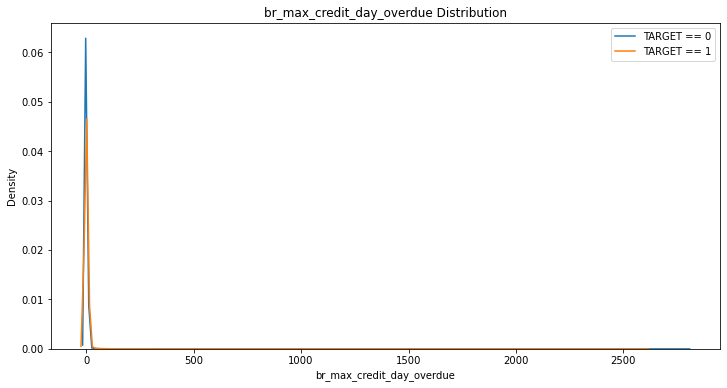

In [34]:
kde_target('br_max_credit_day_overdue', app_train)

In [35]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_max_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [36]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [37]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [38]:
#app_train['br_max_credit_day_overdue'].isnull().sum()

In [39]:
#app_train[['TARGET', 'br_max_credit_day_overdue']].corr()

In [40]:
## Yao-Johnson変換
#num_cols = ['br_max_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_max_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [41]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_credit_day_overdue']].corr()

In [42]:
## 標準化
#num_cols = ['br_max_credit_day_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_max_credit_day_overdue', 'TARGET']].corr()

In [43]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_credit_day_overdue', app_train)

In [44]:
columns = ['br_max_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_sum_credit_day_overdue

In [45]:
app_train[['TARGET', 'br_sum_credit_day_overdue']].corr()

TARGET  br_sum_credit_day_overdue
TARGET                     1.000000                  -0.001824
br_sum_credit_day_overdue -0.001824                   1.000000

In [46]:
app_train['br_sum_credit_day_overdue'].isnull().sum()

216533

The correlation between br_sum_credit_day_overdue and the TARGET is -0.0018
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


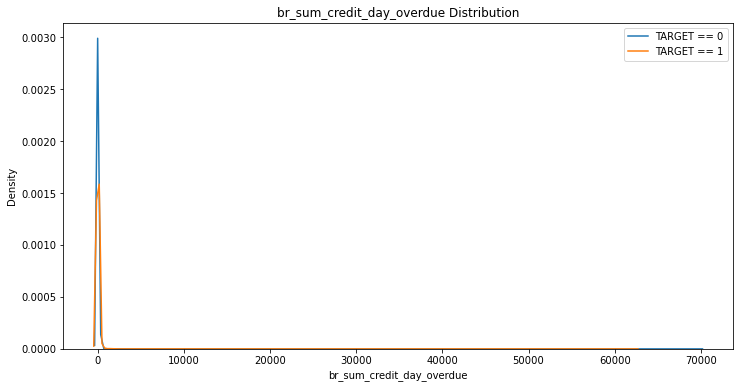

In [47]:
kde_target('br_sum_credit_day_overdue', app_train)

In [48]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_sum_credit_day_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [49]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [50]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [51]:
#app_train['br_sum_credit_day_overdue'].isnull().sum()

In [52]:
#app_train[['TARGET', 'br_sum_credit_day_overdue']].corr()

In [53]:
## Yao-Johnson変換
#num_cols = ['br_sum_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_sum_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_sum_credit_day_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_sum_credit_day_overdue']].corr()

In [54]:
## 標準化
#num_cols = ['br_sum_credit_day_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_sum_credit_day_overdue', 'TARGET']].corr()

In [55]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_sum_credit_day_overdue', app_train)

In [56]:
columns = ['br_sum_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_avg_credit_day_overdue

In [57]:
app_train[['TARGET', 'br_avg_credit_day_overdue']].corr()

TARGET  br_avg_credit_day_overdue
TARGET                     1.000000                   0.003846
br_avg_credit_day_overdue  0.003846                   1.000000

In [58]:
app_train['br_avg_credit_day_overdue'].isnull().sum()

216533

The correlation between br_avg_credit_day_overdue and the TARGET is 0.0038
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


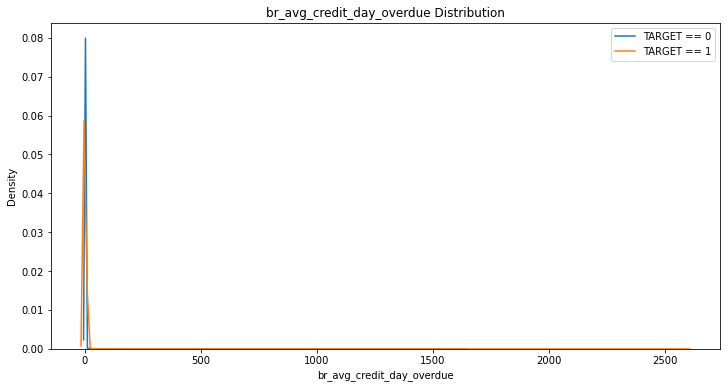

In [59]:
kde_target('br_avg_credit_day_overdue', app_train)

In [60]:
app_train['br_avg_credit_day_overdue'].isnull().sum()

216533

In [61]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_avg_credit_day_overdue')
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [62]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [63]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [64]:
#app_train['br_avg_credit_day_overdue'].isnull().sum()

In [65]:
#app_train[['TARGET', 'br_avg_credit_day_overdue']].corr()

In [66]:
## Yao-Johnson変換
#num_cols = ['br_avg_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_avg_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_avg_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [67]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_avg_credit_day_overdue']].corr()

In [68]:
## 標準化
#num_cols = ['br_avg_credit_day_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_avg_credit_day_overdue', 'TARGET']].corr()

In [69]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_avg_credit_day_overdue', app_train)

In [70]:
columns = ['br_avg_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_cnt_credit_day_overdue

In [71]:
app_train[['TARGET', 'br_cnt_credit_day_overdue']].corr()

TARGET  br_cnt_credit_day_overdue
TARGET                     1.000000                  -0.024241
br_cnt_credit_day_overdue -0.024241                   1.000000

The correlation between br_cnt_credit_day_overdue and the TARGET is -0.0242
Median value for loan that was not repaid = 55.0000
Median value for loan that was repaid =     63.0000


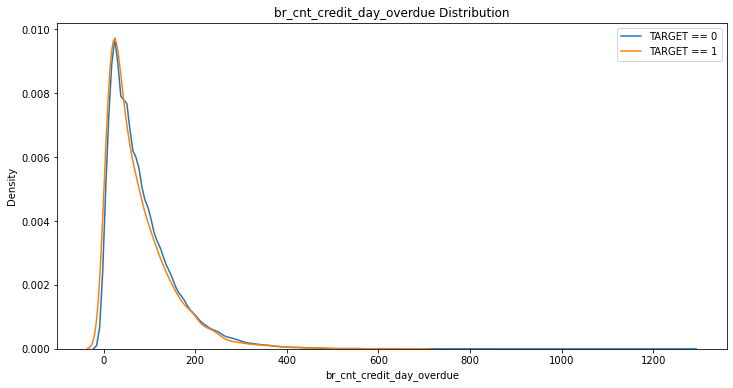

In [72]:
kde_target('br_cnt_credit_day_overdue', app_train)

In [73]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_credit_day_overdue  
0  52.715068                 132.000000  
1  49.490411                  21.000000  
2  54.898630                 100.000000  
3  38.290411                 270.000000  
4  35.726027                 117.972317  

[5 rows x 92 columns]

In [74]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [75]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [76]:
app_train['br_cnt_credit_day_overdue'].isnull().sum()

0

In [77]:
app_train[['TARGET', 'br_cnt_credit_day_overdue']].corr()

TARGET  br_cnt_credit_day_overdue
TARGET                     1.000000                  -0.027994
br_cnt_credit_day_overdue -0.027994                   1.000000

In [78]:
## Yao-Johnson変換
num_cols = ['br_cnt_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_cnt_credit_day_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_credit_day_overdue']].corr()

TARGET  br_cnt_credit_day_overdue
TARGET                     1.000000                  -0.037745
br_cnt_credit_day_overdue -0.037745                   1.000000

In [79]:
## 標準化
num_cols = ['br_cnt_credit_day_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_credit_day_overdue', 'TARGET']].corr()

br_cnt_credit_day_overdue    TARGET
br_cnt_credit_day_overdue                   1.000000 -0.037745
TARGET                                     -0.037745  1.000000

The correlation between br_cnt_credit_day_overdue and the TARGET is -0.0377
Median value for loan that was not repaid = -0.0742
Median value for loan that was repaid =     0.0408


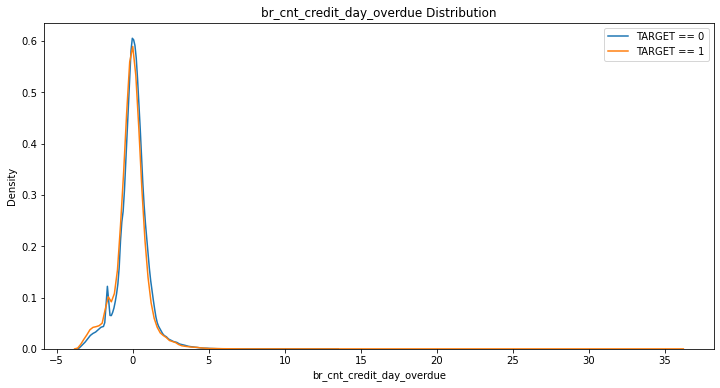

In [80]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_credit_day_overdue', app_train)

### br_stddev_credit_day_overdue

In [81]:
app_train[['TARGET', 'br_stddev_credit_day_overdue']].corr()

TARGET  br_stddev_credit_day_overdue
TARGET                        1.000000                     -0.001964
br_stddev_credit_day_overdue -0.001964                      1.000000

In [82]:
app_train['br_stddev_credit_day_overdue'].isnull().sum()

216533

The correlation between br_stddev_credit_day_overdue and the TARGET is -0.0020
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


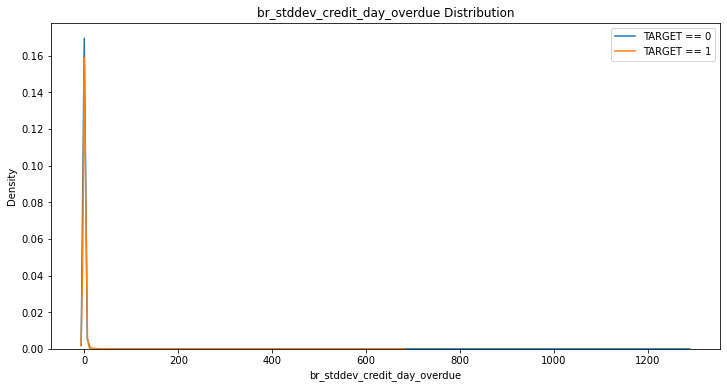

In [83]:
kde_target('br_stddev_credit_day_overdue', app_train)

In [84]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_credit_day_overdue  
0  52.715068                      0.000000  
1  49.490411                      0.000000  
2  54.898630                      0.000000  
3  38.290411                      0.000000  
4  35.726027                      0.690208  

[5 rows x 92 columns]

In [85]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [86]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [87]:
app_train['br_stddev_credit_day_overdue'].isnull().sum()

0

In [88]:
app_train[['TARGET', 'br_stddev_credit_day_overdue']].corr()

TARGET  br_stddev_credit_day_overdue
TARGET                        1.00000                      -0.00334
br_stddev_credit_day_overdue -0.00334                       1.00000

In [89]:
## Yao-Johnson変換
num_cols = ['br_stddev_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_credit_day_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_credit_day_overdue']].corr()

TARGET  br_stddev_credit_day_overdue
TARGET                        1.000000                     -0.011584
br_stddev_credit_day_overdue -0.011584                      1.000000

In [90]:
## 標準化
num_cols = ['br_stddev_credit_day_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_credit_day_overdue', 'TARGET']].corr()

br_stddev_credit_day_overdue    TARGET
br_stddev_credit_day_overdue                      1.000000 -0.011584
TARGET                                           -0.011584  1.000000

The correlation between br_stddev_credit_day_overdue and the TARGET is -0.0116
Median value for loan that was not repaid = -0.0576
Median value for loan that was repaid =     -0.0161


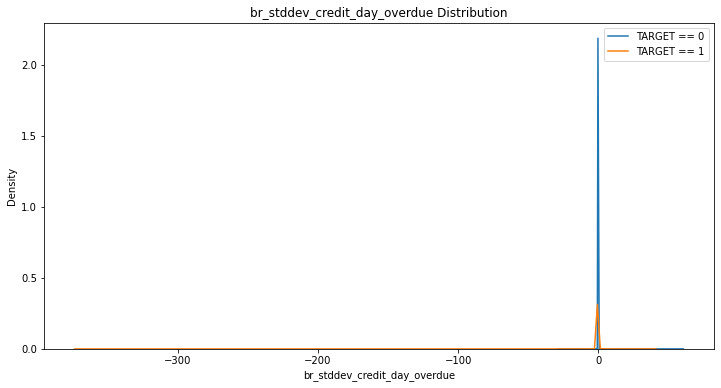

In [91]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_credit_day_overdue', app_train)

### br_stddev_pop_credit_day_overdue

In [92]:
app_train[['TARGET', 'br_stddev_pop_credit_day_overdue']].corr()

TARGET  br_stddev_pop_credit_day_overdue
TARGET                            1.000000                         -0.001964
br_stddev_pop_credit_day_overdue -0.001964                          1.000000

In [93]:
app_train['br_stddev_pop_credit_day_overdue'].isnull().sum()

216533

The correlation between br_stddev_pop_credit_day_overdue and the TARGET is -0.0020
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


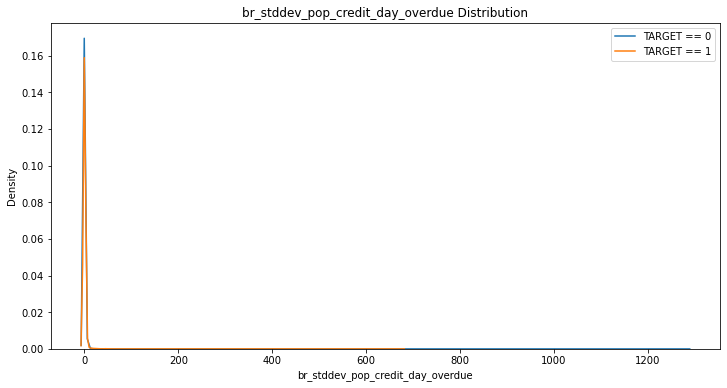

In [94]:
kde_target('br_stddev_pop_credit_day_overdue', app_train)

In [95]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_pop_credit_day_overdue  
0  52.715068                          0.000000  
1  49.490411                          0.000000  
2  54.898630                          0.000000  
3  38.290411                          0.000000  
4  35.726027                          0.690208  

[5 rows x 92 columns]

In [96]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [97]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [98]:
app_train['br_stddev_pop_credit_day_overdue'].isnull().sum()

0

In [99]:
app_train[['TARGET', 'br_stddev_pop_credit_day_overdue']].corr()

TARGET  br_stddev_pop_credit_day_overdue
TARGET                            1.00000                          -0.00334
br_stddev_pop_credit_day_overdue -0.00334                           1.00000

In [100]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_credit_day_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_credit_day_overdue']].corr()

TARGET  br_stddev_pop_credit_day_overdue
TARGET                            1.000000                         -0.011584
br_stddev_pop_credit_day_overdue -0.011584                          1.000000

In [101]:
## 標準化
num_cols = ['br_stddev_pop_credit_day_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])

The correlation between br_stddev_pop_credit_day_overdue and the TARGET is -0.0116
Median value for loan that was not repaid = -0.0576
Median value for loan that was repaid =     -0.0161


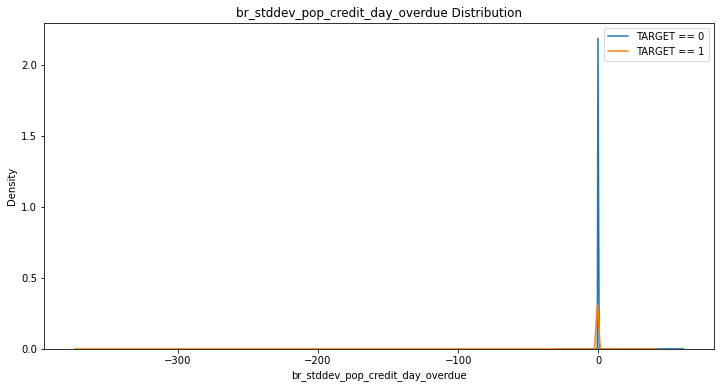

In [102]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_credit_day_overdue', app_train)

### br_var_pop_credit_day_overdue

In [103]:
app_train[['TARGET', 'br_var_pop_credit_day_overdue']].corr()

TARGET  br_var_pop_credit_day_overdue
TARGET                         1.000000                      -0.004095
br_var_pop_credit_day_overdue -0.004095                       1.000000

In [104]:
app_train['br_var_pop_credit_day_overdue'].isnull().sum()

216533

The correlation between br_var_pop_credit_day_overdue and the TARGET is -0.0041
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


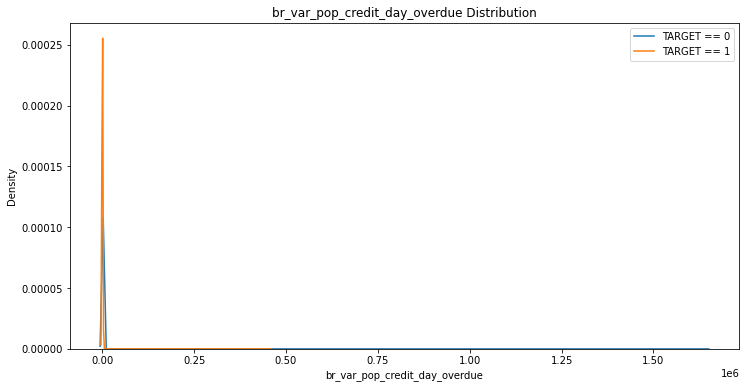

In [105]:
kde_target('br_var_pop_credit_day_overdue', app_train)

In [106]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_pop_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [107]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [108]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [109]:
app_train['br_var_pop_credit_day_overdue'].isnull().sum()

216533

In [110]:
app_train[['TARGET', 'br_var_pop_credit_day_overdue']].corr()

TARGET  br_var_pop_credit_day_overdue
TARGET                         1.000000                      -0.004095
br_var_pop_credit_day_overdue -0.004095                       1.000000

In [111]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [112]:
## 標準化
#num_cols = ['br_var_pop_credit_day_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_pop_credit_day_overdue', 'TARGET']].corr()

In [113]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_pop_credit_day_overdue', app_train)

In [114]:
columns = ['br_var_pop_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_samp_credit_day_overdue

In [115]:
app_train[['TARGET', 'br_var_samp_credit_day_overdue']].corr()

TARGET  br_var_samp_credit_day_overdue
TARGET                          1.000000                       -0.003936
br_var_samp_credit_day_overdue -0.003936                        1.000000

In [116]:
app_train['br_var_samp_credit_day_overdue'].isnull().sum()

216533

The correlation between br_var_samp_credit_day_overdue and the TARGET is -0.0039
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


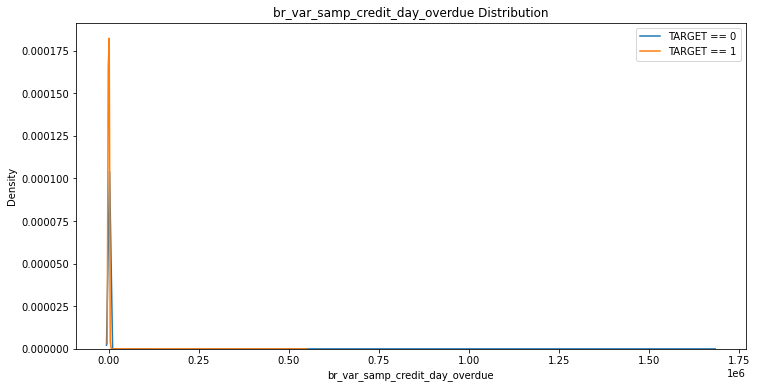

In [117]:
kde_target('br_var_samp_credit_day_overdue', app_train)

In [118]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_samp_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [119]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [120]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [121]:
#app_train['br_var_samp_credit_day_overdue'].isnull().sum()

In [122]:
#app_train[['TARGET', 'br_var_samp_credit_day_overdue']].corr()

In [123]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [124]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_credit_day_overdue']].corr()

In [125]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_credit_day_overdue', app_train)

In [126]:
columns = ['br_var_samp_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_variance_pop_credit_day_overdue

In [127]:
app_train[['TARGET', 'br_variance_pop_credit_day_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_credit_day_overdue -0.004095   

                                    br_variance_pop_credit_day_overdue  
TARGET                                                       -0.004095  
br_variance_pop_credit_day_overdue                            1.000000

In [128]:
app_train['br_variance_pop_credit_day_overdue'].isnull().sum()

216533

The correlation between br_variance_pop_credit_day_overdue and the TARGET is -0.0041
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


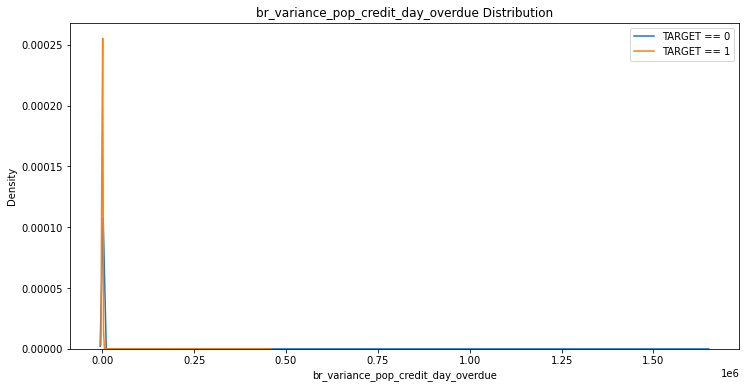

In [129]:
kde_target('br_variance_pop_credit_day_overdue', app_train)

In [130]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_variance_pop_credit_day_overdue')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [131]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [132]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [133]:
#app_train['br_variance_pop_credit_day_overdue'].isnull().sum()

In [134]:
#app_train[['TARGET', 'br_variance_pop_credit_day_overdue']].corr()

In [135]:
## Yao-Johnson変換
#num_cols = ['br_variance_pop_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_variance_pop_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_variance_pop_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [136]:
## 標準化
#num_cols = ['br_variance_pop_credit_day_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_variance_pop_credit_day_overdue', 'TARGET']].corr()

In [137]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_variance_pop_credit_day_overdue', app_train)

In [138]:
columns = ['br_variance_pop_credit_day_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_min_days_credit_enddate

In [139]:
app_train[['TARGET', 'br_min_days_credit_enddate']].corr()

TARGET  br_min_days_credit_enddate
TARGET                      1.000000                    0.033942
br_min_days_credit_enddate  0.033942                    1.000000

In [140]:
app_train['br_min_days_credit_enddate'].isnull().sum()

216533

The correlation between br_min_days_credit_enddate and the TARGET is 0.0339
Median value for loan that was not repaid = -604.5000
Median value for loan that was repaid =     -845.0000


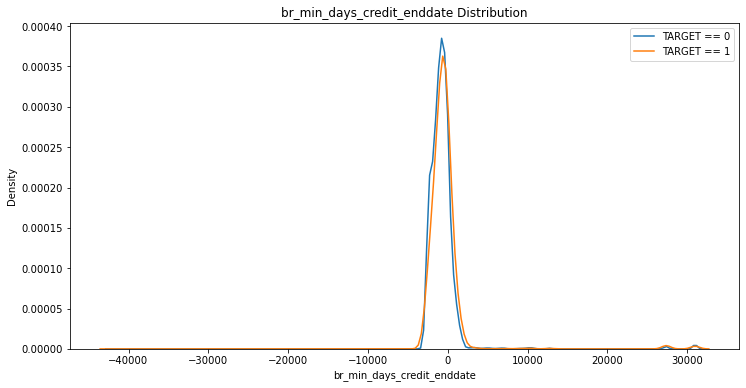

In [141]:
kde_target('br_min_days_credit_enddate', app_train)

In [142]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_min_days_credit_enddate')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_min_days_credit_enddate  
0  52.715068                -1329.000000  
1  49.490411                 -128.000000  
2  54.898630                -1707.000000  
3  38.290411                -1862.000000  
4  35.726027                -1023.520789  

[5 rows x 92 columns]

In [143]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [144]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [145]:
app_train['br_min_days_credit_enddate'].isnull().sum()

0

In [146]:
app_train[['TARGET', 'br_min_days_credit_enddate']].corr()

TARGET  br_min_days_credit_enddate
TARGET                      1.000000                    0.035888
br_min_days_credit_enddate  0.035888                    1.000000

In [147]:
## Yao-Johnson変換
num_cols = ['br_min_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_min_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [148]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_days_credit_enddate']].corr()

TARGET  br_min_days_credit_enddate
TARGET                      1.000000                    0.062243
br_min_days_credit_enddate  0.062243                    1.000000

The correlation between br_min_days_credit_enddate and the TARGET is 0.0622
Median value for loan that was not repaid = 0.3307
Median value for loan that was repaid =     0.0819


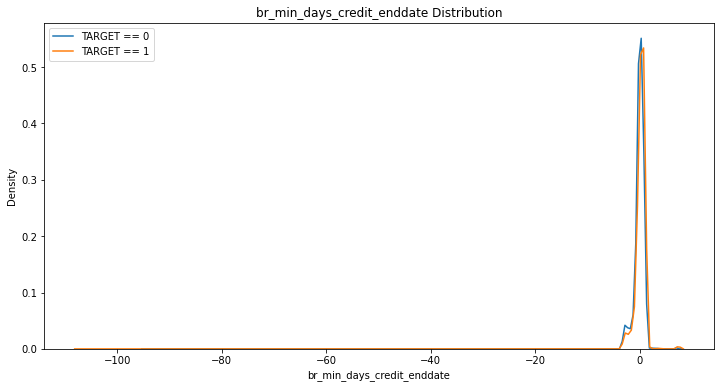

In [149]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_days_credit_enddate', app_train)

### br_max_days_credit_enddate

In [150]:
app_train[['TARGET', 'br_max_days_credit_enddate']].corr()

TARGET  br_max_days_credit_enddate
TARGET                      1.000000                    0.037627
br_max_days_credit_enddate  0.037627                    1.000000

In [151]:
app_train['br_max_days_credit_enddate'].isnull().sum()

216533

The correlation between br_max_days_credit_enddate and the TARGET is 0.0376
Median value for loan that was not repaid = 1106.5000
Median value for loan that was repaid =     913.0000


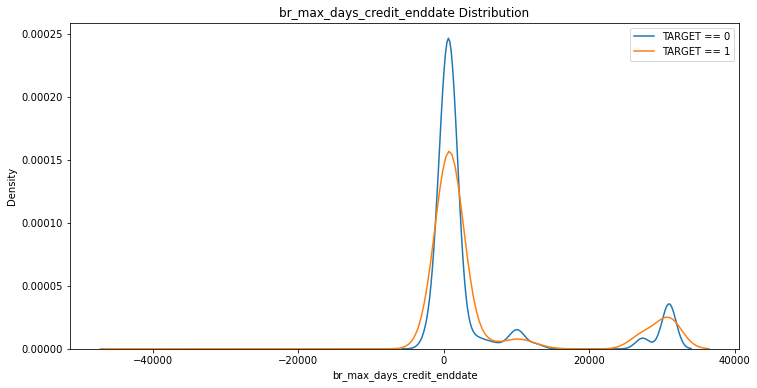

In [152]:
kde_target('br_max_days_credit_enddate', app_train)

In [153]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_max_days_credit_enddate')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_max_days_credit_enddate  
0  52.715068                 1778.000000  
1  49.490411                 1324.000000  
2  54.898630                 -567.000000  
3  38.290411                30885.000000  
4  35.726027                 5406.274462  

[5 rows x 92 columns]

In [154]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [155]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [156]:
app_train['br_max_days_credit_enddate'].isnull().sum()

0

In [157]:
app_train[['TARGET', 'br_max_days_credit_enddate']].corr()

TARGET  br_max_days_credit_enddate
TARGET                      1.000000                    0.027588
br_max_days_credit_enddate  0.027588                    1.000000

In [158]:
## Yao-Johnson変換
num_cols = ['br_max_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_max_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_days_credit_enddate']].corr()

TARGET  br_max_days_credit_enddate
TARGET                      1.000000                    0.028027
br_max_days_credit_enddate  0.028027                    1.000000

In [159]:
## 標準化
num_cols = ['br_max_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_max_days_credit_enddate', 'TARGET']].corr()

br_max_days_credit_enddate    TARGET
br_max_days_credit_enddate                    1.000000  0.028027
TARGET                                        0.028027  1.000000

The correlation between br_max_days_credit_enddate and the TARGET is 0.0280
Median value for loan that was not repaid = 0.0899
Median value for loan that was repaid =     0.0395


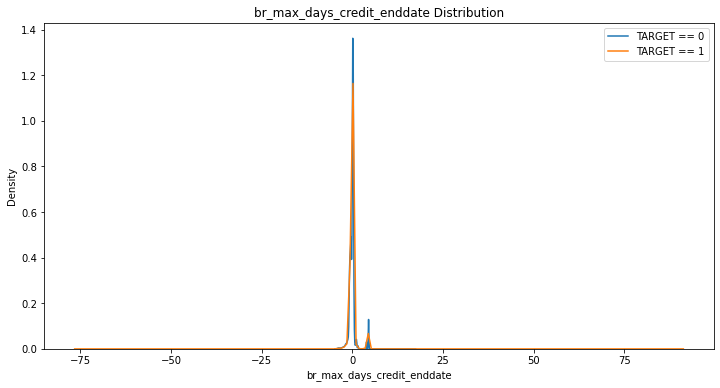

In [160]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_days_credit_enddate', app_train)

The correlation between br_max_days_credit_enddate and the TARGET is 0.0280
Median value for loan that was not repaid = 0.0899
Median value for loan that was repaid =     0.0395


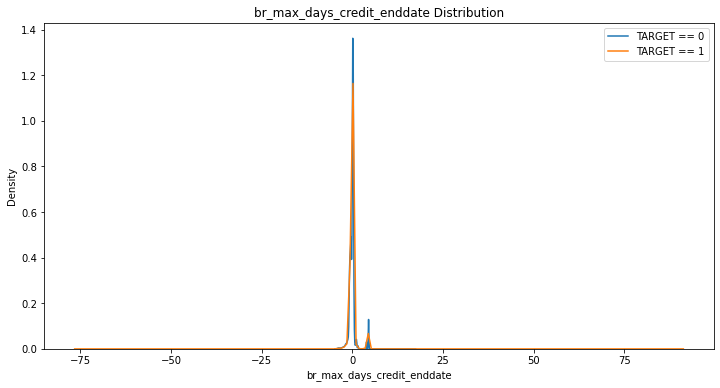

In [161]:
kde_target('br_max_days_credit_enddate', app_train)

### br_sum_days_credit_enddate

In [162]:
app_train[['TARGET', 'br_sum_days_credit_enddate']].corr()

TARGET  br_sum_days_credit_enddate
TARGET                      1.000000                    0.033882
br_sum_days_credit_enddate  0.033882                    1.000000

In [163]:
app_train['br_sum_days_credit_enddate'].isnull().sum()

216533

The correlation between br_sum_days_credit_enddate and the TARGET is 0.0339
Median value for loan that was not repaid = 3173.0000
Median value for loan that was repaid =     -1074.0000


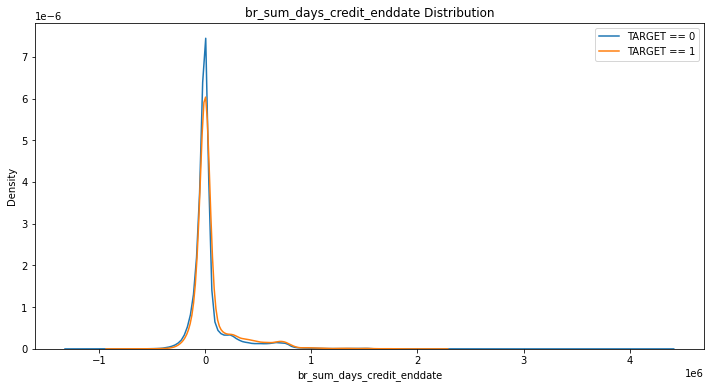

In [164]:
kde_target('br_sum_days_credit_enddate', app_train)

In [165]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_sum_days_credit_enddate')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_sum_days_credit_enddate  
0  52.715068               -37635.000000  
1  49.490411                 5322.000000  
2  54.898630              -106800.000000  
3  38.290411               583835.000000  
4  35.726027                54490.475537  

[5 rows x 92 columns]

In [166]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [167]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [168]:
app_train['br_sum_days_credit_enddate'].isnull().sum()

0

In [169]:
app_train[['TARGET', 'br_sum_days_credit_enddate']].corr()

TARGET  br_sum_days_credit_enddate
TARGET                      1.000000                    0.026002
br_sum_days_credit_enddate  0.026002                    1.000000

In [170]:
## Yao-Johnson変換
num_cols = ['br_sum_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_sum_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_days_credit_enddate']].corr()

TARGET  br_sum_days_credit_enddate
TARGET                      1.00000                     0.02946
br_sum_days_credit_enddate  0.02946                     1.00000

In [171]:
## 標準化
num_cols = ['br_sum_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_sum_days_credit_enddate', 'TARGET']].corr()

br_sum_days_credit_enddate   TARGET
br_sum_days_credit_enddate                     1.00000  0.02946
TARGET                                         0.02946  1.00000

The correlation between br_sum_days_credit_enddate and the TARGET is 0.0295
Median value for loan that was not repaid = 0.0716
Median value for loan that was repaid =     0.0241


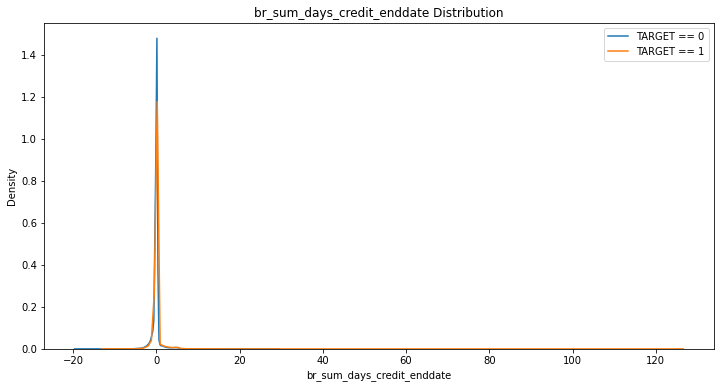

In [172]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_days_credit_enddate', app_train)

### br_avg_days_credit_enddate

In [173]:
app_train[['TARGET', 'br_avg_days_credit_enddate']].corr()

TARGET  br_avg_days_credit_enddate
TARGET                      1.000000                    0.043224
br_avg_days_credit_enddate  0.043224                    1.000000

In [174]:
app_train['br_avg_days_credit_enddate'].isnull().sum()

216533

The correlation between br_avg_days_credit_enddate and the TARGET is 0.0432
Median value for loan that was not repaid = 156.3093
Median value for loan that was repaid =     -38.7708


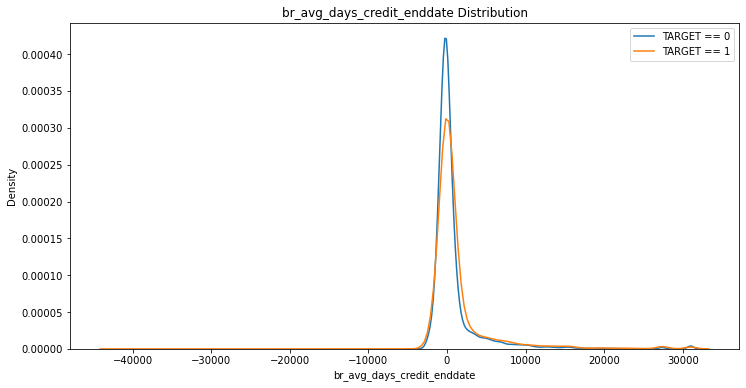

In [175]:
kde_target('br_avg_days_credit_enddate', app_train)

In [176]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_days_credit_enddate')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_avg_days_credit_enddate  
0  52.715068                 -285.113600  
1  49.490411                  253.428600  
2  54.898630                -1068.000000  
3  38.290411                 2473.877100  
4  35.726027                  654.906643  

[5 rows x 92 columns]

In [177]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [178]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [179]:
app_train['br_avg_days_credit_enddate'].isnull().sum()

0

In [180]:
app_train[['TARGET', 'br_avg_days_credit_enddate']].corr()

TARGET  br_avg_days_credit_enddate
TARGET                      1.000000                    0.039134
br_avg_days_credit_enddate  0.039134                    1.000000

In [181]:
## Yao-Johnson変換
num_cols = ['br_avg_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_avg_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_days_credit_enddate']].corr()

TARGET  br_avg_days_credit_enddate
TARGET                      1.000000                    0.042681
br_avg_days_credit_enddate  0.042681                    1.000000

In [182]:
## 標準化
num_cols = ['br_avg_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_days_credit_enddate', 'TARGET']].corr()

br_avg_days_credit_enddate    TARGET
br_avg_days_credit_enddate                    1.000000  0.042681
TARGET                                        0.042681  1.000000

The correlation between br_avg_days_credit_enddate and the TARGET is 0.0427
Median value for loan that was not repaid = 0.1436
Median value for loan that was repaid =     0.0568


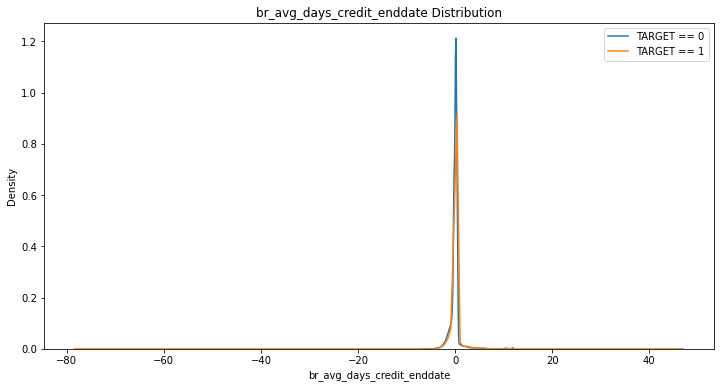

In [183]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_days_credit_enddate', app_train)

### br_cnt_days_credit_enddate

In [184]:
app_train[['TARGET', 'br_cnt_days_credit_enddate']].corr()

TARGET  br_cnt_days_credit_enddate
TARGET                      1.000000                   -0.029017
br_cnt_days_credit_enddate -0.029017                    1.000000

In [185]:
app_train['br_cnt_days_credit_enddate'].isnull().sum()

216533

The correlation between br_cnt_days_credit_enddate and the TARGET is -0.0290
Median value for loan that was not repaid = 50.0000
Median value for loan that was repaid =     58.0000


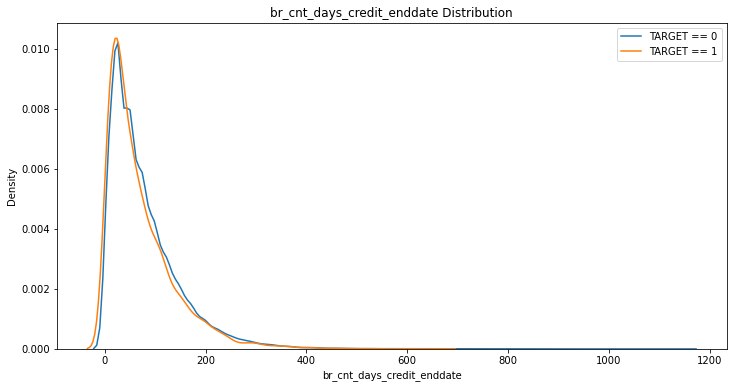

In [186]:
kde_target('br_cnt_days_credit_enddate', app_train)

In [187]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_days_credit_enddate')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_days_credit_enddate  
0  52.715068                  132.000000  
1  49.490411                   21.000000  
2  54.898630                  100.000000  
3  38.290411                  236.000000  
4  35.726027                  111.156951  

[5 rows x 92 columns]

In [188]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [189]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [190]:
app_train['br_cnt_days_credit_enddate'].isnull().sum()

0

In [191]:
app_train[['TARGET', 'br_cnt_days_credit_enddate']].corr()

TARGET  br_cnt_days_credit_enddate
TARGET                      1.000000                   -0.033857
br_cnt_days_credit_enddate -0.033857                    1.000000

In [192]:
## Yao-Johnson変換
num_cols = ['br_cnt_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_cnt_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_days_credit_enddate']].corr()

TARGET  br_cnt_days_credit_enddate
TARGET                      1.000000                   -0.044574
br_cnt_days_credit_enddate -0.044574                    1.000000

In [193]:
## 標準化
num_cols = ['br_cnt_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_days_credit_enddate', 'TARGET']].corr()

br_cnt_days_credit_enddate    TARGET
br_cnt_days_credit_enddate                    1.000000 -0.044574
TARGET                                       -0.044574  1.000000

The correlation between br_cnt_days_credit_enddate and the TARGET is -0.0446
Median value for loan that was not repaid = -0.0908
Median value for loan that was repaid =     0.0453


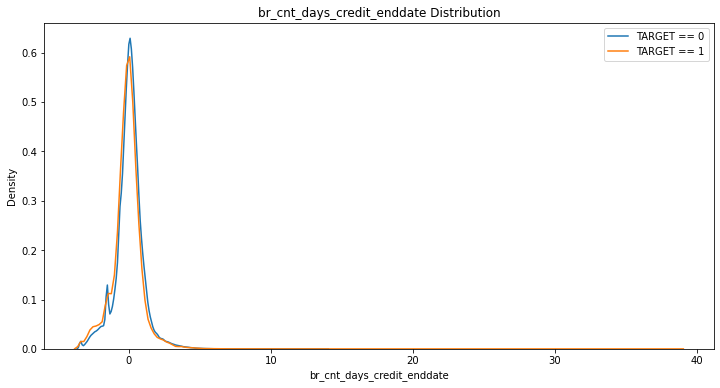

In [194]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_days_credit_enddate', app_train)

### br_stddev_days_credit_enddate

In [195]:
app_train[['TARGET', 'br_stddev_days_credit_enddate']].corr()

TARGET  br_stddev_days_credit_enddate
TARGET                         1.000000                       0.027366
br_stddev_days_credit_enddate  0.027366                       1.000000

In [196]:
app_train['br_stddev_days_credit_enddate'].isnull().sum()

216533

The correlation between br_stddev_days_credit_enddate and the TARGET is 0.0274
Median value for loan that was not repaid = 620.3881
Median value for loan that was repaid =     618.9062


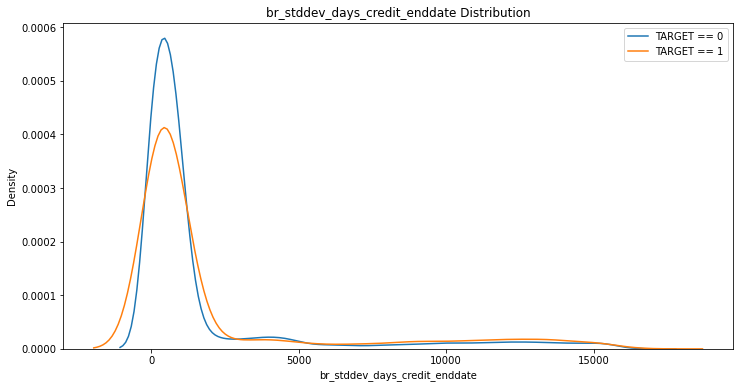

In [197]:
kde_target('br_stddev_days_credit_enddate', app_train)

In [198]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_days_credit_enddate')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_days_credit_enddate  
0  52.715068                     730.931708  
1  49.490411                     604.498105  
2  54.898630                     413.836924  
3  38.290411                    9816.702674  
4  35.726027                    2167.061882  

[5 rows x 92 columns]

In [199]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [200]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [201]:
app_train['br_stddev_days_credit_enddate'].isnull().sum()

0

In [202]:
app_train[['TARGET', 'br_stddev_days_credit_enddate']].corr()

TARGET  br_stddev_days_credit_enddate
TARGET                         1.000000                       0.020102
br_stddev_days_credit_enddate  0.020102                       1.000000

In [203]:
## Yao-Johnson変換
#num_cols = ['br_stddev_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_days_credit_enddate']].corr()

In [204]:
## 標準化
num_cols = ['br_stddev_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_days_credit_enddate', 'TARGET']].corr()

br_stddev_days_credit_enddate    TARGET
br_stddev_days_credit_enddate                       1.000000  0.020102
TARGET                                              0.020102  1.000000

The correlation between br_stddev_days_credit_enddate and the TARGET is 0.0201
Median value for loan that was not repaid = 0.0043
Median value for loan that was repaid =     -0.0277


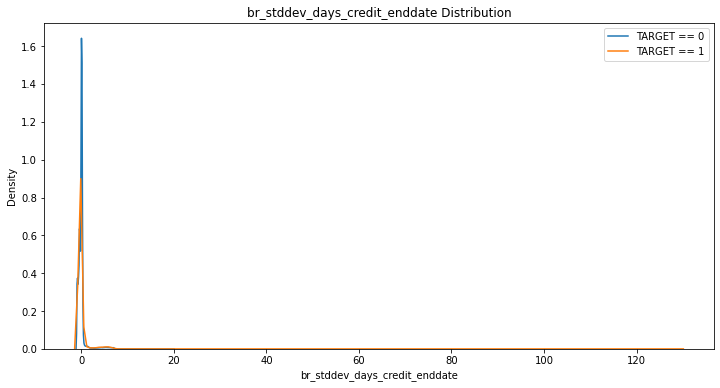

In [205]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_days_credit_enddate', app_train)

### br_stddev_pop_days_credit_enddate

In [206]:
app_train[['TARGET', 'br_stddev_pop_days_credit_enddate']].corr()

TARGET  br_stddev_pop_days_credit_enddate
TARGET                             1.000000                           0.027366
br_stddev_pop_days_credit_enddate  0.027366                           1.000000

In [207]:
app_train['br_stddev_pop_days_credit_enddate'].isnull().sum()

216533

The correlation between br_stddev_pop_days_credit_enddate and the TARGET is 0.0274
Median value for loan that was not repaid = 620.3881
Median value for loan that was repaid =     618.9062


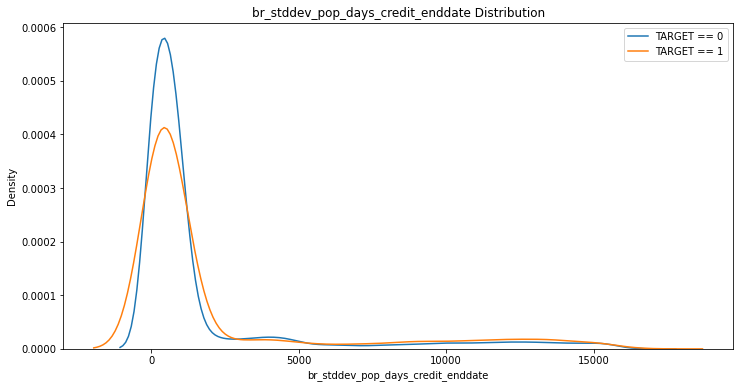

In [208]:
kde_target('br_stddev_pop_days_credit_enddate', app_train)

In [209]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_days_credit_enddate')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_pop_days_credit_enddate  
0  52.715068                         730.931708  
1  49.490411                         604.498105  
2  54.898630                         413.836924  
3  38.290411                        9816.702674  
4  35.726027                        2167.061882  

[5 rows x 92 columns]

In [210]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [211]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [212]:
app_train['br_stddev_pop_days_credit_enddate'].isnull().sum()

0

In [213]:
app_train[['TARGET', 'br_stddev_pop_days_credit_enddate']].corr()

TARGET  br_stddev_pop_days_credit_enddate
TARGET                             1.000000                           0.020102
br_stddev_pop_days_credit_enddate  0.020102                           1.000000

In [214]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_days_credit_enddate']].corr()

In [215]:
## 標準化
num_cols = ['br_stddev_pop_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_pop_days_credit_enddate', 'TARGET']].corr()

br_stddev_pop_days_credit_enddate    TARGET
br_stddev_pop_days_credit_enddate                           1.000000  0.020102
TARGET                                                      0.020102  1.000000

The correlation between br_stddev_pop_days_credit_enddate and the TARGET is 0.0201
Median value for loan that was not repaid = 0.0043
Median value for loan that was repaid =     -0.0277


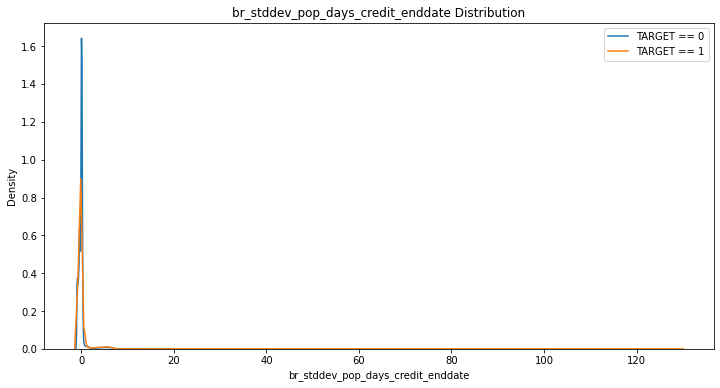

In [216]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_days_credit_enddate', app_train)

### br_var_pop_days_credit_enddate

In [217]:
app_train[['TARGET', 'br_var_pop_days_credit_enddate']].corr()

TARGET  br_var_pop_days_credit_enddate
TARGET                          1.000000                        0.028361
br_var_pop_days_credit_enddate  0.028361                        1.000000

In [218]:
app_train['br_var_pop_days_credit_enddate'].isnull().sum()

216533

The correlation between br_var_pop_days_credit_enddate and the TARGET is 0.0284
Median value for loan that was not repaid = 384881.3932
Median value for loan that was repaid =     383044.8725


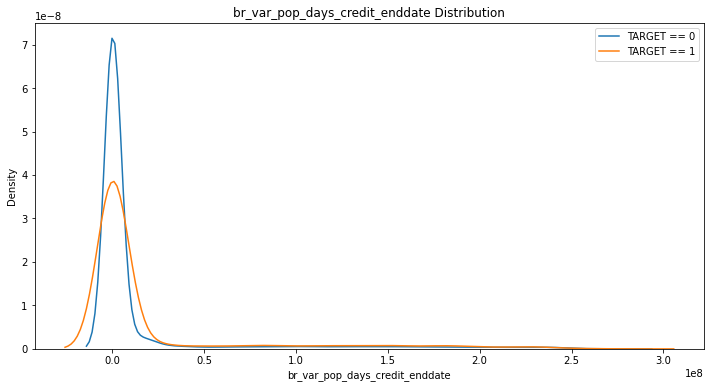

In [219]:
kde_target('br_var_pop_days_credit_enddate', app_train)

In [220]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_pop_days_credit_enddate')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_pop_days_credit_enddate  
0  52.715068                    5.342612e+05  
1  49.490411                    3.654180e+05  
2  54.898630                    1.712610e+05  
3  38.290411                    9.636765e+07  
4  35.726027                    1.706166e+07  

[5 rows x 92 columns]

In [221]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [222]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [223]:
app_train['br_var_pop_days_credit_enddate'].isnull().sum()

0

In [224]:
app_train[['TARGET', 'br_var_pop_days_credit_enddate']].corr()

TARGET  br_var_pop_days_credit_enddate
TARGET                          1.000000                        0.023007
br_var_pop_days_credit_enddate  0.023007                        1.000000

In [225]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_pop_days_credit_enddate']].corr()

In [226]:
## 標準化
num_cols = ['br_var_pop_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_pop_days_credit_enddate', 'TARGET']].corr()

br_var_pop_days_credit_enddate    TARGET
br_var_pop_days_credit_enddate                        1.000000  0.023007
TARGET                                                0.023007  1.000000

The correlation between br_var_pop_days_credit_enddate and the TARGET is 0.0230
Median value for loan that was not repaid = 0.0055
Median value for loan that was repaid =     -0.0341


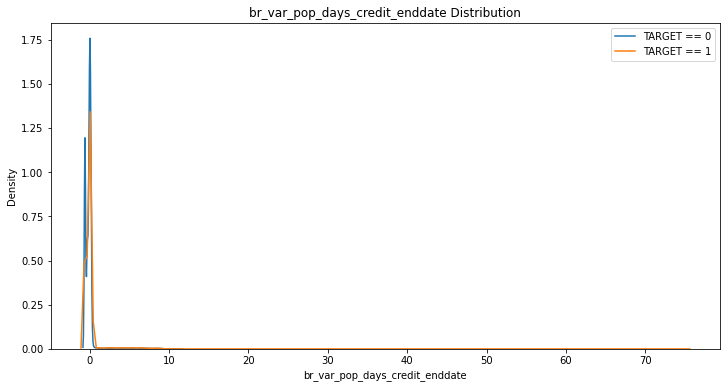

In [227]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_days_credit_enddate', app_train)

### br_var_samp_days_credit_enddate

In [228]:
app_train[['TARGET', 'br_var_samp_days_credit_enddate']].corr()

TARGET  br_var_samp_days_credit_enddate
TARGET                           1.000000                         0.028933
br_var_samp_days_credit_enddate  0.028933                         1.000000

In [229]:
app_train['br_var_samp_days_credit_enddate'].isnull().sum()

216533

The correlation between br_var_samp_days_credit_enddate and the TARGET is 0.0289
Median value for loan that was not repaid = 392730.8977
Median value for loan that was repaid =     389619.0633


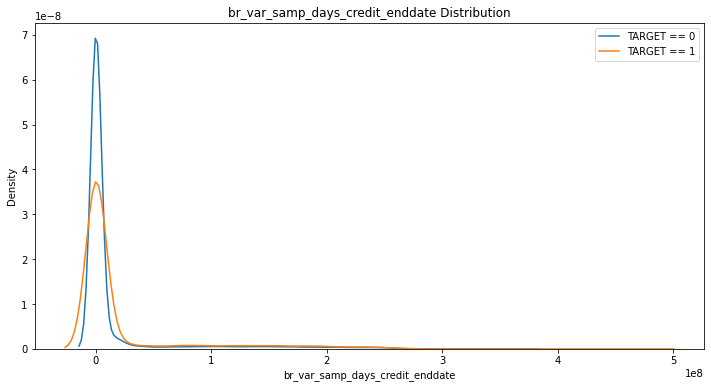

In [230]:
kde_target('br_var_samp_days_credit_enddate', app_train)

In [231]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_samp_days_credit_enddate')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_samp_days_credit_enddate  
0  52.715068                     5.383395e+05  
1  49.490411                     3.836889e+05  
2  54.898630                     1.729909e+05  
3  38.290411                     9.677773e+07  
4  35.726027                     1.726042e+07  

[5 rows x 92 columns]

In [232]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [233]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [234]:
app_train['br_var_samp_days_credit_enddate'].isnull().sum()

0

In [235]:
app_train[['TARGET', 'br_var_samp_days_credit_enddate']].corr()

TARGET  br_var_samp_days_credit_enddate
TARGET                           1.000000                         0.023527
br_var_samp_days_credit_enddate  0.023527                         1.000000

In [236]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_days_credit_enddate']].corr()

In [237]:
## 標準化
num_cols = ['br_var_samp_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_samp_days_credit_enddate', 'TARGET']].corr()

br_var_samp_days_credit_enddate    TARGET
br_var_samp_days_credit_enddate                         1.000000  0.023527
TARGET                                                  0.023527  1.000000

The correlation between br_var_samp_days_credit_enddate and the TARGET is 0.0235
Median value for loan that was not repaid = 0.0060
Median value for loan that was repaid =     -0.0347


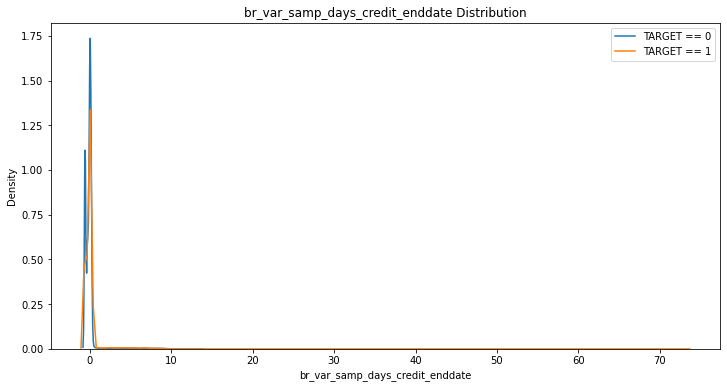

In [238]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_days_credit_enddate', app_train)

### br_variance_pop_days_credit_enddate

In [239]:
app_train[['TARGET', 'br_variance_pop_days_credit_enddate']].corr()

TARGET  \
TARGET                               1.000000   
br_variance_pop_days_credit_enddate  0.028361   

                                     br_variance_pop_days_credit_enddate  
TARGET                                                          0.028361  
br_variance_pop_days_credit_enddate                             1.000000

In [240]:
app_train['br_variance_pop_days_credit_enddate'].isnull().sum()

216533

The correlation between br_variance_pop_days_credit_enddate and the TARGET is 0.0284
Median value for loan that was not repaid = 384881.3932
Median value for loan that was repaid =     383044.8725


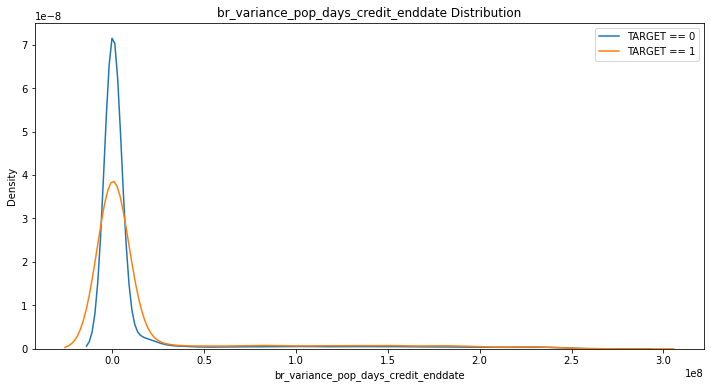

In [241]:
kde_target('br_variance_pop_days_credit_enddate', app_train)

In [242]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_variance_pop_days_credit_enddate')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_variance_pop_days_credit_enddate  
0  52.715068                         5.342612e+05  
1  49.490411                         3.654180e+05  
2  54.898630                         1.712610e+05  
3  38.290411                         9.636765e+07  
4  35.726027                         1.706166e+07  

[5 rows x 92 columns]

In [243]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [244]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [245]:
app_train['br_variance_pop_days_credit_enddate'].isnull().sum()

0

In [246]:
app_train[['TARGET', 'br_variance_pop_days_credit_enddate']].corr()

TARGET  \
TARGET                               1.000000   
br_variance_pop_days_credit_enddate  0.023007   

                                     br_variance_pop_days_credit_enddate  
TARGET                                                          0.023007  
br_variance_pop_days_credit_enddate                             1.000000

In [247]:
## Yao-Johnson変換
#num_cols = ['br_variance_pop_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_variance_pop_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_variance_pop_days_credit_enddate'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_variance_pop_days_credit_enddate']].corr()

In [248]:
## 標準化
num_cols = ['br_variance_pop_days_credit_enddate']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_variance_pop_days_credit_enddate', 'TARGET']].corr()

br_variance_pop_days_credit_enddate  \
br_variance_pop_days_credit_enddate                             1.000000   
TARGET                                                          0.023007   

                                       TARGET  
br_variance_pop_days_credit_enddate  0.023007  
TARGET                               1.000000

The correlation between br_variance_pop_days_credit_enddate and the TARGET is 0.0230
Median value for loan that was not repaid = 0.0055
Median value for loan that was repaid =     -0.0341


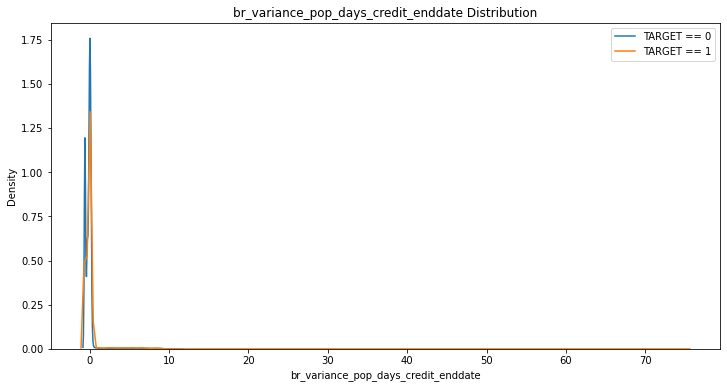

In [249]:
kde_target('br_variance_pop_days_credit_enddate', app_train)

### br_min_days_enddate_fact

In [250]:
app_train[['TARGET', 'br_min_days_enddate_fact']].corr()

TARGET  br_min_days_enddate_fact
TARGET                    1.000000                  0.062834
br_min_days_enddate_fact  0.062834                  1.000000

In [251]:
app_train['br_min_days_enddate_fact'].isnull().sum()

216533

The correlation between br_min_days_enddate_fact and the TARGET is 0.0628
Median value for loan that was not repaid = -667.0000
Median value for loan that was repaid =     -914.0000


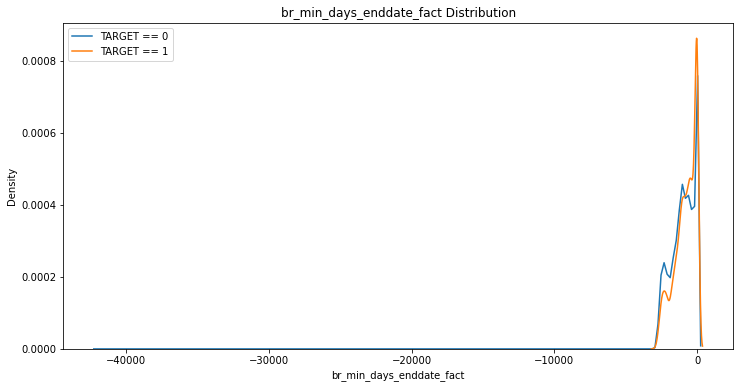

In [252]:
kde_target('br_min_days_enddate_fact', app_train)

In [253]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_min_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_min_days_enddate_fact  
0  52.715068              -1328.000000  
1  49.490411               -123.000000  
2  54.898630              -1334.000000  
3  38.290411              -1862.000000  
4  35.726027              -1279.888792  

[5 rows x 92 columns]

In [254]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [255]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [256]:
app_train['br_min_days_enddate_fact'].isnull().sum()

0

In [257]:
app_train[['TARGET', 'br_min_days_enddate_fact']].corr()

TARGET  br_min_days_enddate_fact
TARGET                    1.000000                  0.089076
br_min_days_enddate_fact  0.089076                  1.000000

In [258]:
## Yao-Johnson変換
num_cols = ['br_min_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_min_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_days_enddate_fact']].corr()

TARGET  br_min_days_enddate_fact
TARGET                    1.000000                  0.089922
br_min_days_enddate_fact  0.089922                  1.000000

In [259]:
## 標準化
num_cols = ['br_min_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_min_days_enddate_fact', 'TARGET']].corr()

br_min_days_enddate_fact    TARGET
br_min_days_enddate_fact                  1.000000  0.089922
TARGET                                    0.089922  1.000000

The correlation between br_min_days_enddate_fact and the TARGET is 0.0899
Median value for loan that was not repaid = 0.2330
Median value for loan that was repaid =     -0.1061


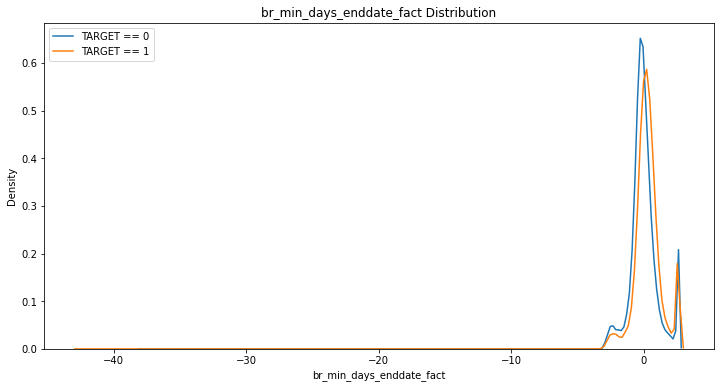

In [260]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_days_enddate_fact', app_train)

### br_max_days_enddate_fact

In [261]:
app_train[['TARGET', 'br_max_days_enddate_fact']].corr()

TARGET  br_max_days_enddate_fact
TARGET                    1.000000                  0.034308
br_max_days_enddate_fact  0.034308                  1.000000

In [262]:
app_train['br_max_days_enddate_fact'].isnull().sum()

216533

The correlation between br_max_days_enddate_fact and the TARGET is 0.0343
Median value for loan that was not repaid = -201.0000
Median value for loan that was repaid =     -251.0000


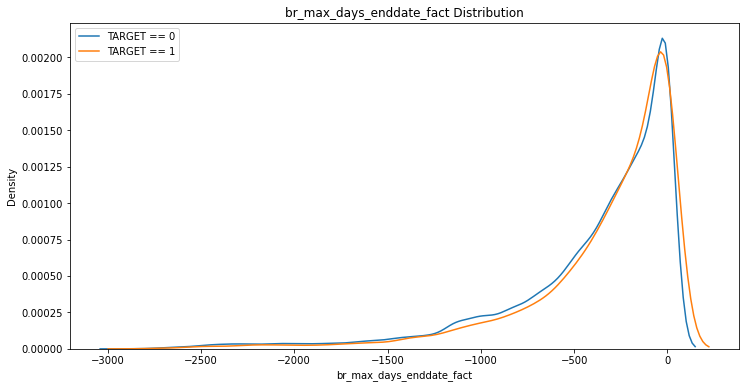

In [263]:
kde_target('br_max_days_enddate_fact', app_train)

In [264]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_max_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_max_days_enddate_fact  
0  52.715068               -544.000000  
1  49.490411               -123.000000  
2  54.898630               -549.000000  
3  38.290411               -687.000000  
4  35.726027               -441.385853  

[5 rows x 92 columns]

In [265]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [266]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [267]:
app_train['br_max_days_enddate_fact'].isnull().sum()

0

In [268]:
app_train[['TARGET', 'br_max_days_enddate_fact']].corr()

TARGET  br_max_days_enddate_fact
TARGET                    1.000000                  0.064929
br_max_days_enddate_fact  0.064929                  1.000000

In [269]:
## Yao-Johnson変換
num_cols = ['br_max_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_max_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_days_enddate_fact']].corr()

TARGET  br_max_days_enddate_fact
TARGET                    1.00000                   0.06726
br_max_days_enddate_fact  0.06726                   1.00000

In [270]:
## 標準化
num_cols = ['br_max_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_max_days_enddate_fact', 'TARGET']].corr()

br_max_days_enddate_fact   TARGET
br_max_days_enddate_fact                   1.00000  0.06726
TARGET                                     0.06726  1.00000

The correlation between br_max_days_enddate_fact and the TARGET is 0.0673
Median value for loan that was not repaid = 0.2457
Median value for loan that was repaid =     -0.0304


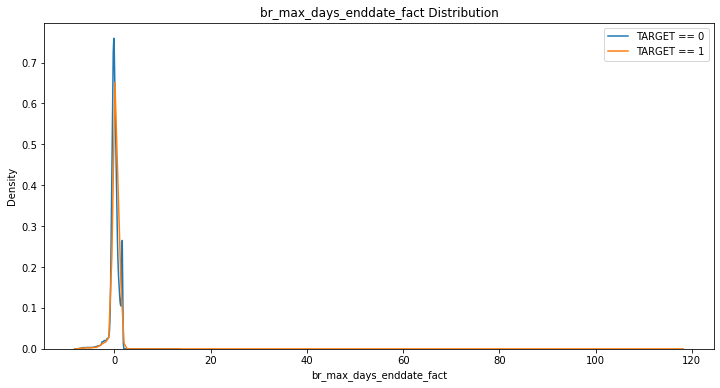

In [271]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_days_enddate_fact', app_train)

### br_sum_days_enddate_fact

In [272]:
app_train[['TARGET', 'br_sum_days_enddate_fact']].corr()

TARGET  br_sum_days_enddate_fact
TARGET                    1.000000                  0.049101
br_sum_days_enddate_fact  0.049101                  1.000000

In [273]:
app_train['br_sum_days_enddate_fact'].isnull().sum()

216533

The correlation between br_sum_days_enddate_fact and the TARGET is 0.0491
Median value for loan that was not repaid = -17290.5000
Median value for loan that was repaid =     -27962.0000


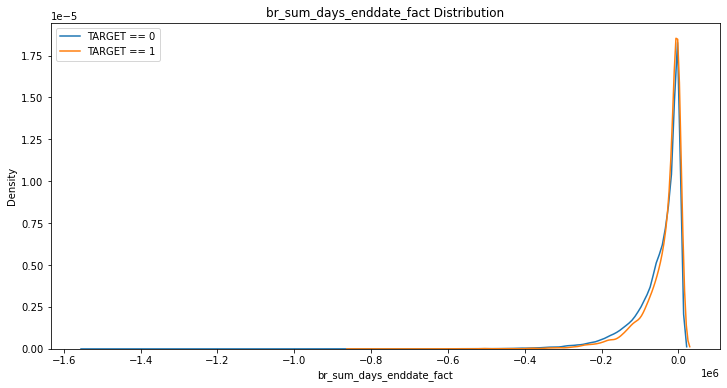

In [274]:
kde_target('br_sum_days_enddate_fact', app_train)

In [275]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_sum_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_sum_days_enddate_fact  
0  52.715068             -82550.000000  
1  49.490411              -1599.000000  
2  54.898630            -105475.000000  
3  38.290411            -216700.000000  
4  35.726027             -96298.490923  

[5 rows x 92 columns]

In [276]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [277]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [278]:
app_train['br_sum_days_enddate_fact'].isnull().sum()

0

In [279]:
app_train[['TARGET', 'br_sum_days_enddate_fact']].corr()

TARGET  br_sum_days_enddate_fact
TARGET                    1.000000                  0.048633
br_sum_days_enddate_fact  0.048633                  1.000000

In [280]:
## Yao-Johnson変換
num_cols = ['br_sum_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_sum_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_days_enddate_fact']].corr()

TARGET  br_sum_days_enddate_fact
TARGET                    1.000000                  0.054721
br_sum_days_enddate_fact  0.054721                  1.000000

In [281]:
## 標準化
num_cols = ['br_sum_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_sum_days_enddate_fact', 'TARGET']].corr()

br_sum_days_enddate_fact    TARGET
br_sum_days_enddate_fact                  1.000000  0.054721
TARGET                                    0.054721  1.000000

The correlation between br_sum_days_enddate_fact and the TARGET is 0.0547
Median value for loan that was not repaid = 0.1518
Median value for loan that was repaid =     -0.0261


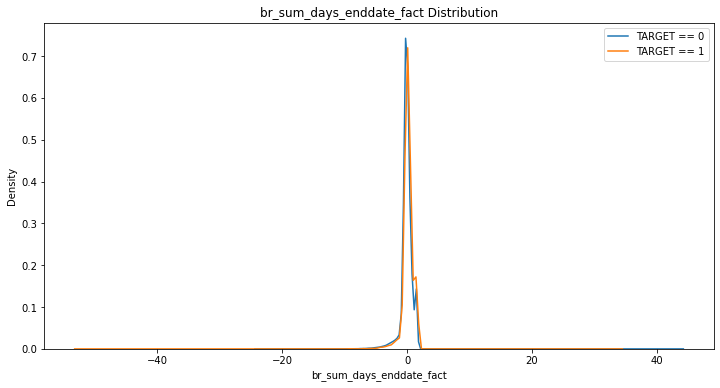

In [282]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_days_enddate_fact', app_train)

### br_avg_days_enddate_fact

In [283]:
app_train[['TARGET', 'br_avg_days_enddate_fact']].corr()

TARGET  br_avg_days_enddate_fact
TARGET                    1.000000                  0.059438
br_avg_days_enddate_fact  0.059438                  1.000000

In [284]:
app_train['br_avg_days_enddate_fact'].isnull().sum()

216533

The correlation between br_avg_days_enddate_fact and the TARGET is 0.0594
Median value for loan that was not repaid = -495.4527
Median value for loan that was repaid =     -639.3874


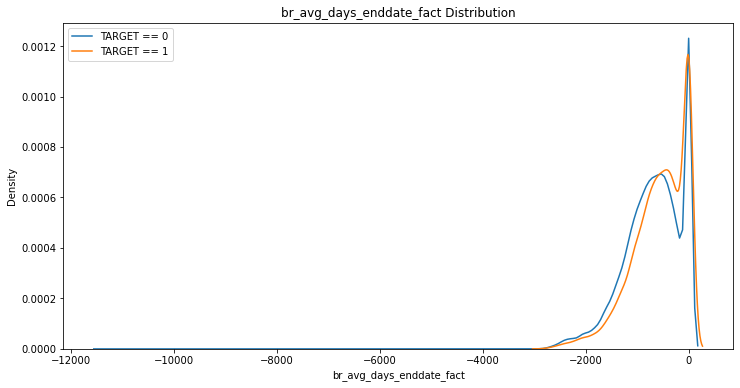

In [285]:
kde_target('br_avg_days_enddate_fact', app_train)

In [286]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_avg_days_enddate_fact  
0  52.715068               -825.500000  
1  49.490411               -123.000000  
2  54.898630              -1054.750000  
3  38.290411              -1238.285700  
4  35.726027               -867.659154  

[5 rows x 92 columns]

In [287]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [288]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [289]:
app_train['br_avg_days_enddate_fact'].isnull().sum()

0

In [290]:
app_train[['TARGET', 'br_avg_days_enddate_fact']].corr()

TARGET  br_avg_days_enddate_fact
TARGET                    1.000000                  0.091886
br_avg_days_enddate_fact  0.091886                  1.000000

In [291]:
## Yao-Johnson変換
num_cols = ['br_avg_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_avg_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_days_enddate_fact']].corr()

TARGET  br_avg_days_enddate_fact
TARGET                    1.000000                  0.092102
br_avg_days_enddate_fact  0.092102                  1.000000

In [292]:
## 標準化
num_cols = ['br_avg_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_days_enddate_fact', 'TARGET']].corr()

br_avg_days_enddate_fact    TARGET
br_avg_days_enddate_fact                  1.000000  0.092102
TARGET                                    0.092102  1.000000

The correlation between br_avg_days_enddate_fact and the TARGET is 0.0921
Median value for loan that was not repaid = 0.2464
Median value for loan that was repaid =     -0.1119


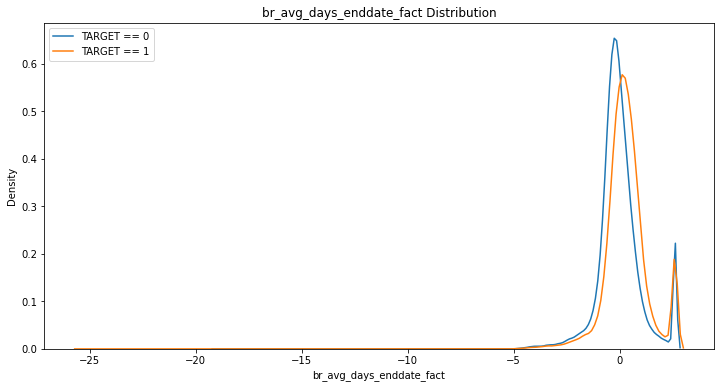

In [293]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_days_enddate_fact', app_train)

### br_cnt_days_enddate_fact

In [294]:
app_train[['TARGET', 'br_cnt_days_enddate_fact']].corr()

TARGET  br_cnt_days_enddate_fact
TARGET                    1.000000                 -0.040258
br_cnt_days_enddate_fact -0.040258                  1.000000

In [295]:
app_train['br_cnt_days_enddate_fact'].isnull().sum()

216533

The correlation between br_cnt_days_enddate_fact and the TARGET is -0.0403
Median value for loan that was not repaid = 25.0000
Median value for loan that was repaid =     39.0000


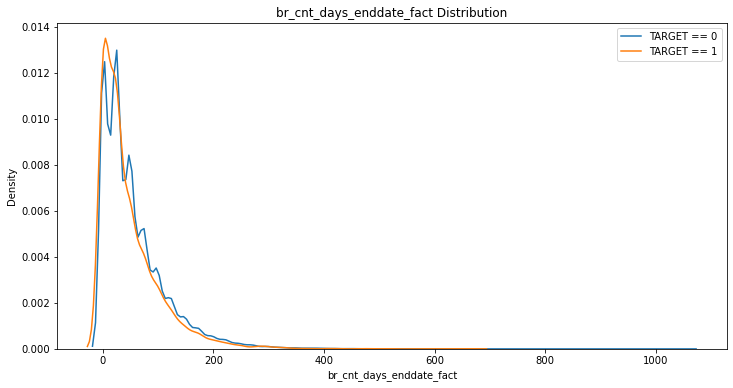

In [296]:
kde_target('br_cnt_days_enddate_fact', app_train)

In [297]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_days_enddate_fact  
0  52.715068                100.000000  
1  49.490411                 13.000000  
2  54.898630                100.000000  
3  38.290411                175.000000  
4  35.726027                 83.674179  

[5 rows x 92 columns]

In [298]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [299]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [300]:
app_train['br_cnt_days_enddate_fact'].isnull().sum()

0

In [301]:
app_train[['TARGET', 'br_cnt_days_enddate_fact']].corr()

TARGET  br_cnt_days_enddate_fact
TARGET                    1.000000                 -0.048294
br_cnt_days_enddate_fact -0.048294                  1.000000

In [302]:
## Yao-Johnson変換
num_cols = ['br_cnt_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_cnt_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_days_enddate_fact']].corr()

TARGET  br_cnt_days_enddate_fact
TARGET                    1.000000                 -0.057082
br_cnt_days_enddate_fact -0.057082                  1.000000

In [303]:
## 標準化
num_cols = ['br_cnt_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_days_enddate_fact', 'TARGET']].corr()

br_cnt_days_enddate_fact    TARGET
br_cnt_days_enddate_fact                  1.000000 -0.057082
TARGET                                   -0.057082  1.000000

The correlation between br_cnt_days_enddate_fact and the TARGET is -0.0571
Median value for loan that was not repaid = -0.1124
Median value for loan that was repaid =     0.0553


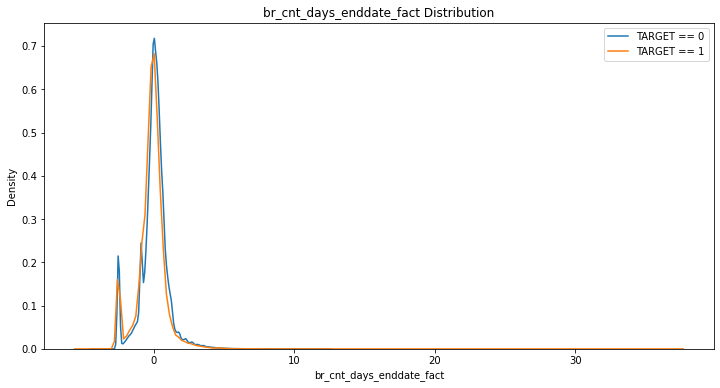

In [304]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_days_enddate_fact', app_train)

### br_stddev_days_enddate_fact

In [305]:
app_train[['TARGET', 'br_stddev_days_enddate_fact']].corr()

TARGET  br_stddev_days_enddate_fact
TARGET                       1.000000                    -0.048393
br_stddev_days_enddate_fact -0.048393                     1.000000

In [306]:
app_train['br_stddev_days_enddate_fact'].isnull().sum()

216533

The correlation between br_stddev_days_enddate_fact and the TARGET is -0.0484
Median value for loan that was not repaid = 38.5863
Median value for loan that was repaid =     131.9935


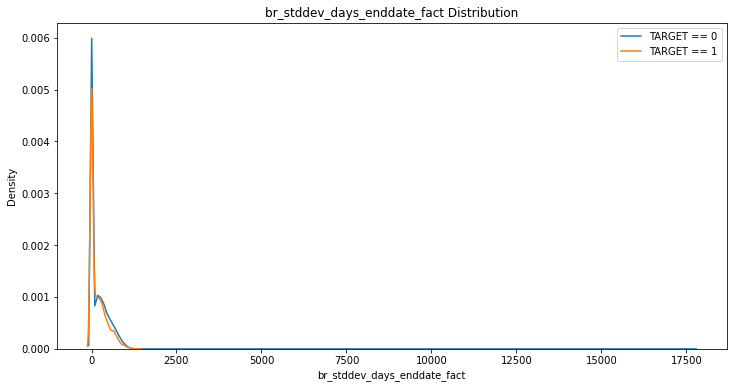

In [307]:
kde_target('br_stddev_days_enddate_fact', app_train)

In [308]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_days_enddate_fact  
0  52.715068                   319.631428  
1  49.490411                     0.000000  
2  54.898630                   301.833874  
3  38.290411                   469.812642  
4  35.726027                   317.085448  

[5 rows x 92 columns]

In [309]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [310]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [311]:
app_train['br_stddev_days_enddate_fact'].isnull().sum()

0

In [312]:
app_train[['TARGET', 'br_stddev_days_enddate_fact']].corr()

TARGET  br_stddev_days_enddate_fact
TARGET                       1.000000                    -0.061332
br_stddev_days_enddate_fact -0.061332                     1.000000

In [313]:
## Yao-Johnson変換
num_cols = ['br_stddev_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_stddev_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_days_enddate_fact']].corr()

TARGET  br_stddev_days_enddate_fact
TARGET                       1.000000                    -0.063908
br_stddev_days_enddate_fact -0.063908                     1.000000

In [314]:
## 標準化
num_cols = ['br_stddev_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_days_enddate_fact', 'TARGET']].corr()

br_stddev_days_enddate_fact    TARGET
br_stddev_days_enddate_fact                     1.000000 -0.063908
TARGET                                         -0.063908  1.000000

The correlation between br_stddev_days_enddate_fact and the TARGET is -0.0639
Median value for loan that was not repaid = -0.0733
Median value for loan that was repaid =     0.1582


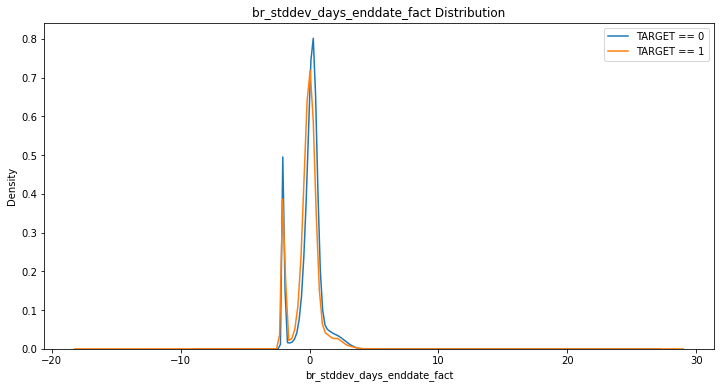

In [315]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_days_enddate_fact', app_train)

### br_stddev_pop_days_enddate_fact

In [316]:
app_train[['TARGET', 'br_stddev_pop_days_enddate_fact']].corr()

TARGET  br_stddev_pop_days_enddate_fact
TARGET                           1.000000                        -0.048393
br_stddev_pop_days_enddate_fact -0.048393                         1.000000

In [317]:
app_train['br_stddev_pop_days_enddate_fact'].isnull().sum()

216533

The correlation between br_stddev_pop_days_enddate_fact and the TARGET is -0.0484
Median value for loan that was not repaid = 38.5863
Median value for loan that was repaid =     131.9935


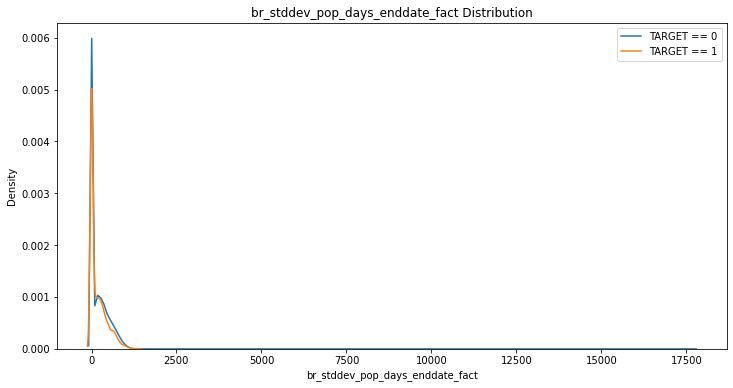

In [318]:
kde_target('br_stddev_pop_days_enddate_fact', app_train)

In [319]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_pop_days_enddate_fact  
0  52.715068                       319.631428  
1  49.490411                         0.000000  
2  54.898630                       301.833874  
3  38.290411                       469.812642  
4  35.726027                       317.085448  

[5 rows x 92 columns]

In [320]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [321]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [322]:
app_train['br_stddev_pop_days_enddate_fact'].isnull().sum()

0

In [323]:
app_train[['TARGET', 'br_stddev_pop_days_enddate_fact']].corr()

TARGET  br_stddev_pop_days_enddate_fact
TARGET                           1.000000                        -0.061332
br_stddev_pop_days_enddate_fact -0.061332                         1.000000

In [324]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_days_enddate_fact']].corr()

TARGET  br_stddev_pop_days_enddate_fact
TARGET                           1.000000                        -0.063908
br_stddev_pop_days_enddate_fact -0.063908                         1.000000

In [325]:
## 標準化
num_cols = ['br_stddev_pop_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_pop_days_enddate_fact', 'TARGET']].corr()

br_stddev_pop_days_enddate_fact    TARGET
br_stddev_pop_days_enddate_fact                         1.000000 -0.063908
TARGET                                                 -0.063908  1.000000

The correlation between br_stddev_pop_days_enddate_fact and the TARGET is -0.0639
Median value for loan that was not repaid = -0.0733
Median value for loan that was repaid =     0.1582


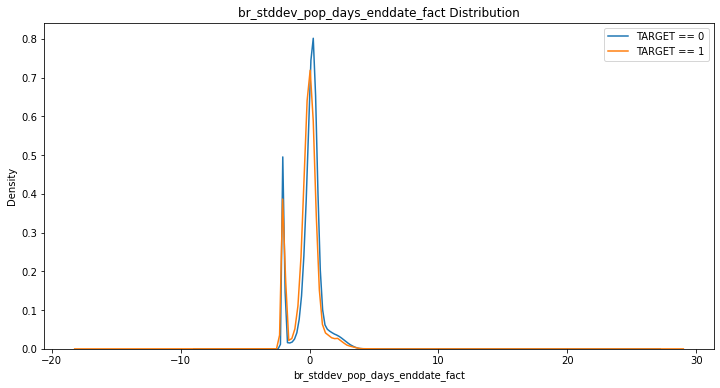

In [326]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_days_enddate_fact', app_train)

### br_var_pop_days_enddate_fact

In [327]:
app_train[['TARGET', 'br_var_pop_days_enddate_fact']].corr()

TARGET  br_var_pop_days_enddate_fact
TARGET                        1.000000                     -0.008913
br_var_pop_days_enddate_fact -0.008913                      1.000000

In [328]:
app_train['br_var_pop_days_enddate_fact'].isnull().sum()

216533

The correlation between br_var_pop_days_enddate_fact and the TARGET is -0.0089
Median value for loan that was not repaid = 1488.9420
Median value for loan that was repaid =     17422.2866


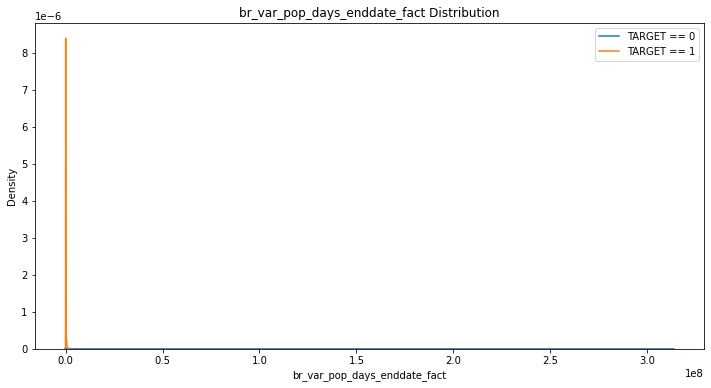

In [329]:
kde_target('br_var_pop_days_enddate_fact', app_train)

In [330]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_pop_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_pop_days_enddate_fact  
0  52.715068                 102164.250000  
1  49.490411                      0.000000  
2  54.898630                  91103.687500  
3  38.290411                 220723.918367  
4  35.726027                 191246.491781  

[5 rows x 92 columns]

In [331]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [332]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [333]:
app_train['br_var_pop_days_enddate_fact'].isnull().sum()

0

In [334]:
app_train[['TARGET', 'br_var_pop_days_enddate_fact']].corr()

TARGET  br_var_pop_days_enddate_fact
TARGET                        1.000000                     -0.009055
br_var_pop_days_enddate_fact -0.009055                      1.000000

In [335]:
## Yao-Johnson変換
num_cols = ['br_var_pop_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_days_enddate_fact']].corr()

TARGET  br_var_pop_days_enddate_fact
TARGET                        1.000000                     -0.043767
br_var_pop_days_enddate_fact -0.043767                      1.000000

In [336]:
## 標準化
num_cols = ['br_var_pop_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_pop_days_enddate_fact', 'TARGET']].corr()

br_var_pop_days_enddate_fact    TARGET
br_var_pop_days_enddate_fact                      1.000000 -0.043767
TARGET                                           -0.043767  1.000000

The correlation between br_var_pop_days_enddate_fact and the TARGET is -0.0438
Median value for loan that was not repaid = -0.0440
Median value for loan that was repaid =     0.1086


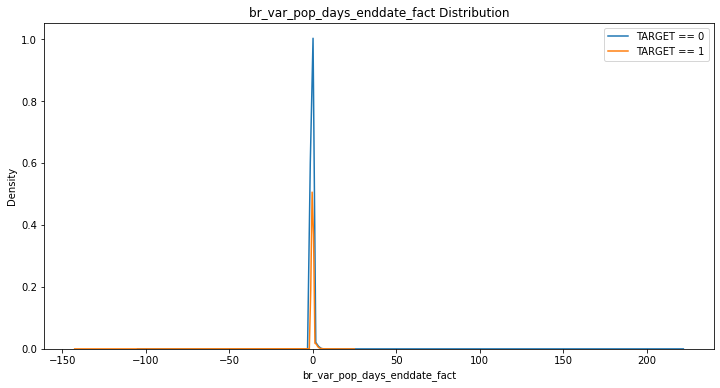

In [337]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_days_enddate_fact', app_train)

### br_var_samp_days_enddate_fact

In [338]:
app_train[['TARGET', 'br_var_samp_days_enddate_fact']].corr()

TARGET  br_var_samp_days_enddate_fact
TARGET                         1.000000                      -0.008934
br_var_samp_days_enddate_fact -0.008934                       1.000000

In [339]:
app_train['br_var_samp_days_enddate_fact'].isnull().sum()

216533

The correlation between br_var_samp_days_enddate_fact and the TARGET is -0.0089
Median value for loan that was not repaid = 1542.9302
Median value for loan that was repaid =     17914.5408


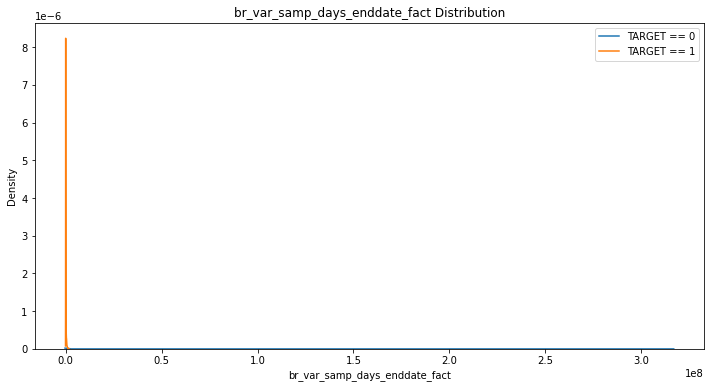

In [340]:
kde_target('br_var_samp_days_enddate_fact', app_train)

In [341]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_samp_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_samp_days_enddate_fact  
0  52.715068                  103196.212121  
1  49.490411                       0.000000  
2  54.898630                   92023.926768  
3  38.290411                  221992.446634  
4  35.726027                  193195.437264  

[5 rows x 92 columns]

In [342]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [343]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [344]:
app_train['br_var_samp_days_enddate_fact'].isnull().sum()

0

In [345]:
app_train[['TARGET', 'br_var_samp_days_enddate_fact']].corr()

TARGET  br_var_samp_days_enddate_fact
TARGET                         1.000000                      -0.009075
br_var_samp_days_enddate_fact -0.009075                       1.000000

In [346]:
## Yao-Johnson変換
num_cols = ['br_var_samp_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_days_enddate_fact']].corr()

TARGET  br_var_samp_days_enddate_fact
TARGET                         1.000000                      -0.043779
br_var_samp_days_enddate_fact -0.043779                       1.000000

In [347]:
## 標準化
num_cols = ['br_var_samp_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_samp_days_enddate_fact', 'TARGET']].corr()

br_var_samp_days_enddate_fact    TARGET
br_var_samp_days_enddate_fact                       1.000000 -0.043779
TARGET                                             -0.043779  1.000000

The correlation between br_var_samp_days_enddate_fact and the TARGET is -0.0438
Median value for loan that was not repaid = -0.0439
Median value for loan that was repaid =     0.1088


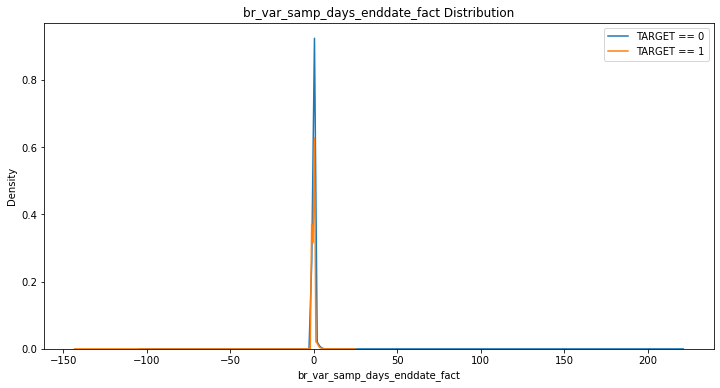

In [348]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_days_enddate_fact', app_train)

### br_variance_pop_days_enddate_fact

In [349]:
app_train[['TARGET', 'br_variance_pop_days_enddate_fact']].corr()

TARGET  br_variance_pop_days_enddate_fact
TARGET                             1.000000                          -0.008913
br_variance_pop_days_enddate_fact -0.008913                           1.000000

In [350]:
app_train['br_variance_pop_days_enddate_fact'].isnull().sum()

216533

The correlation between br_variance_pop_days_enddate_fact and the TARGET is -0.0089
Median value for loan that was not repaid = 1488.9420
Median value for loan that was repaid =     17422.2866


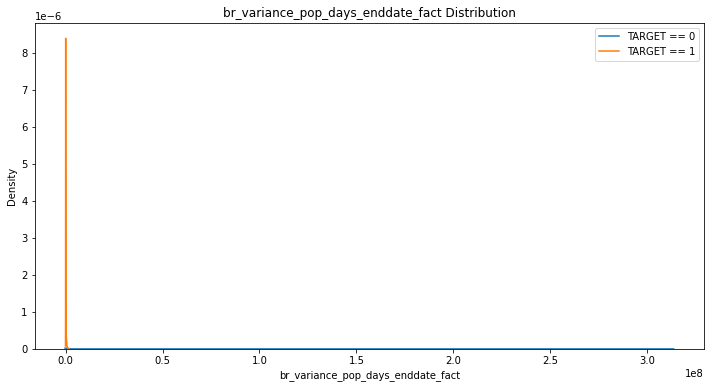

In [351]:
kde_target('br_variance_pop_days_enddate_fact', app_train)

In [352]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_variance_pop_days_enddate_fact')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_variance_pop_days_enddate_fact  
0  52.715068                      102164.250000  
1  49.490411                           0.000000  
2  54.898630                       91103.687500  
3  38.290411                      220723.918367  
4  35.726027                      191246.491781  

[5 rows x 92 columns]

In [353]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [354]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [355]:
app_train['br_variance_pop_days_enddate_fact'].isnull().sum()

0

In [356]:
app_train[['TARGET', 'br_variance_pop_days_enddate_fact']].corr()

TARGET  br_variance_pop_days_enddate_fact
TARGET                             1.000000                          -0.009055
br_variance_pop_days_enddate_fact -0.009055                           1.000000

In [357]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_days_enddate_fact'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_days_enddate_fact']].corr()

TARGET  br_variance_pop_days_enddate_fact
TARGET                             1.000000                          -0.043767
br_variance_pop_days_enddate_fact -0.043767                           1.000000

In [358]:
## 標準化
num_cols = ['br_variance_pop_days_enddate_fact']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_variance_pop_days_enddate_fact', 'TARGET']].corr()

br_variance_pop_days_enddate_fact    TARGET
br_variance_pop_days_enddate_fact                           1.000000 -0.043767
TARGET                                                     -0.043767  1.000000

The correlation between br_variance_pop_days_enddate_fact and the TARGET is -0.0438
Median value for loan that was not repaid = -0.0440
Median value for loan that was repaid =     0.1086


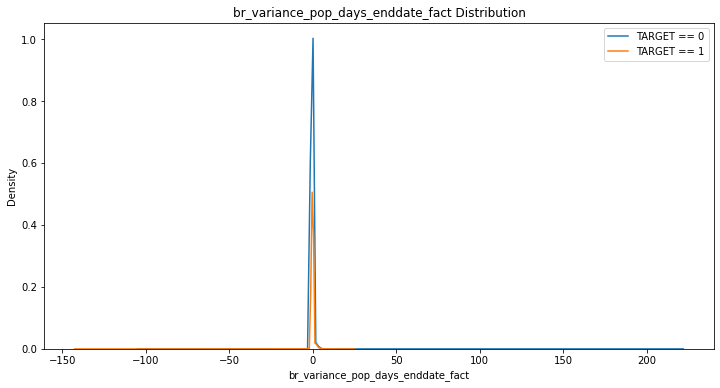

In [359]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_days_enddate_fact', app_train)

### br_min_amt_credit_max_overdue

In [360]:
app_train[['TARGET', 'br_min_amt_credit_max_overdue']].corr()

TARGET  br_min_amt_credit_max_overdue
TARGET                         1.000000                       0.002486
br_min_amt_credit_max_overdue  0.002486                       1.000000

In [361]:
app_train['br_min_amt_credit_max_overdue'].isnull().sum()

216533

The correlation between br_min_amt_credit_max_overdue and the TARGET is 0.0025
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


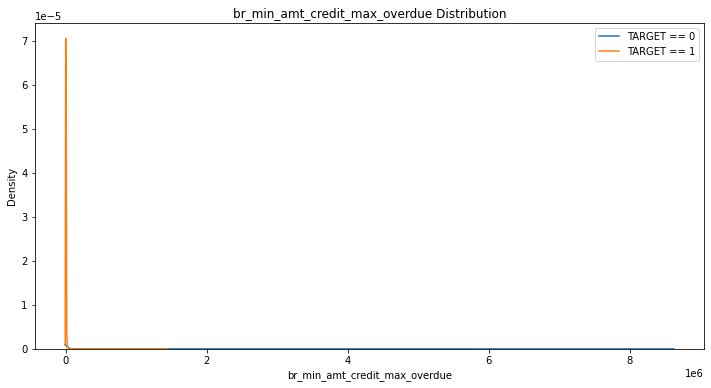

In [362]:
kde_target('br_min_amt_credit_max_overdue', app_train)

In [363]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [364]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [365]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [366]:
#app_train['br_min_amt_credit_max_overdue'].isnull().sum()

In [367]:
#app_train[['TARGET', 'br_min_amt_credit_max_overdue']].corr()

In [368]:
#num_cols = ['br_min_amt_credit_max_overdue']
# 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

# 変換後のデータで各列を置換
#app_train['br_min_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_min_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

#app_train[['TARGET', 'br_min_amt_credit_max_overdue']].corr()

In [369]:
## 標準化
#num_cols = ['br_min_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_min_amt_credit_max_overdue', 'TARGET']].corr()

In [370]:
#kde_target('br_min_amt_credit_max_overdue', app_train)

In [371]:
columns = ['br_min_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_max_amt_credit_max_overdue

In [372]:
app_train[['TARGET', 'br_max_amt_credit_max_overdue']].corr()

TARGET  br_max_amt_credit_max_overdue
TARGET                         1.000000                       0.000341
br_max_amt_credit_max_overdue  0.000341                       1.000000

In [373]:
app_train['br_max_amt_credit_max_overdue'].isnull().sum()

216533

In [374]:
#kde_target('br_max_amt_credit_max_overdue', app_train)

In [375]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_max_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [376]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [377]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [378]:
#app_train['br_max_amt_credit_max_overdue'].isnull().sum()

In [379]:
#app_train[['TARGET', 'br_max_amt_credit_max_overdue']].corr()

In [380]:
#num_cols = ['br_max_amt_credit_max_overdue']
# 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

# 変換後のデータで各列を置換
#app_train['br_max_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_max_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

#app_train[['TARGET', 'br_max_amt_credit_max_overdue']].corr()

In [381]:
## 標準化
#num_cols = ['br_max_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_max_amt_credit_max_overdue', 'TARGET']].corr()

In [382]:
#kde_target('br_max_amt_credit_max_overdue', app_train)

In [383]:
columns = ['br_max_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_sum_amt_credit_max_overdue

In [384]:
app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

TARGET  br_sum_amt_credit_max_overdue
TARGET                         1.000000                      -0.000031
br_sum_amt_credit_max_overdue -0.000031                       1.000000

In [385]:
app_train['br_sum_amt_credit_max_overdue'].isnull().sum()

216533

In [386]:
#kde_target('br_sum_amt_credit_max_overdue', app_train)

In [387]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_sum_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [388]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [389]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()


In [390]:
#app_train['br_sum_amt_credit_max_overdue'].isnull().sum()

In [391]:
#app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

In [392]:
#num_cols = ['br_sum_amt_credit_max_overdue']
# 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

# 変換後のデータで各列を置換
#app_train['br_sum_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_sum_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

#app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

In [393]:
## 標準化
#num_cols = ['br_sum_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_sum_amt_credit_max_overdue', 'TARGET']].corr()

In [394]:
#kde_target('br_sum_amt_credit_max_overdue', app_train)

In [395]:
columns = ['br_sum_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_avg_amt_credit_max_overdue

In [396]:
app_train[['TARGET', 'br_avg_amt_credit_max_overdue']].corr()

TARGET  br_avg_amt_credit_max_overdue
TARGET                         1.000000                      -0.000186
br_avg_amt_credit_max_overdue -0.000186                       1.000000

In [397]:
app_train['br_avg_amt_credit_max_overdue'].isnull().sum()

216533

The correlation between br_avg_amt_credit_max_overdue and the TARGET is -0.0002
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


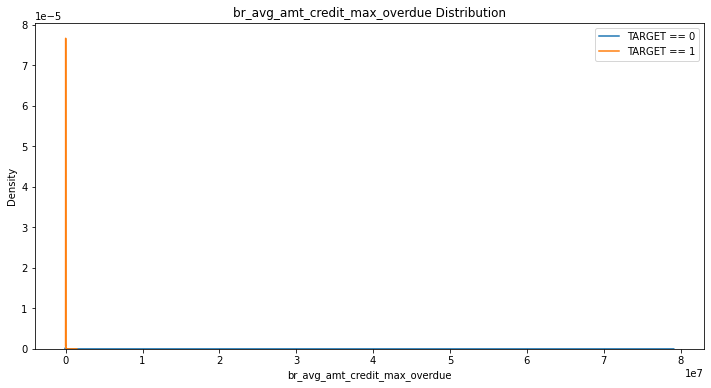

In [398]:
kde_target('br_avg_amt_credit_max_overdue', app_train)

In [399]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_amt_credit_max_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_avg_amt_credit_max_overdue  
0  52.715068                       0.000000  
1  49.490411                       0.000000  
2  54.898630                   19305.000000  
3  38.290411                       0.000000  
4  35.726027                    2955.475011  

[5 rows x 92 columns]

In [400]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [401]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [402]:
app_train['br_avg_amt_credit_max_overdue'].isnull().sum()

0

In [403]:
app_train[['TARGET', 'br_avg_amt_credit_max_overdue']].corr()

TARGET  br_avg_amt_credit_max_overdue
TARGET                         1.000000                      -0.000201
br_avg_amt_credit_max_overdue -0.000201                       1.000000

In [404]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_max_overdue']].corr()

TARGET  br_avg_amt_credit_max_overdue
TARGET                         1.000000                       0.010348
br_avg_amt_credit_max_overdue  0.010348                       1.000000

In [405]:
## 標準化
num_cols = ['br_avg_amt_credit_max_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_amt_credit_max_overdue', 'TARGET']].corr()

br_avg_amt_credit_max_overdue    TARGET
br_avg_amt_credit_max_overdue                       1.000000  0.010348
TARGET                                              0.010348  1.000000

The correlation between br_avg_amt_credit_max_overdue and the TARGET is 0.0103
Median value for loan that was not repaid = 0.3735
Median value for loan that was repaid =     0.3573


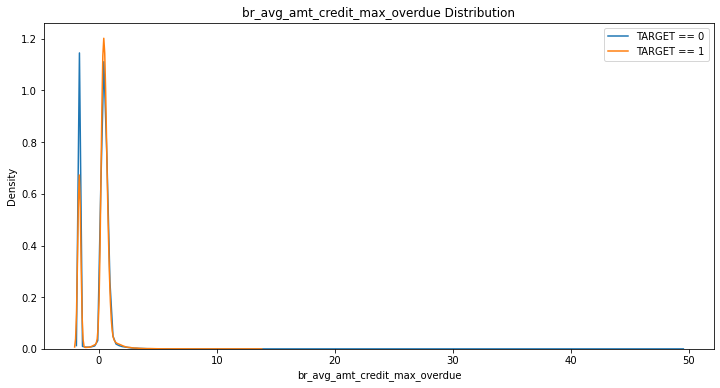

In [406]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_max_overdue', app_train)

### br_cnt_amt_credit_max_overdue

In [407]:
app_train[['TARGET', 'br_cnt_amt_credit_max_overdue']].corr()

TARGET  br_cnt_amt_credit_max_overdue
TARGET                         1.000000                      -0.007219
br_cnt_amt_credit_max_overdue -0.007219                       1.000000

In [408]:
app_train['br_cnt_amt_credit_max_overdue'].isnull().sum()

216533

The correlation between br_cnt_amt_credit_max_overdue and the TARGET is -0.0072
Median value for loan that was not repaid = 13.0000
Median value for loan that was repaid =     15.0000


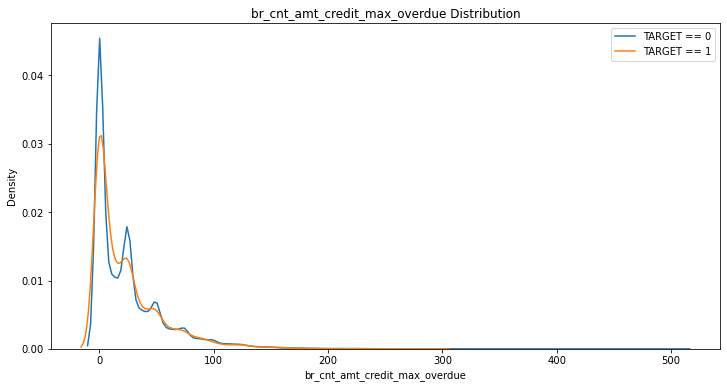

In [409]:
kde_target('br_cnt_amt_credit_max_overdue', app_train)

In [410]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_cnt_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [411]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [412]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [413]:
#app_train['br_cnt_amt_credit_max_overdue'].isnull().sum()

In [414]:
#app_train[['TARGET', 'br_cnt_amt_credit_max_overdue']].corr()

In [415]:
## Yao-Johnson変換
#num_cols = ['br_cnt_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_cnt_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_cnt_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_cnt_amt_credit_max_overdue']].corr()

In [416]:
## 標準化
#num_cols = ['br_cnt_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_cnt_amt_credit_max_overdue', 'TARGET']].corr()

In [417]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_cnt_amt_credit_max_overdue', app_train)

In [418]:
columns = ['br_cnt_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_stddev_amt_credit_max_overdue

In [419]:
app_train[['TARGET', 'br_stddev_amt_credit_max_overdue']].corr()

TARGET  br_stddev_amt_credit_max_overdue
TARGET                            1.000000                          0.000122
br_stddev_amt_credit_max_overdue  0.000122                          1.000000

In [420]:
app_train['br_stddev_amt_credit_max_overdue'].isnull().sum()

216533

The correlation between br_stddev_amt_credit_max_overdue and the TARGET is 0.0001
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


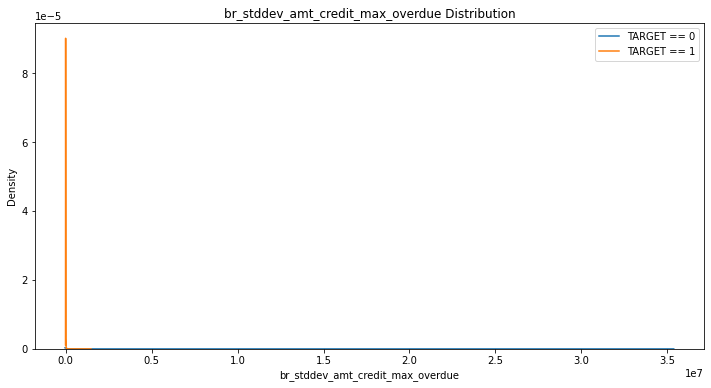

In [421]:
kde_target('br_stddev_amt_credit_max_overdue', app_train)

In [422]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [423]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [424]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [425]:
#app_train['br_stddev_amt_credit_max_overdue'].isnull().sum()

In [426]:
#app_train[['TARGET', 'br_stddev_amt_credit_max_overdue']].corr()

In [427]:
## Yao-Johnson変換
#num_cols = ['br_stddev_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_amt_credit_max_overdue']].corr()

In [428]:
## 標準化
#num_cols = ['br_stddev_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_amt_credit_max_overdue', 'TARGET']].corr()

In [429]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_amt_credit_max_overdue', app_train)

In [430]:
columns = ['br_stddev_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_stddev_pop_amt_credit_max_overdue

In [431]:
app_train[['TARGET', 'br_stddev_pop_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                                1.000000   
br_stddev_pop_amt_credit_max_overdue  0.000122   

                                      br_stddev_pop_amt_credit_max_overdue  
TARGET                                                            0.000122  
br_stddev_pop_amt_credit_max_overdue                              1.000000

In [432]:
app_train['br_stddev_pop_amt_credit_max_overdue'].isnull().sum()

216533

The correlation between br_stddev_pop_amt_credit_max_overdue and the TARGET is 0.0001
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


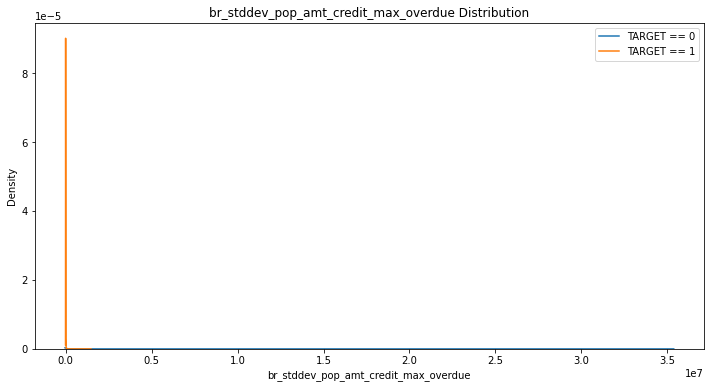

In [433]:
kde_target('br_stddev_pop_amt_credit_max_overdue', app_train)

In [434]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_pop_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [435]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [436]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [437]:
#app_train['br_stddev_pop_amt_credit_max_overdue'].isnull().sum()

In [438]:
#app_train[['TARGET', 'br_stddev_pop_amt_credit_max_overdue']].corr()

In [439]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [440]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_amt_credit_max_overdue']].corr()

In [441]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_pop_amt_credit_max_overdue', app_train)

In [442]:
columns = ['br_stddev_pop_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_pop_amt_credit_max_overdue

In [443]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_max_overdue']].corr()

TARGET  br_var_pop_amt_credit_max_overdue
TARGET                             1.000000                          -0.000977
br_var_pop_amt_credit_max_overdue -0.000977                           1.000000

In [444]:
app_train['br_var_pop_amt_credit_max_overdue'].isnull().sum()

216533

The correlation between br_var_pop_amt_credit_max_overdue and the TARGET is -0.0010
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


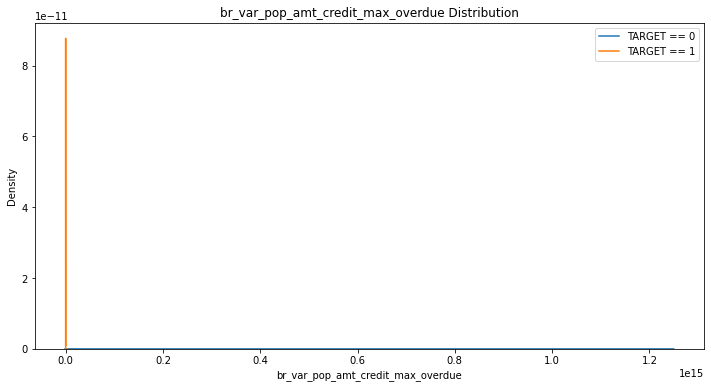

In [445]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_max_overdue', app_train)

In [446]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_pop_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [447]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [448]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [449]:
#app_train['br_var_pop_amt_credit_max_overdue'].isnull().sum()

In [450]:
#app_train[['TARGET', 'br_var_pop_amt_credit_max_overdue']].corr()

In [451]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_pop_amt_credit_max_overdue']].corr()

In [452]:
## 標準化
#num_cols = ['br_var_pop_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_pop_amt_credit_max_overdue', 'TARGET']].corr()

In [453]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_pop_amt_credit_max_overdue', app_train)

In [454]:
columns = ['br_var_pop_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_samp_amt_credit_max_overdue

In [455]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_var_samp_amt_credit_max_overdue -0.000977   

                                    br_var_samp_amt_credit_max_overdue  
TARGET                                                       -0.000977  
br_var_samp_amt_credit_max_overdue                            1.000000

In [456]:
app_train['br_var_samp_amt_credit_max_overdue'].isnull().sum()

216533

The correlation between br_var_samp_amt_credit_max_overdue and the TARGET is -0.0010
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


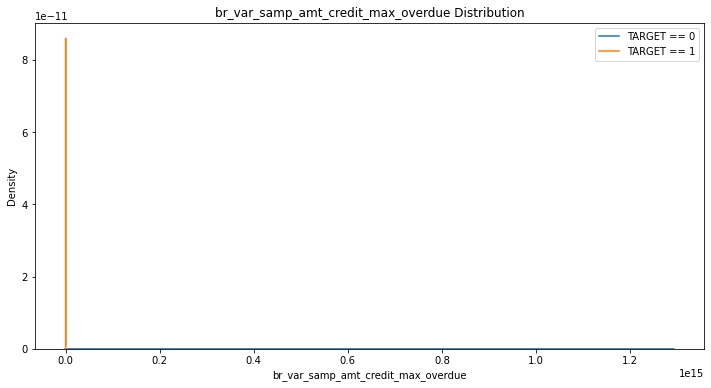

In [457]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_max_overdue', app_train)

In [458]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_samp_amt_credit_max_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [459]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [460]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [461]:
#app_train['br_var_samp_amt_credit_max_overdue'].isnull().sum()

In [462]:
#app_train[['TARGET', 'br_var_samp_amt_credit_max_overdue']].corr()

In [463]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_amt_credit_max_overdue']].corr()

In [464]:
## 標準化
#num_cols = ['br_var_samp_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_samp_amt_credit_max_overdue', 'TARGET']].corr()

In [465]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_amt_credit_max_overdue', app_train)

In [466]:
columns = ['br_var_samp_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_variance_pop_amt_credit_max_overdue

In [467]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                                  1.000000   
br_variance_pop_amt_credit_max_overdue -0.000977   

                                        br_variance_pop_amt_credit_max_overdue  
TARGET                                                               -0.000977  
br_variance_pop_amt_credit_max_overdue                                1.000000

In [468]:
app_train['br_variance_pop_amt_credit_max_overdue'].isnull().sum()

216533

The correlation between br_variance_pop_amt_credit_max_overdue and the TARGET is -0.0010
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


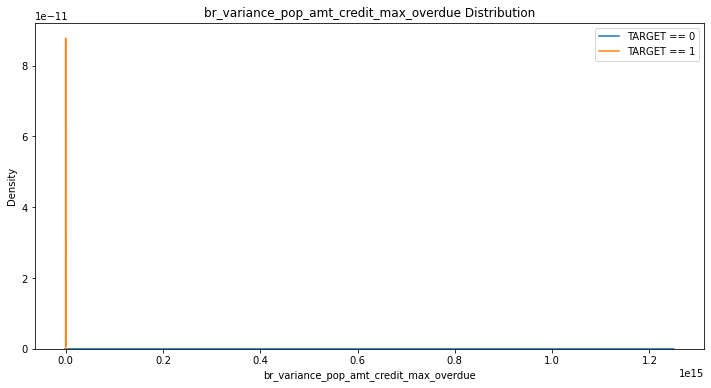

In [469]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_max_overdue', app_train)

In [470]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_credit_day_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [471]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [472]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [473]:
#app_train['br_variance_pop_amt_credit_max_overdue'].isnull().sum()

In [474]:
#app_train[['TARGET', 'br_variance_pop_amt_credit_max_overdue']].corr()

In [475]:
## Yao-Johnson変換
#num_cols = ['br_variance_pop_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_variance_pop_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_variance_pop_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_variance_pop_amt_credit_max_overdue']].corr()

In [476]:
## 標準化
#num_cols = ['br_variance_pop_amt_credit_max_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_variance_pop_amt_credit_max_overdue', 'TARGET']].corr()

In [477]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_variance_pop_amt_credit_max_overdue', app_train)

In [478]:
columns = ['br_variance_pop_amt_credit_max_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_min_cnt_credit_prolong

In [479]:
app_train[['TARGET', 'br_min_cnt_credit_prolong']].corr()

TARGET  br_min_cnt_credit_prolong
TARGET                     1.000000                   0.005432
br_min_cnt_credit_prolong  0.005432                   1.000000

In [480]:
app_train['br_min_cnt_credit_prolong'].isnull().sum()

216533

The correlation between br_min_cnt_credit_prolong and the TARGET is 0.0054
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


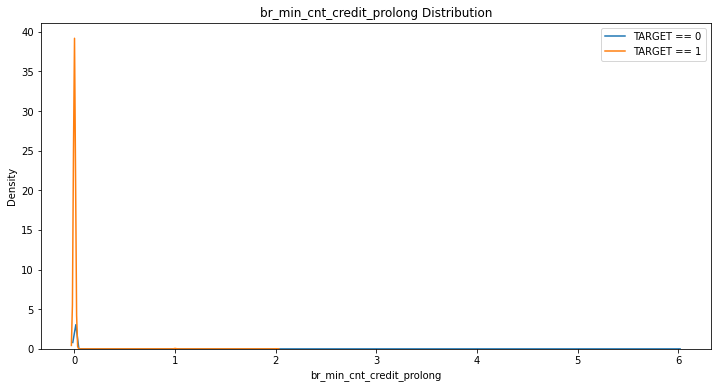

In [481]:
kde_target('br_min_cnt_credit_prolong', app_train)

In [482]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_min_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_min_cnt_credit_prolong  
0  52.715068                   0.000000  
1  49.490411                   0.000000  
2  54.898630                   0.000000  
3  38.290411                   0.000000  
4  35.726027                   0.000589  

[5 rows x 92 columns]

In [483]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [484]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [485]:
app_train['br_min_cnt_credit_prolong'].isnull().sum()

0

In [486]:
app_train[['TARGET', 'br_min_cnt_credit_prolong']].corr()

TARGET  br_min_cnt_credit_prolong
TARGET                     1.000000                   0.004924
br_min_cnt_credit_prolong  0.004924                   1.000000

In [487]:
## Yao-Johnson変換
num_cols = ['br_min_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_min_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_cnt_credit_prolong']].corr()

TARGET  br_min_cnt_credit_prolong
TARGET                     1.000000                   0.026381
br_min_cnt_credit_prolong  0.026381                   1.000000

In [488]:
## 標準化
num_cols = ['br_min_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_min_cnt_credit_prolong', 'TARGET']].corr()

br_min_cnt_credit_prolong    TARGET
br_min_cnt_credit_prolong                   1.000000  0.026381
TARGET                                      0.026381  1.000000

The correlation between br_min_cnt_credit_prolong and the TARGET is 0.0264
Median value for loan that was not repaid = 0.0649
Median value for loan that was repaid =     -0.0788


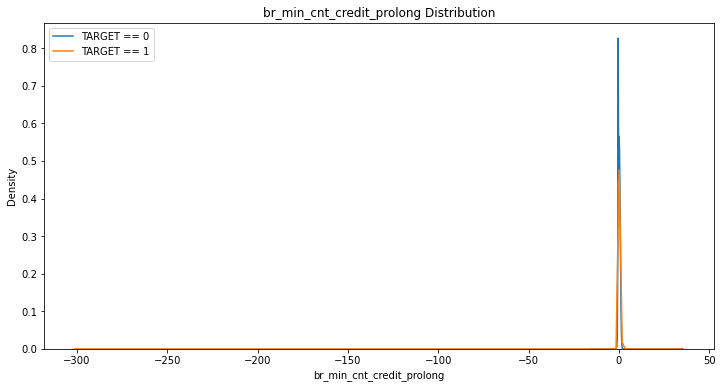

In [489]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_cnt_credit_prolong', app_train)

### br_max_cnt_credit_prolong

In [490]:
## 目的変数との相関
app_train[['TARGET', 'br_max_cnt_credit_prolong']].corr()

TARGET  br_max_cnt_credit_prolong
TARGET                     1.000000                   0.007751
br_max_cnt_credit_prolong  0.007751                   1.000000

In [491]:
app_train['br_max_cnt_credit_prolong'].isnull().sum()

216533

The correlation between br_max_cnt_credit_prolong and the TARGET is 0.0078
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


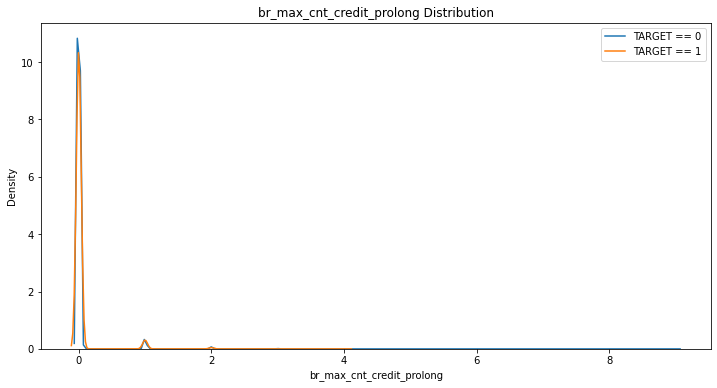

In [492]:
## 特徴量の分布
kde_target('br_max_cnt_credit_prolong', app_train)

In [493]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_max_cnt_credit_prolong')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [494]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [495]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [496]:
#app_train['br_max_cnt_credit_prolong'].isnull().sum()

In [497]:
#app_train[['TARGET', 'br_max_cnt_credit_prolong']].corr()

In [498]:
## Yao-Johnson変換
#num_cols = ['br_max_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
#app_test['br_max_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_cnt_credit_prolong']].corr()

In [499]:
## 標準化
#num_cols = ['br_max_cnt_credit_prolong']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_max_cnt_credit_prolong', 'TARGET']].corr()

In [500]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_cnt_credit_prolong', app_train)

### br_sum_cnt_credit_prolong

In [501]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_cnt_credit_prolong']].corr()

TARGET  br_sum_cnt_credit_prolong
TARGET                     1.00000                    0.00405
br_sum_cnt_credit_prolong  0.00405                    1.00000

In [502]:
app_train['br_sum_cnt_credit_prolong'].isnull().sum()

216533

The correlation between br_sum_cnt_credit_prolong and the TARGET is 0.0041
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


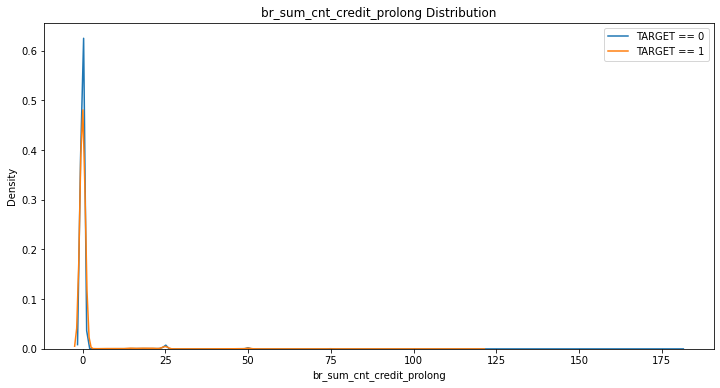

In [503]:
## 特徴量の分布
kde_target('br_sum_cnt_credit_prolong', app_train)

In [504]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_sum_cnt_credit_prolong')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [505]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [506]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [507]:
#app_train['br_sum_cnt_credit_prolong'].isnull().sum()

In [508]:
#app_train[['TARGET', 'br_sum_cnt_credit_prolong']].corr()

In [509]:
## Yao-Johnson変換
#num_cols = ['br_sum_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_sum_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
#app_test['br_sum_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_sum_cnt_credit_prolong']].corr()

In [510]:
## 標準化
#num_cols = ['br_sum_cnt_credit_prolong']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_sum_cnt_credit_prolong', 'TARGET']].corr()

In [511]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_sum_cnt_credit_prolong', app_train)

In [512]:
columns = ['br_sum_cnt_credit_prolong']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_avg_cnt_credit_prolong

In [513]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_cnt_credit_prolong']].corr()

TARGET  br_avg_cnt_credit_prolong
TARGET                     1.0000                     0.0091
br_avg_cnt_credit_prolong  0.0091                     1.0000

In [514]:
app_train['br_avg_cnt_credit_prolong'].isnull().sum()

216533

The correlation between br_avg_cnt_credit_prolong and the TARGET is 0.0091
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


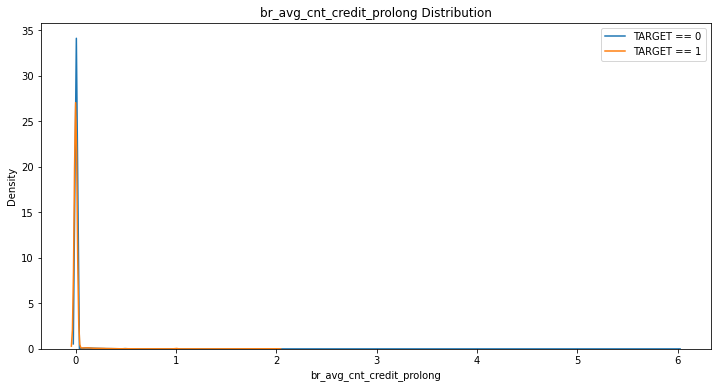

In [515]:
## 特徴量の分布
kde_target('br_avg_cnt_credit_prolong', app_train)

In [516]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()


SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_avg_cnt_credit_prolong  
0  52.715068                    0.00000  
1  49.490411                    0.00000  
2  54.898630                    0.00000  
3  38.290411                    0.00000  
4  35.726027                    0.00225  

[5 rows x 92 columns]

In [517]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [518]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [519]:
app_train['br_avg_cnt_credit_prolong'].isnull().sum()

0

In [520]:
app_train[['TARGET', 'br_avg_cnt_credit_prolong']].corr()

TARGET  br_avg_cnt_credit_prolong
TARGET                     1.000000                   0.008747
br_avg_cnt_credit_prolong  0.008747                   1.000000

In [521]:
## Yao-Johnson変換
num_cols = ['br_avg_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_avg_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_cnt_credit_prolong']].corr()

TARGET  br_avg_cnt_credit_prolong
TARGET                     1.000000                   0.029422
br_avg_cnt_credit_prolong  0.029422                   1.000000

In [522]:
## 標準化
num_cols = ['br_avg_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_cnt_credit_prolong', 'TARGET']].corr()

br_avg_cnt_credit_prolong    TARGET
br_avg_cnt_credit_prolong                   1.000000  0.029422
TARGET                                      0.029422  1.000000

The correlation between br_avg_cnt_credit_prolong and the TARGET is 0.0294
Median value for loan that was not repaid = 0.4495
Median value for loan that was repaid =     0.2500


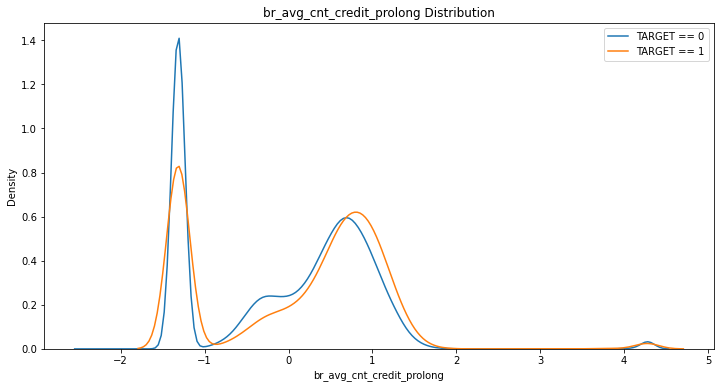

In [523]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_cnt_credit_prolong', app_train)

### br_cnt_cnt_credit_prolong

In [524]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_cnt_credit_prolong']].corr()

TARGET  br_cnt_cnt_credit_prolong
TARGET                     1.000000                  -0.024241
br_cnt_cnt_credit_prolong -0.024241                   1.000000

In [525]:
app_train['br_cnt_cnt_credit_prolong'].isnull().sum()

216533

The correlation between br_cnt_cnt_credit_prolong and the TARGET is -0.0242
Median value for loan that was not repaid = 55.0000
Median value for loan that was repaid =     63.0000


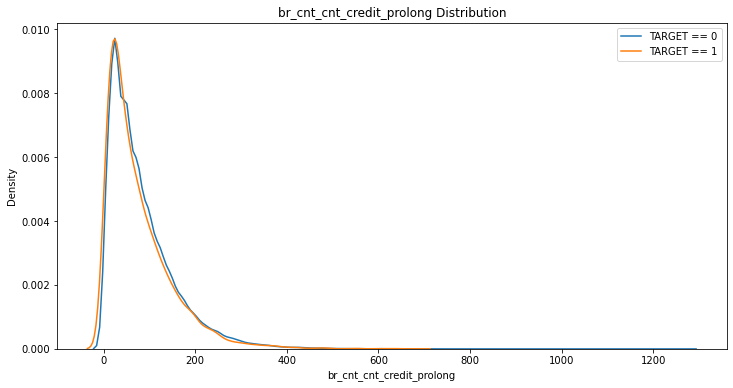

In [526]:
## 特徴量の分布
kde_target('br_cnt_cnt_credit_prolong', app_train)

In [527]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_cnt_credit_prolong  
0  52.715068                 132.000000  
1  49.490411                  21.000000  
2  54.898630                 100.000000  
3  38.290411                 270.000000  
4  35.726027                 117.972317  

[5 rows x 92 columns]

In [528]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [529]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [530]:
app_train['br_cnt_cnt_credit_prolong'].isnull().sum()

0

In [531]:
app_train[['TARGET', 'br_cnt_cnt_credit_prolong']].corr()

TARGET  br_cnt_cnt_credit_prolong
TARGET                     1.000000                  -0.027994
br_cnt_cnt_credit_prolong -0.027994                   1.000000

In [532]:
## Yao-Johnson変換
num_cols = ['br_cnt_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_cnt_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_cnt_credit_prolong']].corr()

TARGET  br_cnt_cnt_credit_prolong
TARGET                     1.000000                  -0.037745
br_cnt_cnt_credit_prolong -0.037745                   1.000000

In [533]:
## 標準化
num_cols = ['br_cnt_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_cnt_credit_prolong', 'TARGET']].corr()

br_cnt_cnt_credit_prolong    TARGET
br_cnt_cnt_credit_prolong                   1.000000 -0.037745
TARGET                                     -0.037745  1.000000

The correlation between br_cnt_cnt_credit_prolong and the TARGET is -0.0377
Median value for loan that was not repaid = -0.0742
Median value for loan that was repaid =     0.0408


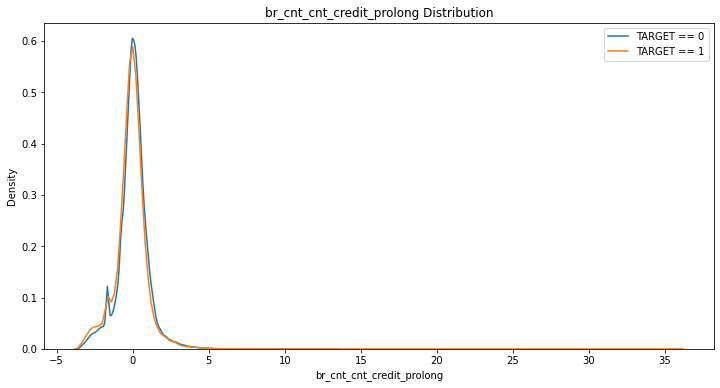

In [534]:
## 特徴量の分布
kde_target('br_cnt_cnt_credit_prolong', app_train)

### br_stddev_cnt_credit_prolong

In [535]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_cnt_credit_prolong']].corr()

TARGET  br_stddev_cnt_credit_prolong
TARGET                        1.000000                      0.006857
br_stddev_cnt_credit_prolong  0.006857                      1.000000

In [536]:
app_train['br_stddev_cnt_credit_prolong'].isnull().sum()

216533

The correlation between br_stddev_cnt_credit_prolong and the TARGET is 0.0069
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


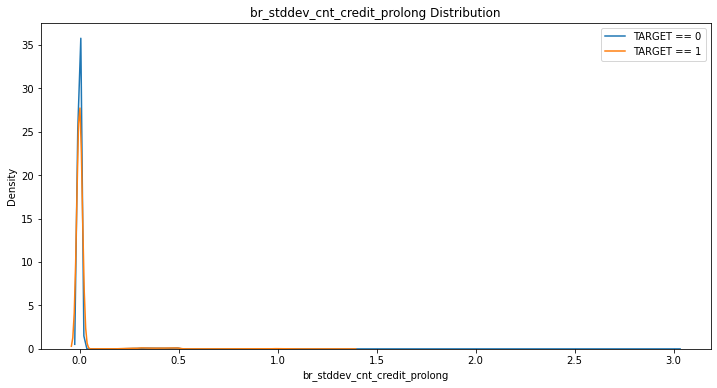

In [537]:
## 特徴量の分布
kde_target('br_stddev_cnt_credit_prolong', app_train)

In [538]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_cnt_credit_prolong')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [539]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [540]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [541]:
#app_train['br_stddev_cnt_credit_prolong'].isnull().sum()

In [542]:
#app_train[['TARGET', 'br_stddev_cnt_credit_prolong']].corr()

In [543]:
## Yao-Johnson変換
#num_cols = ['br_stddev_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_cnt_credit_prolong']].corr()

In [544]:
## 標準化
#num_cols = ['br_stddev_cnt_credit_prolong']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_cnt_credit_prolong', 'TARGET']].corr()

In [545]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_cnt_credit_prolong', app_train)

In [546]:
columns = ['br_stddev_cnt_credit_prolong']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_stddev_pop_cnt_credit_prolong

In [547]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_cnt_credit_prolong']].corr()

TARGET  br_stddev_pop_cnt_credit_prolong
TARGET                            1.000000                          0.006857
br_stddev_pop_cnt_credit_prolong  0.006857                          1.000000

In [548]:
app_train['br_stddev_pop_cnt_credit_prolong'].isnull().sum()

216533

The correlation between br_stddev_pop_cnt_credit_prolong and the TARGET is 0.0069
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


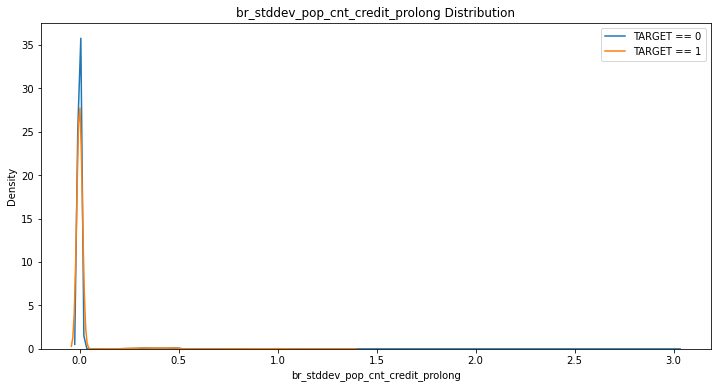

In [549]:
## 特徴量の分布
kde_target('br_stddev_pop_cnt_credit_prolong', app_train)

In [550]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_pop_cnt_credit_prolong  
0  52.715068                          0.000000  
1  49.490411                          0.000000  
2  54.898630                          0.000000  
3  38.290411                          0.000000  
4  35.726027                          0.003064  

[5 rows x 92 columns]

In [551]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [552]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [553]:
app_train['br_stddev_pop_cnt_credit_prolong'].isnull().sum()

0

In [554]:
app_train[['TARGET', 'br_stddev_pop_cnt_credit_prolong']].corr()

TARGET  br_stddev_pop_cnt_credit_prolong
TARGET                            1.000000                          0.006102
br_stddev_pop_cnt_credit_prolong  0.006102                          1.000000

In [555]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_cnt_credit_prolong']].corr()

TARGET  br_stddev_pop_cnt_credit_prolong
TARGET                            1.000000                          0.013115
br_stddev_pop_cnt_credit_prolong  0.013115                          1.000000

In [556]:
## 標準化
num_cols = ['br_stddev_pop_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_pop_cnt_credit_prolong', 'TARGET']].corr()

br_stddev_pop_cnt_credit_prolong    TARGET
br_stddev_pop_cnt_credit_prolong                          1.000000  0.013115
TARGET                                                    0.013115  1.000000

The correlation between br_stddev_pop_cnt_credit_prolong and the TARGET is 0.0131
Median value for loan that was not repaid = 0.4291
Median value for loan that was repaid =     0.3322


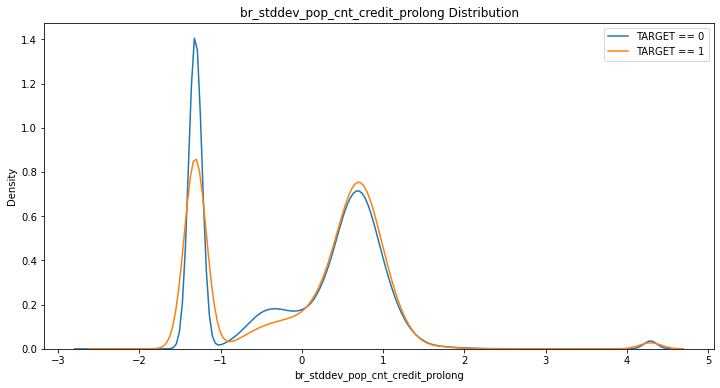

In [557]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_cnt_credit_prolong', app_train)

### br_var_pop_cnt_credit_prolong

In [558]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_cnt_credit_prolong']].corr()

TARGET  br_var_pop_cnt_credit_prolong
TARGET                         1.000000                       0.002124
br_var_pop_cnt_credit_prolong  0.002124                       1.000000

In [559]:
app_train['br_var_pop_cnt_credit_prolong'].isnull().sum()

216533

The correlation between br_var_pop_cnt_credit_prolong and the TARGET is 0.0021
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


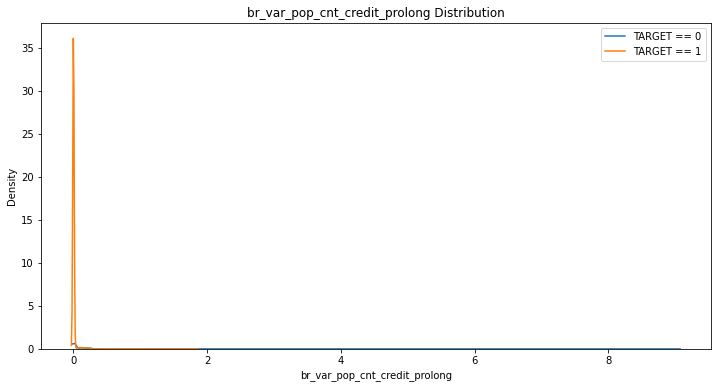

In [560]:
## 特徴量の分布
kde_target('br_var_pop_cnt_credit_prolong', app_train)

In [561]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_pop_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_pop_cnt_credit_prolong  
0  52.715068                       0.000000  
1  49.490411                       0.000000  
2  54.898630                       0.000000  
3  38.290411                       0.000000  
4  35.726027                       0.001418  

[5 rows x 92 columns]

In [562]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [563]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [564]:
app_train['br_var_pop_cnt_credit_prolong'].isnull().sum()

0

In [565]:
app_train[['TARGET', 'br_var_pop_cnt_credit_prolong']].corr()

TARGET  br_var_pop_cnt_credit_prolong
TARGET                         1.000000                       0.002794
br_var_pop_cnt_credit_prolong  0.002794                       1.000000

In [566]:
## Yao-Johnson変換
num_cols = ['br_var_pop_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_cnt_credit_prolong']].corr()

TARGET  br_var_pop_cnt_credit_prolong
TARGET                         1.000000                       0.015269
br_var_pop_cnt_credit_prolong  0.015269                       1.000000

In [567]:
## 標準化
num_cols = ['br_var_pop_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_pop_cnt_credit_prolong', 'TARGET']].corr()

br_var_pop_cnt_credit_prolong    TARGET
br_var_pop_cnt_credit_prolong                       1.000000  0.015269
TARGET                                              0.015269  1.000000

The correlation between br_var_pop_cnt_credit_prolong and the TARGET is 0.0153
Median value for loan that was not repaid = 0.4272
Median value for loan that was repaid =     0.3330


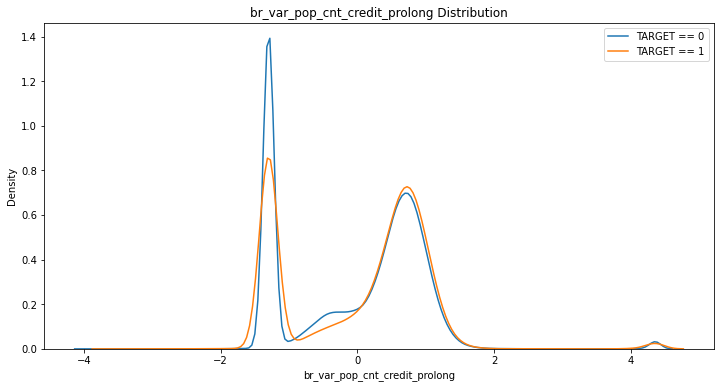

In [568]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_cnt_credit_prolong', app_train)

### br_var_samp_cnt_credit_prolong

In [569]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_cnt_credit_prolong']].corr()

TARGET  br_var_samp_cnt_credit_prolong
TARGET                          1.000000                        0.002207
br_var_samp_cnt_credit_prolong  0.002207                        1.000000

In [570]:
app_train['br_var_samp_cnt_credit_prolong'].isnull().sum()

216533

The correlation between br_var_samp_cnt_credit_prolong and the TARGET is 0.0022
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


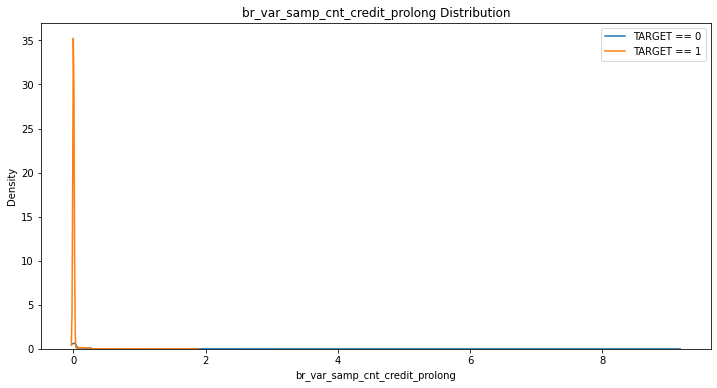

In [571]:
## 特徴量の分布
kde_target('br_var_samp_cnt_credit_prolong', app_train)

In [572]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_samp_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_samp_cnt_credit_prolong  
0  52.715068                        0.000000  
1  49.490411                        0.000000  
2  54.898630                        0.000000  
3  38.290411                        0.000000  
4  35.726027                        0.001438  

[5 rows x 92 columns]

In [573]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [574]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [575]:
app_train['br_var_samp_cnt_credit_prolong'].isnull().sum()

0

In [576]:
app_train[['TARGET', 'br_var_samp_cnt_credit_prolong']].corr()

TARGET  br_var_samp_cnt_credit_prolong
TARGET                          1.000000                        0.002871
br_var_samp_cnt_credit_prolong  0.002871                        1.000000

In [577]:
## Yao-Johnson変換
num_cols = ['br_var_samp_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_cnt_credit_prolong']].corr()

TARGET  br_var_samp_cnt_credit_prolong
TARGET                          1.000000                        0.015572
br_var_samp_cnt_credit_prolong  0.015572                        1.000000

In [578]:
## 標準化
num_cols = ['br_var_samp_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_samp_cnt_credit_prolong', 'TARGET']].corr()

br_var_samp_cnt_credit_prolong    TARGET
br_var_samp_cnt_credit_prolong                        1.000000  0.015572
TARGET                                                0.015572  1.000000

The correlation between br_var_samp_cnt_credit_prolong and the TARGET is 0.0156
Median value for loan that was not repaid = 0.4304
Median value for loan that was repaid =     0.3349


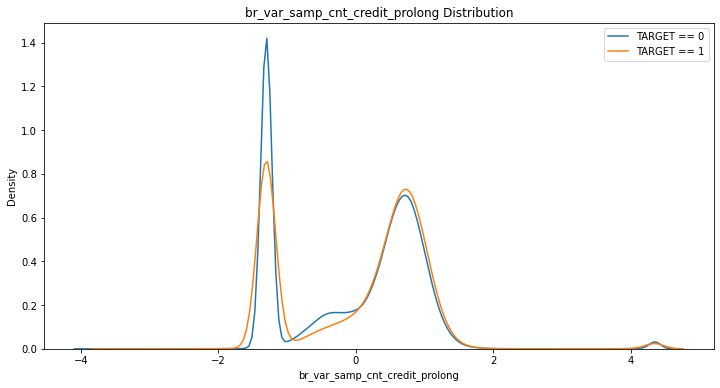

In [579]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_cnt_credit_prolong', app_train)

### br_variance_pop_cnt_credit_prolong

In [580]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_cnt_credit_prolong']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_cnt_credit_prolong  0.002124   

                                    br_variance_pop_cnt_credit_prolong  
TARGET                                                        0.002124  
br_variance_pop_cnt_credit_prolong                            1.000000

In [581]:
app_train['br_variance_pop_cnt_credit_prolong'].isnull().sum()

216533

The correlation between br_variance_pop_cnt_credit_prolong and the TARGET is 0.0021
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


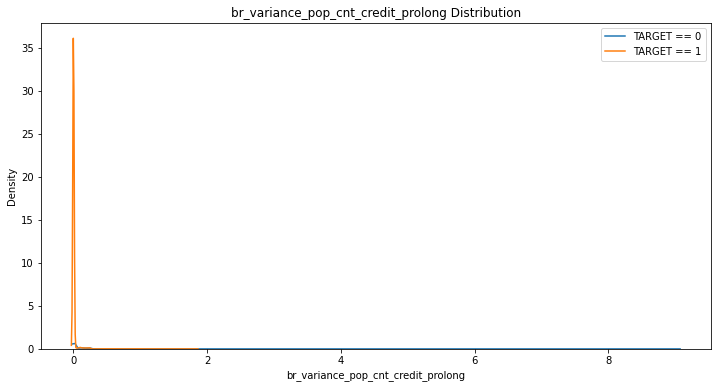

In [582]:
## 特徴量の分布
kde_target('br_variance_pop_cnt_credit_prolong', app_train)

In [583]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_variance_pop_cnt_credit_prolong')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_variance_pop_cnt_credit_prolong  
0  52.715068                            0.000000  
1  49.490411                            0.000000  
2  54.898630                            0.000000  
3  38.290411                            0.000000  
4  35.726027                            0.001418  

[5 rows x 92 columns]

In [584]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [585]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [586]:
app_train['br_variance_pop_cnt_credit_prolong'].isnull().sum()

0

In [587]:
app_train[['TARGET', 'br_variance_pop_cnt_credit_prolong']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_cnt_credit_prolong  0.002794   

                                    br_variance_pop_cnt_credit_prolong  
TARGET                                                        0.002794  
br_variance_pop_cnt_credit_prolong                            1.000000

In [588]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_cnt_credit_prolong']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_cnt_credit_prolong  0.015269   

                                    br_variance_pop_cnt_credit_prolong  
TARGET                                                        0.015269  
br_variance_pop_cnt_credit_prolong                            1.000000

In [589]:
## 標準化
num_cols = ['br_variance_pop_cnt_credit_prolong']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_variance_pop_cnt_credit_prolong', 'TARGET']].corr()

br_variance_pop_cnt_credit_prolong  \
br_variance_pop_cnt_credit_prolong                            1.000000   
TARGET                                                        0.015269   

                                      TARGET  
br_variance_pop_cnt_credit_prolong  0.015269  
TARGET                              1.000000

The correlation between br_variance_pop_cnt_credit_prolong and the TARGET is 0.0153
Median value for loan that was not repaid = 0.4272
Median value for loan that was repaid =     0.3330


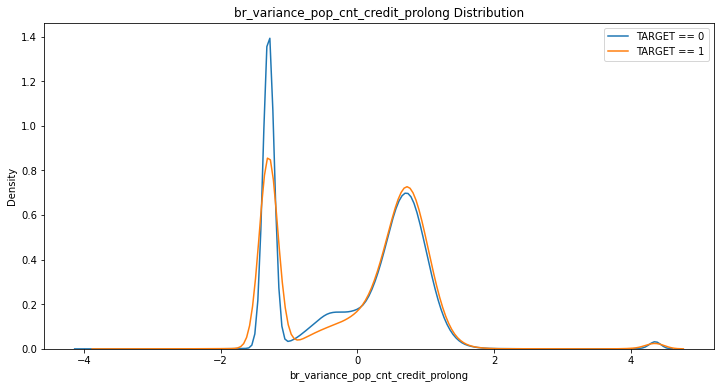

In [590]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_cnt_credit_prolong', app_train)

### br_min_amt_credit_sum

In [591]:
app_train[['TARGET', 'br_min_amt_credit_sum']].corr()

TARGET  br_min_amt_credit_sum
TARGET                 1.000000              -0.015568
br_min_amt_credit_sum -0.015568               1.000000

In [592]:
app_train['br_min_amt_credit_sum'].isnull().sum()

216533

The correlation between br_min_amt_credit_sum and the TARGET is -0.0156
Median value for loan that was not repaid = 41247.0000
Median value for loan that was repaid =     45180.0000


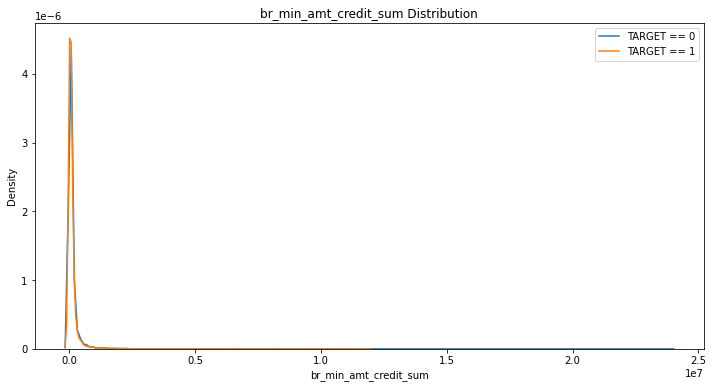

In [593]:
kde_target('br_min_amt_credit_sum', app_train)

In [594]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_amt_credit_sum')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [595]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [596]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()


In [597]:
#app_train['br_min_amt_credit_sum'].isnull().sum()

In [598]:
#app_train[['TARGET', 'br_min_amt_credit_sum']].corr()

In [599]:
## Yao-Johnson変換
#num_cols = ['br_min_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_min_amt_credit_sum'] = pt.transform(app_train[num_cols])
#app_test['br_min_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_min_amt_credit_sum']].corr()

In [600]:
## 標準化
#num_cols = ['br_min_amt_credit_sum']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_min_amt_credit_sum', 'TARGET']].corr()

In [601]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_min_amt_credit_sum', app_train)

In [602]:
columns = ['br_min_amt_credit_sum']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_max_amt_credit_sum

In [603]:
app_train[['TARGET', 'br_max_amt_credit_sum']].corr()

TARGET  br_max_amt_credit_sum
TARGET                 1.000000              -0.017089
br_max_amt_credit_sum -0.017089               1.000000

In [604]:
app_train['br_max_amt_credit_sum'].isnull().sum()

216533

The correlation between br_max_amt_credit_sum and the TARGET is -0.0171
Median value for loan that was not repaid = 450000.0000
Median value for loan that was repaid =     450000.0000


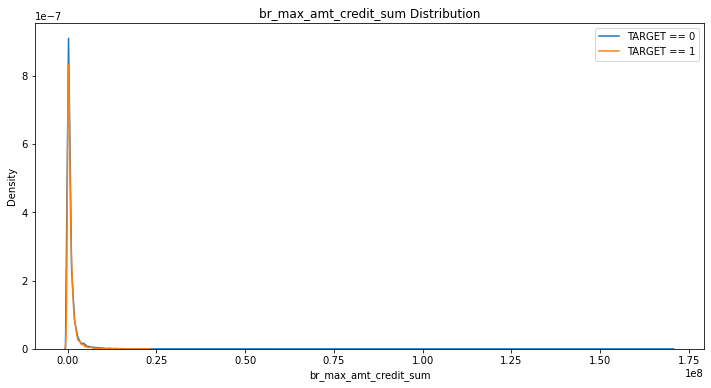

In [605]:
kde_target('br_max_amt_credit_sum', app_train)

In [606]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_max_amt_credit_sum')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [607]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [608]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [609]:
#app_train['br_max_amt_credit_sum'].isnull().sum()

In [610]:
#app_train[['TARGET', 'br_max_amt_credit_sum']].corr()

In [611]:
## Yao-Johnson変換
#num_cols = ['br_max_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_amt_credit_sum'] = pt.transform(app_train[num_cols])
#app_test['br_max_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_amt_credit_sum']].corr()

In [612]:
## 標準化
#num_cols = ['br_max_amt_credit_sum']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_max_amt_credit_sum', 'TARGET']].corr()

In [613]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_amt_credit_sum', app_train)

In [614]:
columns = ['br_max_amt_credit_sum']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_sum_amt_credit_sum

In [615]:
app_train[['TARGET', 'br_sum_amt_credit_sum']].corr()

TARGET  br_sum_amt_credit_sum
TARGET                 1.000000              -0.022722
br_sum_amt_credit_sum -0.022722               1.000000

In [616]:
app_train['br_sum_amt_credit_sum'].isnull().sum()

216533

The correlation between br_sum_amt_credit_sum and the TARGET is -0.0227
Median value for loan that was not repaid = 10970700.5700
Median value for loan that was repaid =     13885776.5625


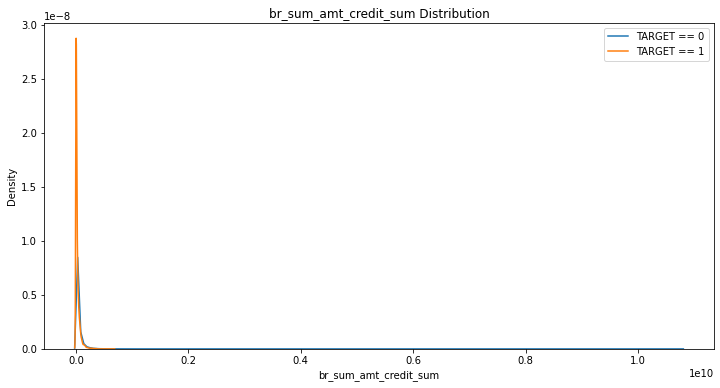

In [617]:
kde_target('br_sum_amt_credit_sum', app_train)

In [618]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_sum_amt_credit_sum')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_sum_amt_credit_sum  
0  52.715068           2.325722e+07  
1  49.490411           3.693978e+06  
2  54.898630           5.180700e+07  
3  38.290411           3.343834e+07  
4  35.726027           5.145053e+07  

[5 rows x 92 columns]

In [619]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [620]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()


SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [621]:
app_train['br_sum_amt_credit_sum'].isnull().sum()

0

In [622]:
app_train[['TARGET', 'br_sum_amt_credit_sum']].corr()

TARGET  br_sum_amt_credit_sum
TARGET                 1.000000              -0.014158
br_sum_amt_credit_sum -0.014158               1.000000

In [623]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum']].corr()

TARGET  br_sum_amt_credit_sum
TARGET                 1.00000               -0.02007
br_sum_amt_credit_sum -0.02007                1.00000

In [624]:
## 標準化
num_cols = ['br_sum_amt_credit_sum']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_sum_amt_credit_sum', 'TARGET']].corr()

br_sum_amt_credit_sum   TARGET
br_sum_amt_credit_sum                1.00000 -0.02007
TARGET                              -0.02007  1.00000

The correlation between br_sum_amt_credit_sum and the TARGET is -0.0201
Median value for loan that was not repaid = -0.1488
Median value for loan that was repaid =     -0.0896


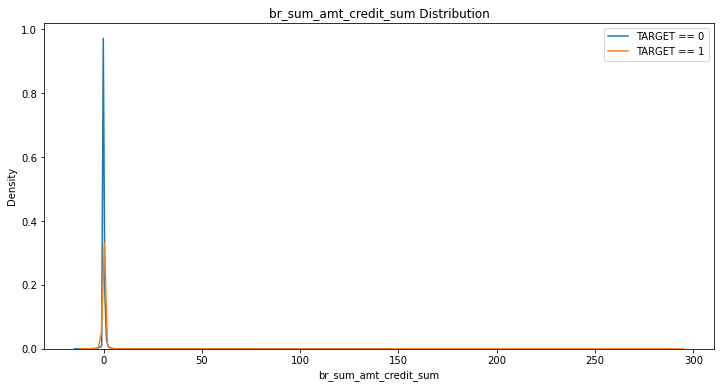

In [625]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_sum', app_train)

### br_avg_amt_credit_sum

In [626]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum']].corr()

TARGET  br_avg_amt_credit_sum
TARGET                 1.000000              -0.024453
br_avg_amt_credit_sum -0.024453               1.000000

In [627]:
app_train['br_avg_amt_credit_sum'].isnull().sum()

216533

The correlation between br_avg_amt_credit_sum and the TARGET is -0.0245
Median value for loan that was not repaid = 188596.1670
Median value for loan that was repaid =     205723.6006


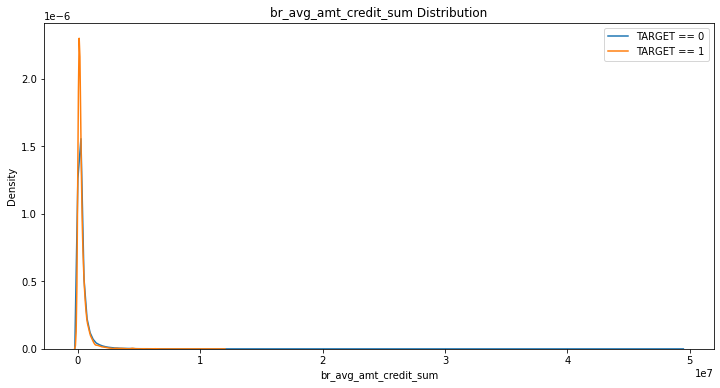

In [628]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum', app_train)

In [629]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_amt_credit_sum')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_avg_amt_credit_sum  
0  52.715068          176191.022727  
1  49.490411          175903.714286  
2  54.898630          518070.015000  
3  38.290411          123845.702667  
4  35.726027          432289.960814  

[5 rows x 92 columns]

In [630]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [631]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [632]:
app_train['br_avg_amt_credit_sum'].isnull().sum()

0

In [633]:
app_train[['TARGET', 'br_avg_amt_credit_sum']].corr()

TARGET  br_avg_amt_credit_sum
TARGET                 1.000000              -0.009143
br_avg_amt_credit_sum -0.009143               1.000000

In [634]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum']].corr()

TARGET  br_avg_amt_credit_sum
TARGET                 1.000000              -0.011773
br_avg_amt_credit_sum -0.011773               1.000000

In [635]:
## 標準化
num_cols = ['br_avg_amt_credit_sum']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_amt_credit_sum', 'TARGET']].corr()

br_avg_amt_credit_sum    TARGET
br_avg_amt_credit_sum               1.000000 -0.011773
TARGET                             -0.011773  1.000000

The correlation between br_avg_amt_credit_sum and the TARGET is -0.0118
Median value for loan that was not repaid = -0.1183
Median value for loan that was repaid =     -0.1027


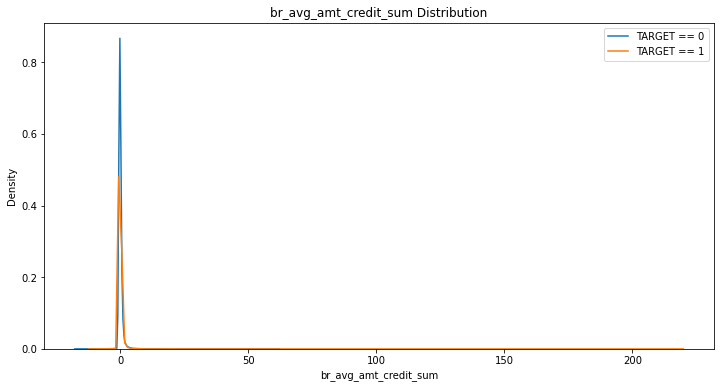

In [636]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_sum', app_train)

### br_cnt_amt_credit_sum

In [637]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum']].corr()

TARGET  br_cnt_amt_credit_sum
TARGET                 1.000000              -0.024241
br_cnt_amt_credit_sum -0.024241               1.000000

In [638]:
app_train['br_cnt_amt_credit_sum'].isnull().sum()

216533

The correlation between br_cnt_amt_credit_sum and the TARGET is -0.0242
Median value for loan that was not repaid = 55.0000
Median value for loan that was repaid =     63.0000


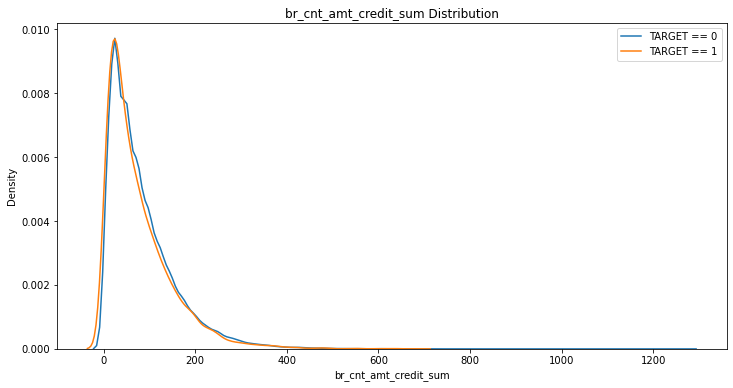

In [639]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum', app_train)

In [640]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_amt_credit_sum')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_amt_credit_sum  
0  52.715068             132.000000  
1  49.490411              21.000000  
2  54.898630             100.000000  
3  38.290411             270.000000  
4  35.726027             117.972473  

[5 rows x 92 columns]

In [641]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [642]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [643]:
app_train['br_cnt_amt_credit_sum'].isnull().sum()

0

In [644]:
app_train[['TARGET', 'br_cnt_amt_credit_sum']].corr()

TARGET  br_cnt_amt_credit_sum
TARGET                 1.000000              -0.027994
br_cnt_amt_credit_sum -0.027994               1.000000

In [645]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum']].corr()

TARGET  br_cnt_amt_credit_sum
TARGET                 1.000000              -0.037745
br_cnt_amt_credit_sum -0.037745               1.000000

In [646]:
## 標準化
num_cols = ['br_cnt_amt_credit_sum']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_amt_credit_sum', 'TARGET']].corr()

br_cnt_amt_credit_sum    TARGET
br_cnt_amt_credit_sum               1.000000 -0.037745
TARGET                             -0.037745  1.000000

The correlation between br_cnt_amt_credit_sum and the TARGET is -0.0377
Median value for loan that was not repaid = -0.0742
Median value for loan that was repaid =     0.0408


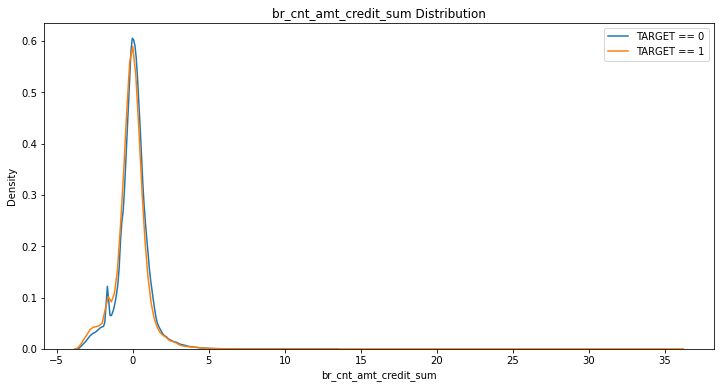

In [647]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum', app_train)

### br_stddev_amt_credit_sum

In [648]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum']].corr()

TARGET  br_stddev_amt_credit_sum
TARGET                    1.00000                  -0.01605
br_stddev_amt_credit_sum -0.01605                   1.00000

In [649]:
app_train['br_stddev_amt_credit_sum'].isnull().sum()

216533

The correlation between br_stddev_amt_credit_sum and the TARGET is -0.0160
Median value for loan that was not repaid = 115081.6729
Median value for loan that was repaid =     118802.8709


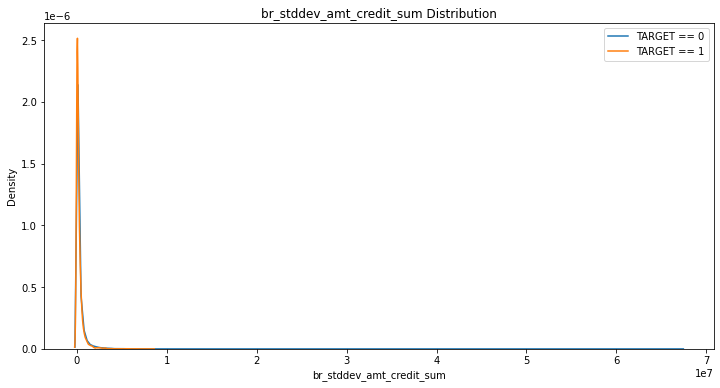

In [650]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum', app_train)

In [651]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_amt_credit_sum')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_pop_amt_credit_sum  
0  52.715068                 100431.790068  
1  49.490411                 219852.847988  
2  54.898630                 500863.123920  
3  38.290411                 104774.184496  
4  35.726027                 399786.291980  

[5 rows x 92 columns]

In [652]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [653]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [654]:
app_train['br_stddev_amt_credit_sum'].isnull().sum()

216533

In [655]:
app_train[['TARGET', 'br_stddev_amt_credit_sum']].corr()

TARGET  br_stddev_amt_credit_sum
TARGET                    1.00000                  -0.01605
br_stddev_amt_credit_sum -0.01605                   1.00000

In [656]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum']].corr()

TARGET  br_stddev_amt_credit_sum
TARGET                    1.000000                 -0.014225
br_stddev_amt_credit_sum -0.014225                  1.000000

In [657]:
## 標準化
num_cols = ['br_stddev_amt_credit_sum']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_amt_credit_sum', 'TARGET']].corr()

br_stddev_amt_credit_sum    TARGET
br_stddev_amt_credit_sum                  1.000000 -0.014225
TARGET                                   -0.014225  1.000000

The correlation between br_stddev_amt_credit_sum and the TARGET is -0.0142
Median value for loan that was not repaid = 0.1231
Median value for loan that was repaid =     0.1375


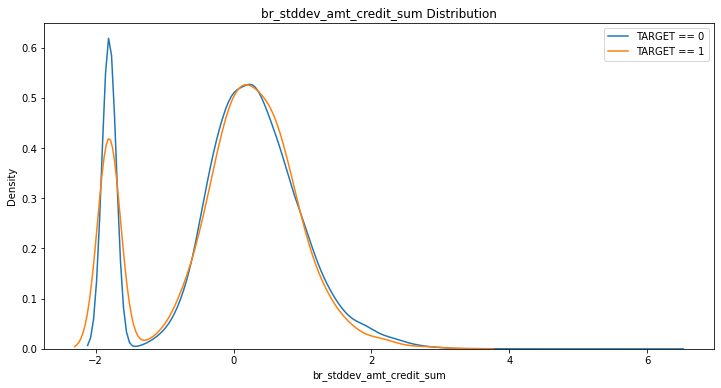

In [658]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum', app_train)

In [659]:
#######################################

In [660]:
#######################################

In [661]:
#######################################

In [662]:
#######################################

In [663]:
#######################################

In [664]:
#######################################

### br_stddev_pop_amt_credit_sum

In [665]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum']].corr()

TARGET  br_stddev_pop_amt_credit_sum
TARGET                        1.000000                     -0.006493
br_stddev_pop_amt_credit_sum -0.006493                      1.000000

In [666]:
app_train['br_stddev_pop_amt_credit_sum'].isnull().sum()

0

The correlation between br_stddev_pop_amt_credit_sum and the TARGET is -0.0065
Median value for loan that was not repaid = 213648.0537
Median value for loan that was repaid =     220030.2356


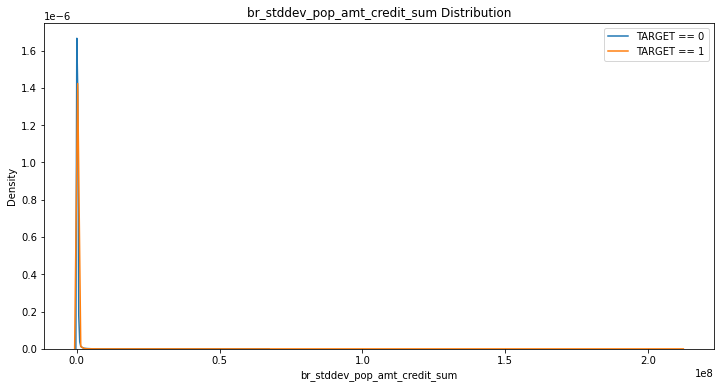

In [667]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum', app_train)

In [668]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_pop_amt_credit_sum')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [669]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [670]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [671]:
#app_train['br_stddev_pop_amt_credit_sum'].isnull().sum()

In [672]:
#app_train[['TARGET', 'br_stddev_pop_amt_credit_sum']].corr()

In [673]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_amt_credit_sum'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_amt_credit_sum']].corr()

In [674]:
## 標準化
#num_cols = ['br_stddev_pop_amt_credit_sum']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_pop_amt_credit_sum', 'TARGET']].corr()

In [675]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_pop_amt_credit_sum', app_train)

In [676]:
columns = ['br_stddev_pop_amt_credit_sum']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_pop_amt_credit_sum

In [677]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum']].corr()

TARGET  br_var_pop_amt_credit_sum
TARGET                     1.000000                  -0.003281
br_var_pop_amt_credit_sum -0.003281                   1.000000

In [678]:
app_train['br_var_pop_amt_credit_sum'].isnull().sum()

216533

The correlation between br_var_pop_amt_credit_sum and the TARGET is -0.0033
Median value for loan that was not repaid = 13243791474.0720
Median value for loan that was repaid =     14114122130.7509


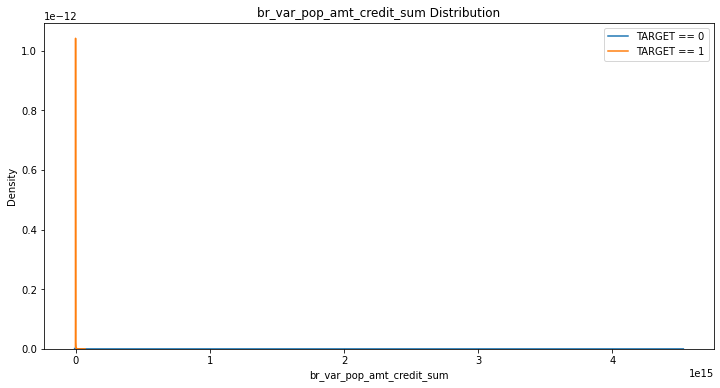

In [679]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum', app_train)

In [680]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_pop_amt_credit_sum')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()


In [681]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()


In [682]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [683]:
#app_train['br_var_pop_amt_credit_sum'].isnull().sum()

In [684]:
#app_train[['TARGET', 'br_var_pop_amt_credit_sum']].corr()

In [685]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_amt_credit_sum'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_pop_amt_credit_sum']].corr()

In [686]:
## 標準化
#num_cols = ['br_var_pop_amt_credit_sum']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_pop_amt_credit_sum', 'TARGET']].corr()

In [687]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_pop_amt_credit_sum', app_train)

In [688]:
columns = ['br_var_pop_amt_credit_sum']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_samp_amt_credit_sum

In [689]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum']].corr()

TARGET  br_var_samp_amt_credit_sum
TARGET                      1.000000                   -0.003296
br_var_samp_amt_credit_sum -0.003296                    1.000000

In [690]:
app_train['br_var_samp_amt_credit_sum'].isnull().sum()

216533

The correlation between br_var_samp_amt_credit_sum and the TARGET is -0.0033
Median value for loan that was not repaid = 13496990774.6073
Median value for loan that was repaid =     14378410115.8489


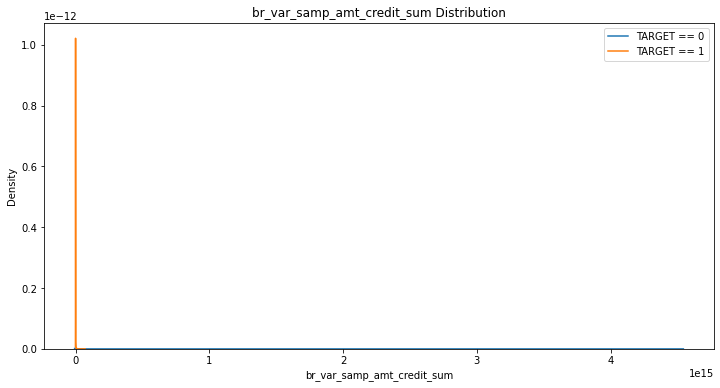

In [691]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum', app_train)

In [692]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_samp_amt_credit_sum')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [693]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [694]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [695]:
#app_train['br_var_samp_amt_credit_sum'].isnull().sum()

In [696]:
#app_train[['TARGET', 'br_var_samp_amt_credit_sum']].corr()

In [697]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_amt_credit_sum'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_amt_credit_sum'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_amt_credit_sum']].corr()

In [698]:
## 標準化
#num_cols = ['br_var_samp_amt_credit_sum']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_samp_amt_credit_sum', 'TARGET']].corr()

In [699]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_amt_credit_sum', app_train)

In [700]:
columns = ['br_var_samp_amt_credit_sum']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_variance_pop_amt_credit_sum

In [701]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum']].corr()

TARGET  br_variance_pop_amt_credit_sum
TARGET                          1.000000                       -0.003281
br_variance_pop_amt_credit_sum -0.003281                        1.000000

The correlation between br_variance_pop_amt_credit_sum and the TARGET is -0.0033
Median value for loan that was not repaid = 13243791474.0720
Median value for loan that was repaid =     14114122130.7509


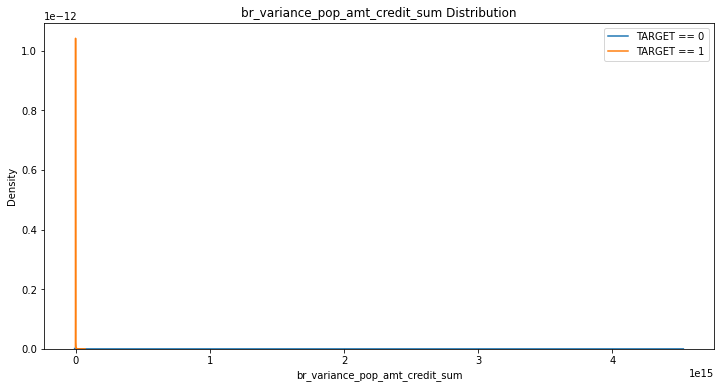

In [702]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum', app_train)

In [703]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [704]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum']].corr()

TARGET  br_variance_pop_amt_credit_sum
TARGET                          1.000000                       -0.014224
br_variance_pop_amt_credit_sum -0.014224                        1.000000

The correlation between br_variance_pop_amt_credit_sum and the TARGET is -0.0142
Median value for loan that was not repaid = 0.1232
Median value for loan that was repaid =     0.1375


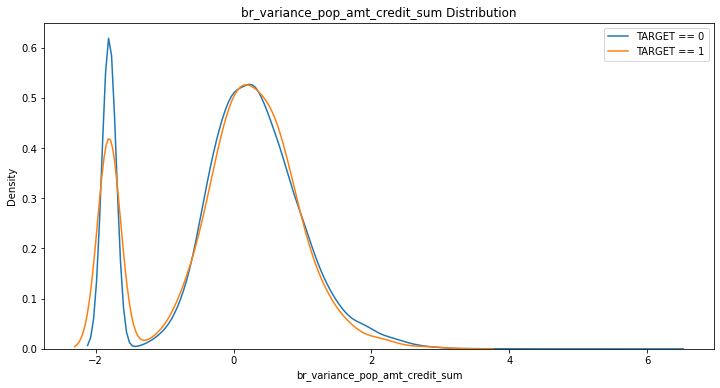

In [705]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum', app_train)

### br_min_amt_credit_sum_debt

In [706]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_debt']].corr()

TARGET  br_min_amt_credit_sum_debt
TARGET                      1.000000                   -0.002451
br_min_amt_credit_sum_debt -0.002451                    1.000000

In [707]:
app_train['br_min_amt_credit_sum_debt'].isnull().sum()

216533

The correlation between br_min_amt_credit_sum_debt and the TARGET is -0.0025
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


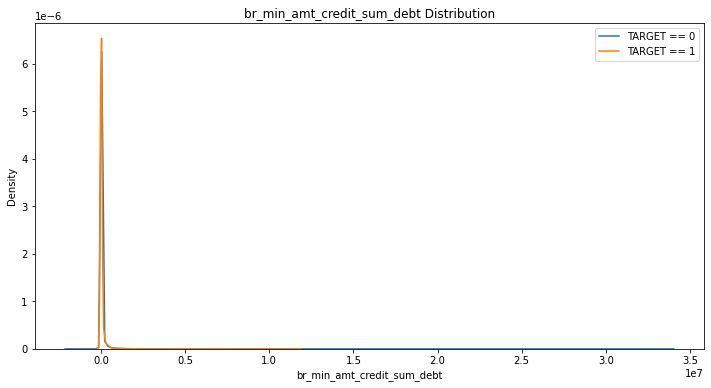

In [708]:
## 特徴量の分布
kde_target('br_min_amt_credit_sum_debt', app_train)

In [709]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [710]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [711]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [712]:
app_train['br_min_amt_credit_sum_debt'].isnull().sum()

216533

In [713]:
app_train[['TARGET', 'br_min_amt_credit_sum_debt']].corr()

TARGET  br_min_amt_credit_sum_debt
TARGET                      1.000000                   -0.002451
br_min_amt_credit_sum_debt -0.002451                    1.000000

In [714]:
## Yao-Johnson変換
#num_cols = ['br_min_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_min_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_min_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_min_amt_credit_sum_debt']].corr()

In [715]:
## 標準化
#num_cols = ['br_min_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_min_amt_credit_sum_debt', 'TARGET']].corr()

In [716]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_min_amt_credit_sum_debt', app_train)

In [717]:
columns = ['br_min_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)


### br_max_amt_credit_sum_debt

In [718]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_debt']].corr()

TARGET  br_max_amt_credit_sum_debt
TARGET                      1.000000                    0.001483
br_max_amt_credit_sum_debt  0.001483                    1.000000

In [719]:
app_train['br_max_amt_credit_sum_debt'].isnull().sum()

216533

The correlation between br_max_amt_credit_sum_debt and the TARGET is 0.0015
Median value for loan that was not repaid = 213130.4850
Median value for loan that was repaid =     150934.5000


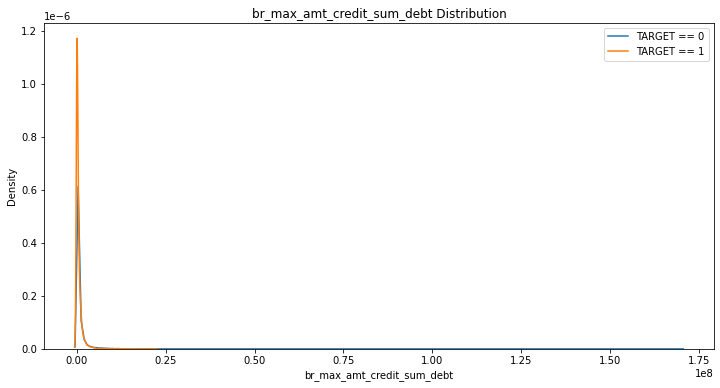

In [720]:
## 特徴量の分布
kde_target('br_max_amt_credit_sum_debt', app_train)

In [721]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_max_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [722]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [723]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [724]:
#app_train['br_max_amt_credit_sum_debt'].isnull().sum()

In [725]:
#app_train[['TARGET', 'br_max_amt_credit_sum_debt']].corr()

In [726]:
## Yao-Johnson変換
#num_cols = ['br_max_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_max_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_amt_credit_sum_debt']].corr()

In [727]:
## 標準化
#num_cols = ['br_max_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_max_amt_credit_sum_debt', 'TARGET']].corr()

In [728]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_amt_credit_sum_debt', app_train)

In [729]:
columns = ['br_max_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_sum_amt_credit_sum_debt

In [730]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_debt']].corr()

TARGET  br_sum_amt_credit_sum_debt
TARGET                      1.000000                   -0.003126
br_sum_amt_credit_sum_debt -0.003126                    1.000000

In [731]:
app_train['br_sum_amt_credit_sum_debt'].isnull().sum()

216533

The correlation between br_sum_amt_credit_sum_debt and the TARGET is -0.0031
Median value for loan that was not repaid = 2581827.7050
Median value for loan that was repaid =     1814415.5925


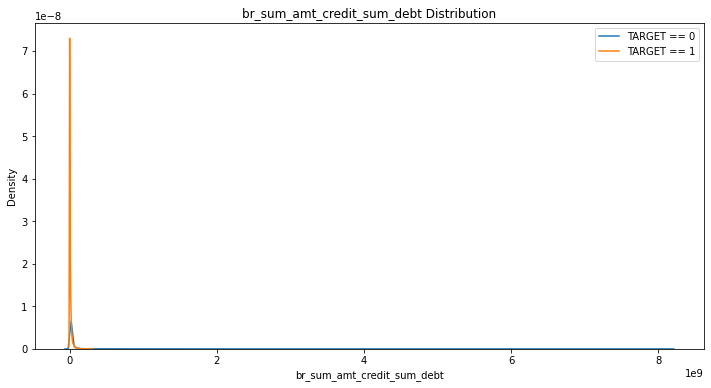

In [732]:
## 特徴量の分布
kde_target('br_sum_amt_credit_sum_debt', app_train)

In [733]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_sum_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [734]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [735]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [736]:
#app_train['br_sum_amt_credit_sum_debt'].isnull().sum()

In [737]:
#app_train[['TARGET', 'br_sum_amt_credit_sum_debt']].corr()

In [738]:
## Yao-Johnson変換
#num_cols = ['br_sum_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_sum_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_sum_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_sum_amt_credit_sum_debt']].corr()

In [739]:
## 標準化
#num_cols = ['br_sum_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_sum_amt_credit_sum_debt', 'TARGET']].corr()

In [740]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_sum_amt_credit_sum_debt', app_train)

In [741]:
app_train.drop(['br_sum_amt_credit_sum_debt'], axis=1, inplace=True)
app_test.drop(['br_sum_amt_credit_sum_debt'], axis=1, inplace=True)

### br_avg_amt_credit_sum_debt

In [742]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_debt']].corr()

TARGET  br_avg_amt_credit_sum_debt
TARGET                      1.000000                   -0.001805
br_avg_amt_credit_sum_debt -0.001805                    1.000000

In [743]:
app_train['br_avg_amt_credit_sum_debt'].isnull().sum()

216533

The correlation between br_avg_amt_credit_sum_debt and the TARGET is -0.0018
Median value for loan that was not repaid = 59774.3931
Median value for loan that was repaid =     37875.3462


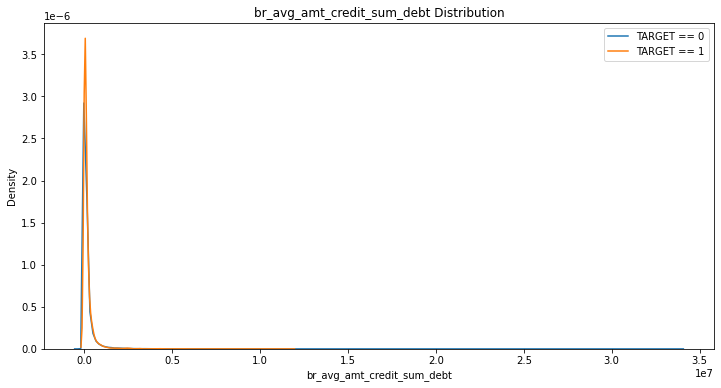

In [744]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum_debt', app_train)

In [745]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_avg_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [746]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [747]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [748]:
#app_train['br_avg_amt_credit_sum_debt'].isnull().sum()

In [749]:
#app_train[['TARGET', 'br_avg_amt_credit_sum_debt']].corr()

In [750]:
## Yao-Johnson変換
#num_cols = ['br_avg_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_avg_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_avg_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_avg_amt_credit_sum_debt']].corr()

In [751]:
## 標準化
#num_cols = ['br_avg_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_avg_amt_credit_sum_debt', 'TARGET']].corr()

In [752]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_avg_amt_credit_sum_debt', app_train)

In [753]:
app_train.drop(['br_avg_amt_credit_sum_debt'], axis=1, inplace=True)
app_test.drop(['br_avg_amt_credit_sum_debt'], axis=1, inplace=True)

### br_cnt_amt_credit_sum_debt

In [754]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_debt']].corr()

TARGET  br_cnt_amt_credit_sum_debt
TARGET                      1.000000                   -0.020236
br_cnt_amt_credit_sum_debt -0.020236                    1.000000

In [755]:
app_train['br_cnt_amt_credit_sum_debt'].isnull().sum()

216533

The correlation between br_cnt_amt_credit_sum_debt and the TARGET is -0.0202
Median value for loan that was not repaid = 48.0000
Median value for loan that was repaid =     51.0000


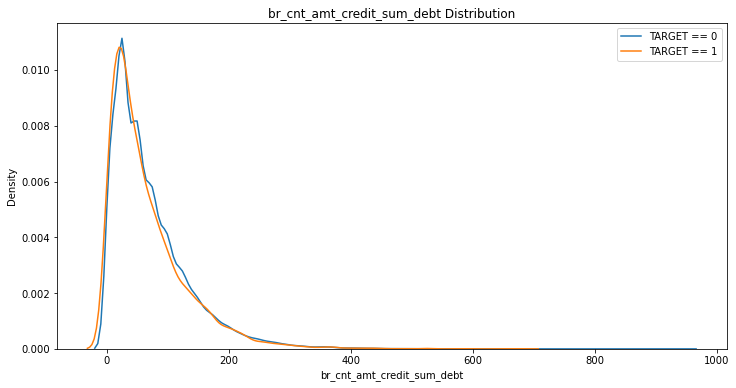

In [756]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum_debt', app_train)

In [757]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_amt_credit_sum_debt')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_amt_credit_sum_debt  
0  52.715068                  132.000000  
1  49.490411                   21.000000  
2  54.898630                   25.000000  
3  38.290411                  220.000000  
4  35.726027                  104.532477  

[5 rows x 92 columns]

In [758]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [759]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [760]:
app_train['br_cnt_amt_credit_sum_debt'].isnull().sum()

0

In [761]:
app_train[['TARGET', 'br_cnt_amt_credit_sum_debt']].corr()

TARGET  br_cnt_amt_credit_sum_debt
TARGET                      1.000000                   -0.022178
br_cnt_amt_credit_sum_debt -0.022178                    1.000000

In [762]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_debt']].corr()

TARGET  br_cnt_amt_credit_sum_debt
TARGET                      1.000000                   -0.028732
br_cnt_amt_credit_sum_debt -0.028732                    1.000000

In [763]:
## 標準化
num_cols = ['br_cnt_amt_credit_sum_debt']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_amt_credit_sum_debt', 'TARGET']].corr()

br_cnt_amt_credit_sum_debt    TARGET
br_cnt_amt_credit_sum_debt                    1.000000 -0.028732
TARGET                                       -0.028732  1.000000

The correlation between br_cnt_amt_credit_sum_debt and the TARGET is -0.0287
Median value for loan that was not repaid = -0.0522
Median value for loan that was repaid =     0.0329


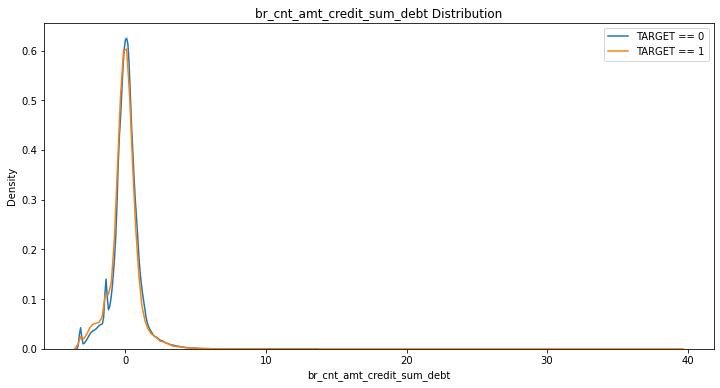

In [764]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum_debt', app_train)

### br_stddev_amt_credit_sum_debt

In [765]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_debt']].corr()

TARGET  br_stddev_amt_credit_sum_debt
TARGET                         1.000000                      -0.000296
br_stddev_amt_credit_sum_debt -0.000296                       1.000000

In [766]:
app_train['br_stddev_amt_credit_sum_debt'].isnull().sum()

216533

The correlation between br_stddev_amt_credit_sum_debt and the TARGET is -0.0003
Median value for loan that was not repaid = 57373.3289
Median value for loan that was repaid =     37771.0471


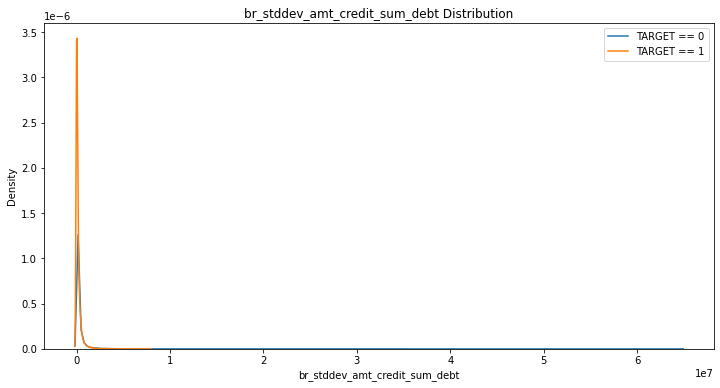

In [767]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum_debt', app_train)

In [768]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [769]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [770]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()


In [771]:
#app_train['br_stddev_amt_credit_sum_debt'].isnull().sum()

In [772]:
#app_train[['TARGET', 'br_stddev_amt_credit_sum_debt']].corr()

In [773]:
## Yao-Johnson変換
#num_cols = ['br_stddev_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_amt_credit_sum_debt']].corr()

In [774]:
## 標準化
#num_cols = ['br_stddev_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_amt_credit_sum_debt', 'TARGET']].corr()

In [775]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_amt_credit_sum_debt', app_train)

In [776]:
columns = ['br_stddev_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_stddev_pop_amt_credit_sum_debt

In [777]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_debt']].corr()

TARGET  br_stddev_pop_amt_credit_sum_debt
TARGET                             1.000000                          -0.000296
br_stddev_pop_amt_credit_sum_debt -0.000296                           1.000000

In [778]:
app_train['br_stddev_pop_amt_credit_sum_debt'].isnull().sum()

216533

The correlation between br_stddev_pop_amt_credit_sum_debt and the TARGET is -0.0003
Median value for loan that was not repaid = 57373.3289
Median value for loan that was repaid =     37771.0471


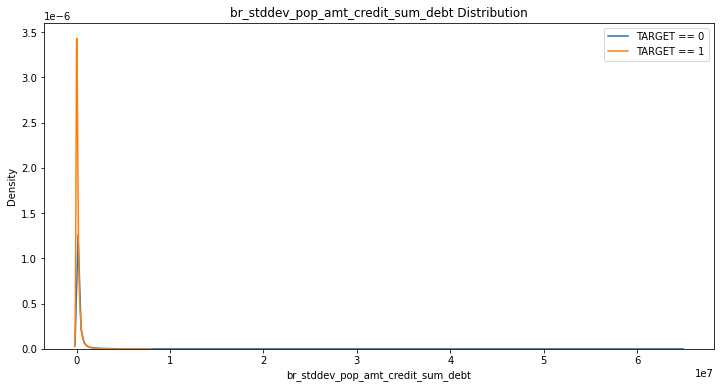

In [779]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_debt', app_train)

In [780]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_pop_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [781]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [782]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [783]:
#app_train['br_stddev_pop_amt_credit_sum_debt'].isnull().sum()

In [784]:
#app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_debt']].corr()

In [785]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_debt']].corr()

In [786]:
## 標準化
#num_cols = ['br_stddev_pop_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_pop_amt_credit_sum_debt', 'TARGET']].corr()

In [787]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_pop_amt_credit_sum_debt', app_train)

In [788]:
columns = ['br_stddev_pop_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_pop_amt_credit_sum_debt

In [789]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_debt']].corr()

TARGET  br_var_pop_amt_credit_sum_debt
TARGET                          1.000000                       -0.001926
br_var_pop_amt_credit_sum_debt -0.001926                        1.000000

In [790]:
app_train['br_var_pop_amt_credit_sum_debt'].isnull().sum()

216533

The correlation between br_var_pop_amt_credit_sum_debt and the TARGET is -0.0019
Median value for loan that was not repaid = 3291699179.2368
Median value for loan that was repaid =     1426652000.4110


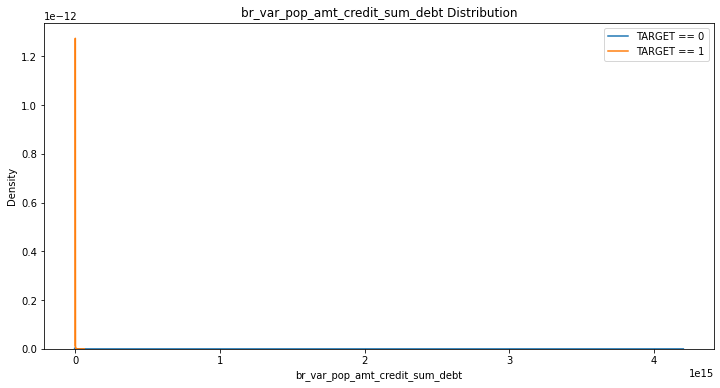

In [791]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum_debt', app_train)

In [792]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_pop_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [793]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [794]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [795]:
#app_train['br_var_pop_amt_credit_sum_debt'].isnull().sum()

In [796]:
#app_train[['TARGET', 'br_var_pop_amt_credit_sum_debt']].corr()

In [797]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_pop_amt_credit_sum_debt']].corr()

In [798]:
## 標準化
#num_cols = ['br_var_pop_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_pop_amt_credit_sum_debt', 'TARGET']].corr()

In [799]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_pop_amt_credit_sum_debt', app_train)

In [800]:
columns = ['br_var_pop_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_samp_amt_credit_sum_debt

In [801]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_debt']].corr()

TARGET  br_var_samp_amt_credit_sum_debt
TARGET                           1.000000                        -0.001934
br_var_samp_amt_credit_sum_debt -0.001934                         1.000000

In [802]:
app_train['br_var_samp_amt_credit_sum_debt'].isnull().sum()

216533

The correlation between br_var_samp_amt_credit_sum_debt and the TARGET is -0.0019
Median value for loan that was not repaid = 3408582441.9143
Median value for loan that was repaid =     1464727931.8342


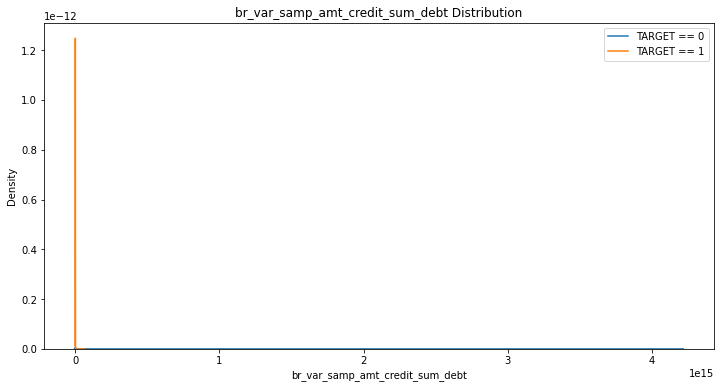

In [803]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum_debt', app_train)

In [804]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_samp_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [805]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [806]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [807]:
#app_train['br_var_samp_amt_credit_sum_debt'].isnull().sum()

In [808]:
#app_train[['TARGET', 'br_var_samp_amt_credit_sum_debt']].corr()

In [809]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_amt_credit_sum_debt']].corr()

In [810]:
## 標準化
#num_cols = ['br_var_samp_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_samp_amt_credit_sum_debt', 'TARGET']].corr()

In [811]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_amt_credit_sum_debt', app_train)

In [812]:
columns = ['br_var_samp_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_variance_pop_amt_credit_sum_debt

In [813]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_debt']].corr()

TARGET  \
TARGET                               1.000000   
br_variance_pop_amt_credit_sum_debt -0.001926   

                                     br_variance_pop_amt_credit_sum_debt  
TARGET                                                         -0.001926  
br_variance_pop_amt_credit_sum_debt                             1.000000

In [814]:
app_train['br_variance_pop_amt_credit_sum_debt'].isnull().sum()

216533

The correlation between br_variance_pop_amt_credit_sum_debt and the TARGET is -0.0019
Median value for loan that was not repaid = 3291699179.2368
Median value for loan that was repaid =     1426652000.4110


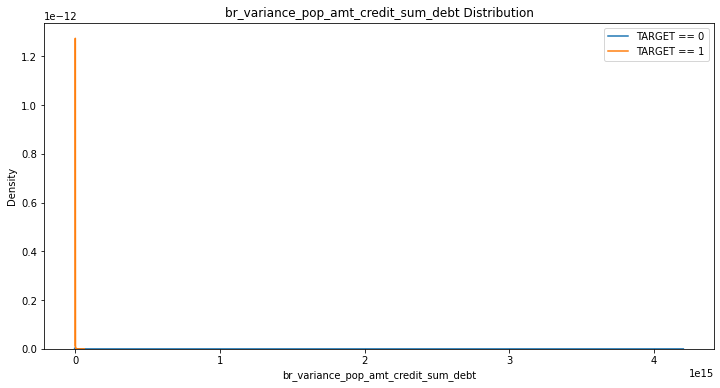

In [815]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_debt', app_train)

In [816]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_variance_pop_amt_credit_sum_debt')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [817]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [818]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [819]:
#app_train['br_variance_pop_amt_credit_sum_debt'].isnull().sum()

In [820]:
#app_train[['TARGET', 'br_variance_pop_amt_credit_sum_debt']].corr()

In [821]:
## Yao-Johnson変換
#num_cols = ['br_variance_pop_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_variance_pop_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
#app_test['br_variance_pop_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_variance_pop_amt_credit_sum_debt']].corr()

In [822]:
## 標準化
#num_cols = ['br_variance_pop_amt_credit_sum_debt']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_variance_pop_amt_credit_sum_debt', 'TARGET']].corr()

In [823]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_variance_pop_amt_credit_sum_debt', app_train)

In [824]:
columns = ['br_variance_pop_amt_credit_sum_debt']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_min_amt_credit_sum_limit

In [825]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_limit']].corr()

TARGET  br_min_amt_credit_sum_limit
TARGET                       1.000000                    -0.003997
br_min_amt_credit_sum_limit -0.003997                     1.000000

In [826]:
app_train['br_min_amt_credit_sum_limit'].isnull().sum()

216533

The correlation between br_min_amt_credit_sum_limit and the TARGET is -0.0040
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


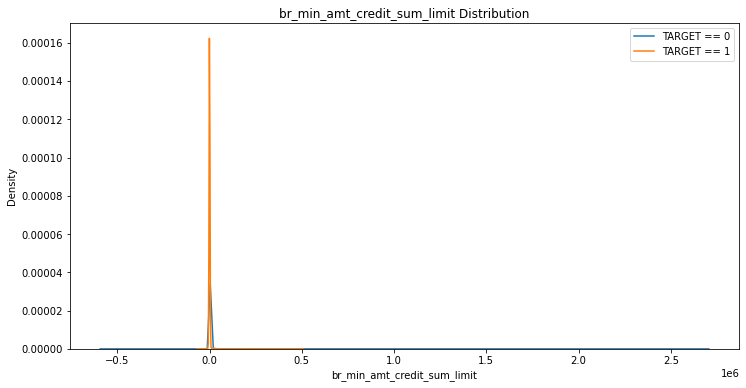

In [827]:
## 特徴量の分布
kde_target('br_min_amt_credit_sum_limit', app_train)

In [828]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_amt_credit_sum_limit')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [829]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [830]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [831]:
#app_train['br_min_amt_credit_sum_limit'].isnull().sum()

In [832]:
#app_train[['TARGET', 'br_min_amt_credit_sum_limit']].corr()

In [833]:
## Yao-Johnson変換
#num_cols = ['br_min_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_min_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_min_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_min_amt_credit_sum_limit']].corr()

In [834]:
## 標準化
#num_cols = ['br_min_amt_credit_sum_limit']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_min_amt_credit_sum_limit', 'TARGET']].corr()

In [835]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_min_amt_credit_sum_limit', app_train)

In [836]:
columns = ['br_min_amt_credit_sum_limit']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_max_amt_credit_sum_limit

In [837]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_limit']].corr()

TARGET  br_max_amt_credit_sum_limit
TARGET                       1.000000                    -0.012056
br_max_amt_credit_sum_limit -0.012056                     1.000000

In [838]:
app_train[['TARGET', 'br_max_amt_credit_sum_limit']].corr()

TARGET  br_max_amt_credit_sum_limit
TARGET                       1.000000                    -0.012056
br_max_amt_credit_sum_limit -0.012056                     1.000000

The correlation between br_max_amt_credit_sum_limit and the TARGET is -0.0121
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


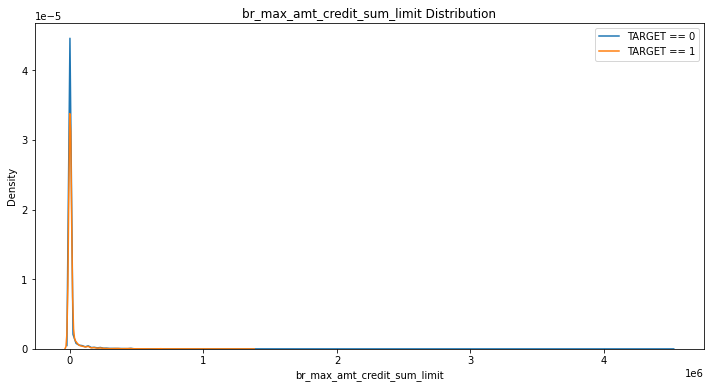

In [839]:
## 特徴量の分布
kde_target('br_max_amt_credit_sum_limit', app_train)

In [840]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_max_amt_credit_sum_limit')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_max_amt_credit_sum_limit  
0  52.715068                     0.000000  
1  49.490411                     0.000000  
2  54.898630                     0.000000  
3  38.290411                101390.760000  
4  35.726027                 19117.509747  

[5 rows x 92 columns]

In [841]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [842]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [843]:
app_train['br_max_amt_credit_sum_limit'].isnull().sum()

0

In [844]:
app_train[['TARGET', 'br_max_amt_credit_sum_limit']].corr()

TARGET  br_max_amt_credit_sum_limit
TARGET                       1.000000                    -0.010323
br_max_amt_credit_sum_limit -0.010323                     1.000000

In [845]:
## Yao-Johnson変換
num_cols = ['br_max_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_limit']].corr()

TARGET  br_max_amt_credit_sum_limit
TARGET                       1.000000                    -0.015318
br_max_amt_credit_sum_limit -0.015318                     1.000000

In [846]:
## 標準化
num_cols = ['br_max_amt_credit_sum_limit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_max_amt_credit_sum_limit', 'TARGET']].corr()

br_max_amt_credit_sum_limit    TARGET
br_max_amt_credit_sum_limit                     1.000000 -0.015318
TARGET                                         -0.015318  1.000000

The correlation between br_max_amt_credit_sum_limit and the TARGET is -0.0153
Median value for loan that was not repaid = 0.0283
Median value for loan that was repaid =     0.0611


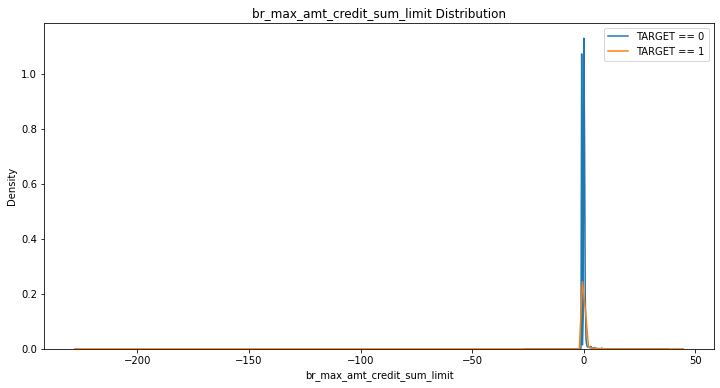

In [847]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_amt_credit_sum_limit', app_train)

### br_sum_amt_credit_sum_limit

In [848]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_limit']].corr()

TARGET  br_sum_amt_credit_sum_limit
TARGET                       1.000000                    -0.014251
br_sum_amt_credit_sum_limit -0.014251                     1.000000

In [849]:
app_train['br_sum_amt_credit_sum_limit'].isnull().sum()

216533

The correlation between br_sum_amt_credit_sum_limit and the TARGET is -0.0143
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


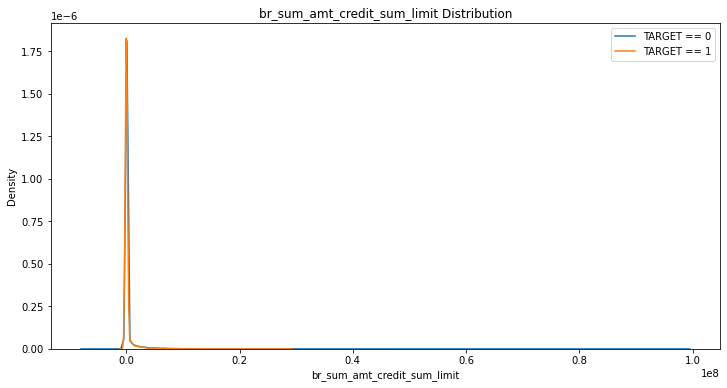

In [850]:
## 特徴量の分布
kde_target('br_sum_amt_credit_sum_limit', app_train)

In [851]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_sum_amt_credit_sum_limit')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()


SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_sum_amt_credit_sum_limit  
0  52.715068                     0.000000  
1  49.490411                     0.000000  
2  54.898630                     0.000000  
3  38.290411                912516.840000  
4  35.726027                382195.580838  

[5 rows x 92 columns]

In [852]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [853]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [854]:
app_train['br_sum_amt_credit_sum_limit'].isnull().sum()

0

In [855]:
app_train[['TARGET', 'br_sum_amt_credit_sum_limit']].corr()

TARGET  br_sum_amt_credit_sum_limit
TARGET                       1.000000                    -0.011858
br_sum_amt_credit_sum_limit -0.011858                     1.000000

In [856]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_limit']].corr()

TARGET  br_sum_amt_credit_sum_limit
TARGET                       1.00000                     -0.01266
br_sum_amt_credit_sum_limit -0.01266                      1.00000

In [857]:
## 標準化
num_cols = ['br_sum_amt_credit_sum_limit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_sum_amt_credit_sum_limit', 'TARGET']].corr()

br_sum_amt_credit_sum_limit   TARGET
br_sum_amt_credit_sum_limit                      1.00000 -0.01266
TARGET                                          -0.01266  1.00000

The correlation between br_sum_amt_credit_sum_limit and the TARGET is -0.0127
Median value for loan that was not repaid = -0.0821
Median value for loan that was repaid =     -0.0564


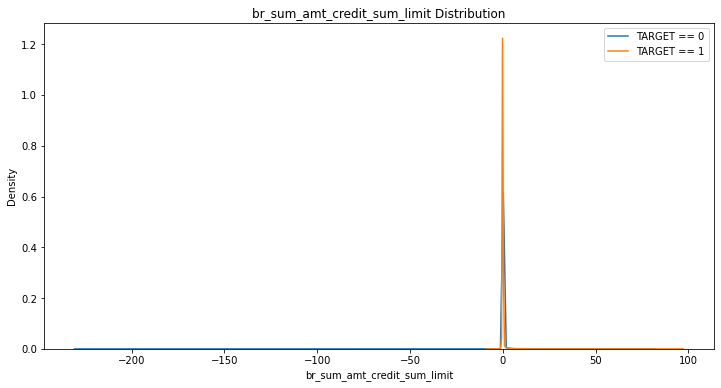

In [858]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_sum_limit', app_train)

### br_avg_amt_credit_sum_limit

In [859]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_limit']].corr()

TARGET  br_avg_amt_credit_sum_limit
TARGET                       1.000000                    -0.011128
br_avg_amt_credit_sum_limit -0.011128                     1.000000

In [860]:
app_train['br_avg_amt_credit_sum_limit'].isnull().sum()

216533

The correlation between br_avg_amt_credit_sum_limit and the TARGET is -0.0111
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


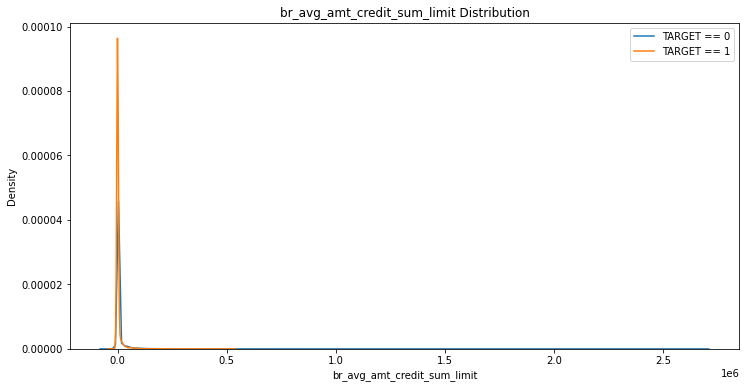

In [861]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum_limit', app_train)

In [862]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_avg_amt_credit_sum_limit')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [863]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [864]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [865]:
#app_train['br_avg_amt_credit_sum_limit'].isnull().sum()

In [866]:
#app_train[['TARGET', 'br_avg_amt_credit_sum_limit']].corr()

In [867]:
## Yao-Johnson変換
#num_cols = ['br_avg_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_avg_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_avg_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_avg_amt_credit_sum_limit']].corr()

In [868]:
## 標準化
#num_cols = ['br_avg_amt_credit_sum_limit']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_avg_amt_credit_sum_limit', 'TARGET']].corr()

In [869]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_avg_amt_credit_sum_limit', app_train)

In [870]:
columns = ['br_avg_amt_credit_sum_limit']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_cnt_amt_credit_sum_limit

In [871]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_limit']].corr()

TARGET  br_cnt_amt_credit_sum_limit
TARGET                       1.000000                    -0.019026
br_cnt_amt_credit_sum_limit -0.019026                     1.000000

In [872]:
app_train['br_cnt_amt_credit_sum_limit'].isnull().sum()

216533

The correlation between br_cnt_amt_credit_sum_limit and the TARGET is -0.0190
Median value for loan that was not repaid = 33.0000
Median value for loan that was repaid =     38.0000


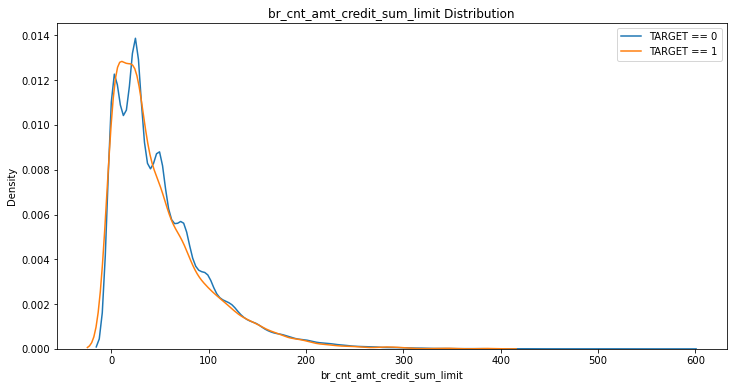

In [873]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum_limit', app_train)

In [874]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_amt_credit_sum_limit')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_amt_credit_sum_limit  
0  52.715068                   121.000000  
1  49.490411                    21.000000  
2  54.898630                     0.000000  
3  38.290411                   145.000000  
4  35.726027                    70.264946  

[5 rows x 92 columns]

In [875]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [876]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [877]:
app_train['br_cnt_amt_credit_sum_limit'].isnull().sum()

0

In [878]:
app_train[['TARGET', 'br_cnt_amt_credit_sum_limit']].corr()

TARGET  br_cnt_amt_credit_sum_limit
TARGET                       1.000000                    -0.019152
br_cnt_amt_credit_sum_limit -0.019152                     1.000000

In [879]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_limit']].corr()

TARGET  br_cnt_amt_credit_sum_limit
TARGET                       1.000000                    -0.023237
br_cnt_amt_credit_sum_limit -0.023237                     1.000000

In [880]:
## 標準化
num_cols = ['br_cnt_amt_credit_sum_limit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_amt_credit_sum_limit', 'TARGET']].corr()

br_cnt_amt_credit_sum_limit    TARGET
br_cnt_amt_credit_sum_limit                     1.000000 -0.023237
TARGET                                         -0.023237  1.000000

The correlation between br_cnt_amt_credit_sum_limit and the TARGET is -0.0232
Median value for loan that was not repaid = -0.0237
Median value for loan that was repaid =     0.0347


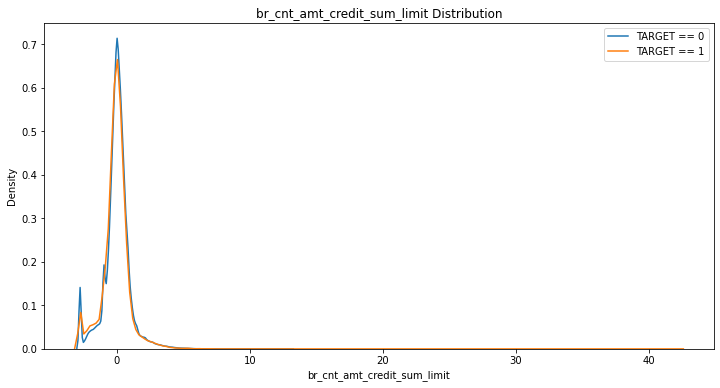

In [881]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum_limit', app_train)

### br_stddev_amt_credit_sum_limit

In [882]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_limit']].corr()

TARGET  br_stddev_amt_credit_sum_limit
TARGET                          1.000000                       -0.011591
br_stddev_amt_credit_sum_limit -0.011591                        1.000000

In [883]:
app_train['br_stddev_amt_credit_sum_limit'].isnull().sum()

216533

The correlation between br_stddev_amt_credit_sum_limit and the TARGET is -0.0116
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


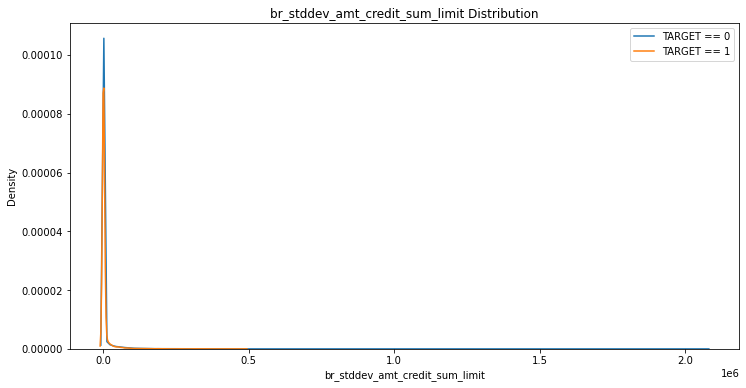

In [884]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum_limit', app_train)

In [885]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_amt_credit_sum_limit')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [886]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [887]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [888]:
#app_train['br_stddev_amt_credit_sum_limit'].isnull().sum()

In [889]:
#app_train[['TARGET', 'br_stddev_amt_credit_sum_limit']].corr()

In [890]:
## Yao-Johnson変換
#num_cols = ['br_stddev_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_amt_credit_sum_limit']].corr()

In [891]:
## 標準化
#num_cols = ['br_stddev_amt_credit_sum_limit']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_amt_credit_sum_limit', 'TARGET']].corr()

In [892]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_amt_credit_sum_limit', app_train)

In [893]:
columns = ['br_stddev_amt_credit_sum_limit']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_stddev_pop_amt_credit_sum_limit

In [894]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                              1.000000   
br_stddev_pop_amt_credit_sum_limit -0.011591   

                                    br_stddev_pop_amt_credit_sum_limit  
TARGET                                                       -0.011591  
br_stddev_pop_amt_credit_sum_limit                            1.000000

In [895]:
app_train['br_stddev_pop_amt_credit_sum_limit'].isnull().sum()

216533

The correlation between br_stddev_pop_amt_credit_sum_limit and the TARGET is -0.0116
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


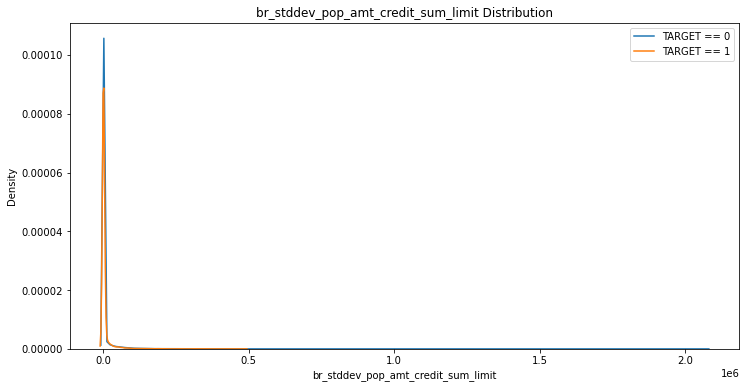

In [896]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_limit', app_train)

In [897]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_pop_amt_credit_sum_limit')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [898]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [899]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [900]:
#app_train['br_stddev_pop_amt_credit_sum_limit'].isnull().sum()

In [901]:
#app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_limit']].corr()

In [902]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_limit']].corr()

In [903]:
## 標準化
#num_cols = ['br_stddev_pop_amt_credit_sum_limit']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_pop_amt_credit_sum_limit', 'TARGET']].corr()

In [904]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_pop_amt_credit_sum_limit', app_train)

In [905]:
columns = ['br_stddev_pop_amt_credit_sum_limit']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_pop_amt_credit_sum_limit

In [906]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_limit']].corr()

TARGET  br_var_pop_amt_credit_sum_limit
TARGET                           1.000000                        -0.005146
br_var_pop_amt_credit_sum_limit -0.005146                         1.000000

In [907]:
app_train['br_var_pop_amt_credit_sum_limit'].isnull().sum()

216533

The correlation between br_var_pop_amt_credit_sum_limit and the TARGET is -0.0051
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


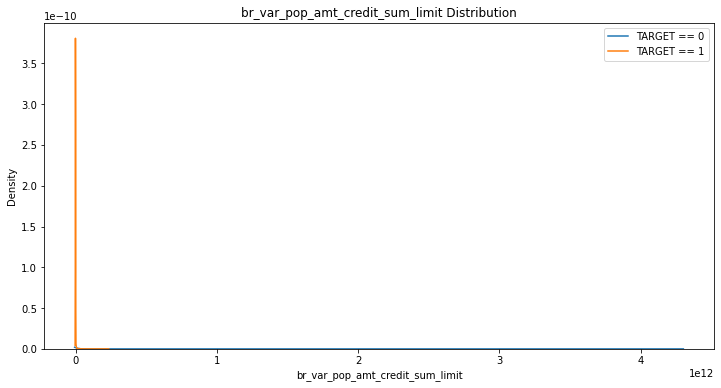

In [908]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum_limit', app_train)

In [909]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_pop_amt_credit_sum_limit')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_pop_amt_credit_sum_limit  
0  52.715068                     0.000000e+00  
1  49.490411                     0.000000e+00  
2  54.898630                     0.000000e+00  
3  38.290411                     5.984697e+08  
4  35.726027                     8.237335e+08  

[5 rows x 92 columns]

In [910]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [911]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [912]:
app_train['br_var_pop_amt_credit_sum_limit'].isnull().sum()

0

In [913]:
app_train[['TARGET', 'br_var_pop_amt_credit_sum_limit']].corr()

TARGET  br_var_pop_amt_credit_sum_limit
TARGET                           1.000000                        -0.004368
br_var_pop_amt_credit_sum_limit -0.004368                         1.000000

In [914]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_limit']].corr()

TARGET  br_var_pop_amt_credit_sum_limit
TARGET                           1.000000                        -0.014126
br_var_pop_amt_credit_sum_limit -0.014126                         1.000000

In [915]:
## 標準化
num_cols = ['br_var_pop_amt_credit_sum_limit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_pop_amt_credit_sum_limit', 'TARGET']].corr()

br_var_pop_amt_credit_sum_limit    TARGET
br_var_pop_amt_credit_sum_limit                         1.000000 -0.014126
TARGET                                                 -0.014126  1.000000

The correlation between br_var_pop_amt_credit_sum_limit and the TARGET is -0.0141
Median value for loan that was not repaid = 0.0617
Median value for loan that was repaid =     0.0748


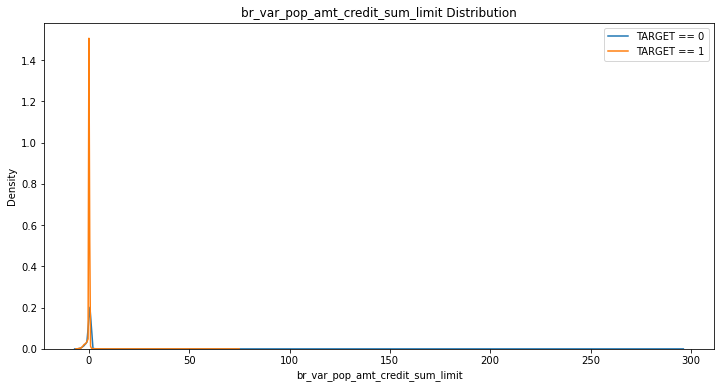

In [916]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_credit_sum_limit', app_train)

### br_var_samp_amt_credit_sum_limit

In [917]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_limit']].corr()

TARGET  br_var_samp_amt_credit_sum_limit
TARGET                            1.000000                         -0.005109
br_var_samp_amt_credit_sum_limit -0.005109                          1.000000

In [918]:
app_train['br_var_samp_amt_credit_sum_limit'].isnull().sum()

216533

The correlation between br_var_samp_amt_credit_sum_limit and the TARGET is -0.0051
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


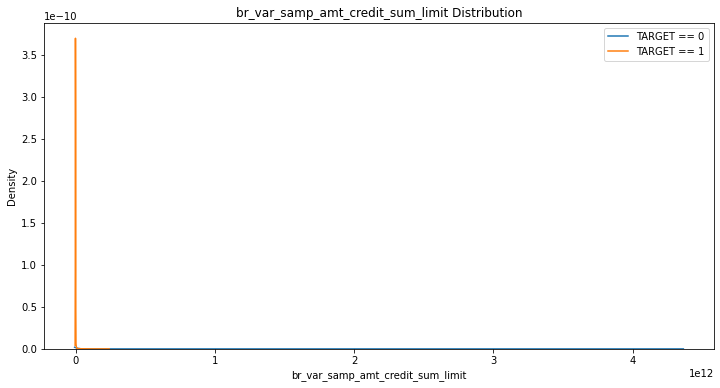

In [919]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum_limit', app_train)

In [920]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_samp_amt_credit_sum_limit')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_samp_amt_credit_sum_limit  
0  52.715068                      0.000000e+00  
1  49.490411                      0.000000e+00  
2  54.898630                      0.000000e+00  
3  38.290411                      6.026257e+08  
4  35.726027                      8.378070e+08  

[5 rows x 92 columns]

In [921]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [922]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [923]:
app_train['br_var_samp_amt_credit_sum_limit'].isnull().sum()

0

In [924]:
app_train[['TARGET', 'br_var_samp_amt_credit_sum_limit']].corr()

TARGET  br_var_samp_amt_credit_sum_limit
TARGET                            1.00000                          -0.00435
br_var_samp_amt_credit_sum_limit -0.00435                           1.00000

In [925]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_limit']].corr()

TARGET  br_var_samp_amt_credit_sum_limit
TARGET                            1.000000                         -0.014109
br_var_samp_amt_credit_sum_limit -0.014109                          1.000000

In [926]:
## 標準化
num_cols = ['br_var_samp_amt_credit_sum_limit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_samp_amt_credit_sum_limit', 'TARGET']].corr()

br_var_samp_amt_credit_sum_limit    TARGET
br_var_samp_amt_credit_sum_limit                          1.000000 -0.014109
TARGET                                                   -0.014109  1.000000

The correlation between br_var_samp_amt_credit_sum_limit and the TARGET is -0.0141
Median value for loan that was not repaid = 0.0620
Median value for loan that was repaid =     0.0751


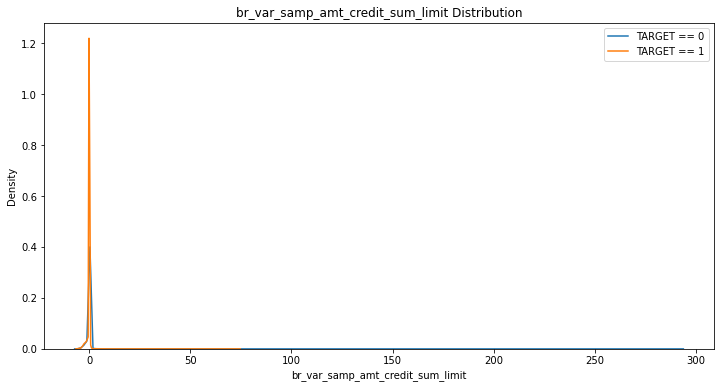

In [927]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_credit_sum_limit', app_train)

### br_variance_pop_amt_credit_sum_limit

In [928]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                                1.000000   
br_variance_pop_amt_credit_sum_limit -0.005146   

                                      br_variance_pop_amt_credit_sum_limit  
TARGET                                                           -0.005146  
br_variance_pop_amt_credit_sum_limit                              1.000000

In [929]:
app_train['br_variance_pop_amt_credit_sum_limit'].isnull().sum()

216533

The correlation between br_variance_pop_amt_credit_sum_limit and the TARGET is -0.0051
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


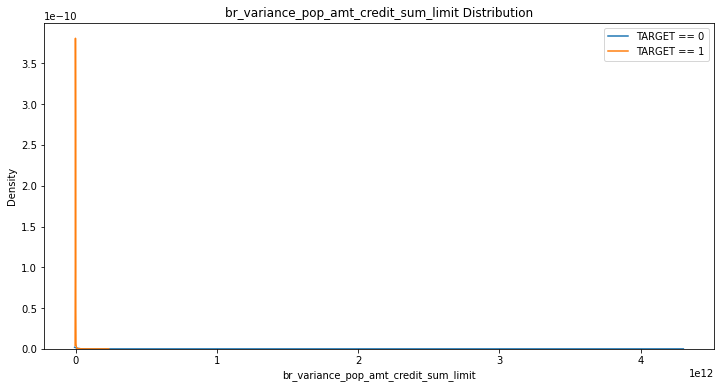

In [930]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_limit', app_train)

In [931]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_variance_pop_amt_credit_sum_limit')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_variance_pop_amt_credit_sum_limit  
0  52.715068                          0.000000e+00  
1  49.490411                          0.000000e+00  
2  54.898630                          0.000000e+00  
3  38.290411                          5.984697e+08  
4  35.726027                          8.237335e+08  

[5 rows x 92 columns]

In [932]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [933]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [934]:
app_train['br_variance_pop_amt_credit_sum_limit'].isnull().sum()

0

In [935]:
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                                1.000000   
br_variance_pop_amt_credit_sum_limit -0.004368   

                                      br_variance_pop_amt_credit_sum_limit  
TARGET                                                           -0.004368  
br_variance_pop_amt_credit_sum_limit                              1.000000

In [936]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                                1.000000   
br_variance_pop_amt_credit_sum_limit -0.014126   

                                      br_variance_pop_amt_credit_sum_limit  
TARGET                                                           -0.014126  
br_variance_pop_amt_credit_sum_limit                              1.000000

In [937]:
## 標準化
num_cols = ['br_variance_pop_amt_credit_sum_limit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_variance_pop_amt_credit_sum_limit', 'TARGET']].corr()

br_variance_pop_amt_credit_sum_limit  \
br_variance_pop_amt_credit_sum_limit                              1.000000   
TARGET                                                           -0.014126   

                                        TARGET  
br_variance_pop_amt_credit_sum_limit -0.014126  
TARGET                                1.000000

The correlation between br_variance_pop_amt_credit_sum_limit and the TARGET is -0.0141
Median value for loan that was not repaid = 0.0617
Median value for loan that was repaid =     0.0748


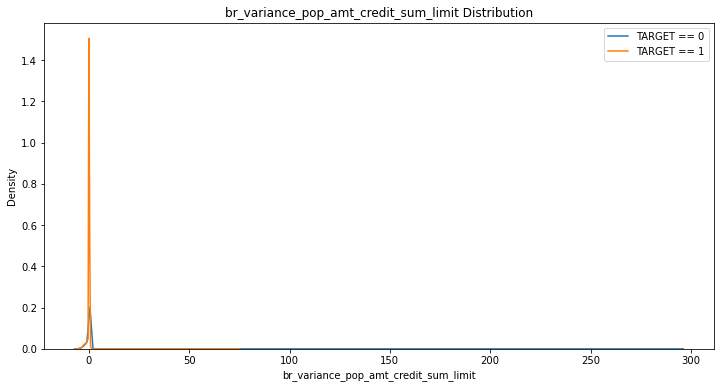

In [938]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_limit', app_train)

### br_min_amt_credit_sum_overdue

In [939]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_overdue']].corr()

TARGET  br_min_amt_credit_sum_overdue
TARGET                         1.000000                      -0.000761
br_min_amt_credit_sum_overdue -0.000761                       1.000000

In [940]:
app_train['br_min_amt_credit_sum_overdue'].isnull().sum()

216533

The correlation between br_min_amt_credit_sum_overdue and the TARGET is -0.0008
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


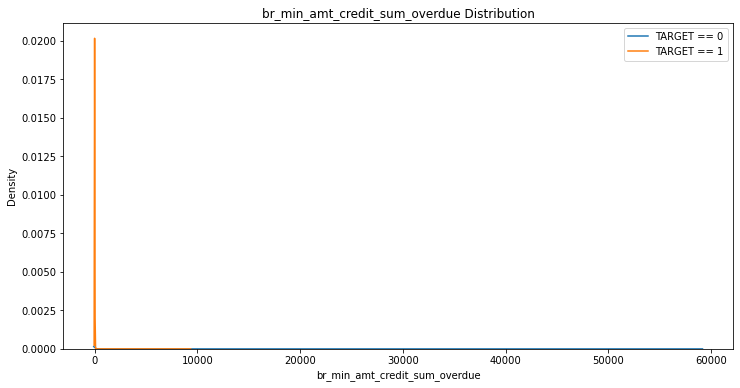

In [941]:
## 特徴量の分布
kde_target('br_min_amt_credit_sum_overdue', app_train)

In [942]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_min_amt_credit_sum_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_min_amt_credit_sum_overdue  
0  52.715068                       0.000000  
1  49.490411                       0.000000  
2  54.898630                       0.000000  
3  38.290411                       0.000000  
4  35.726027                      -0.855456  

[5 rows x 92 columns]

In [943]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [944]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [945]:
app_train['br_min_amt_credit_sum_overdue'].isnull().sum()

0

In [946]:
app_train[['TARGET', 'br_min_amt_credit_sum_overdue']].corr()

TARGET  br_min_amt_credit_sum_overdue
TARGET                         1.000000                       0.000752
br_min_amt_credit_sum_overdue  0.000752                       1.000000

In [947]:
## Yao-Johnson変換
num_cols = ['br_min_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_overdue']].corr()

TARGET  br_min_amt_credit_sum_overdue
TARGET                         1.000000                       0.059181
br_min_amt_credit_sum_overdue  0.059181                       1.000000

In [948]:
## 標準化
num_cols = ['br_min_amt_credit_sum_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_min_amt_credit_sum_overdue', 'TARGET']].corr()

br_min_amt_credit_sum_overdue    TARGET
br_min_amt_credit_sum_overdue                       1.000000  0.059181
TARGET                                              0.059181  1.000000

The correlation between br_min_amt_credit_sum_overdue and the TARGET is 0.0592
Median value for loan that was not repaid = 0.1823
Median value for loan that was repaid =     -0.1297


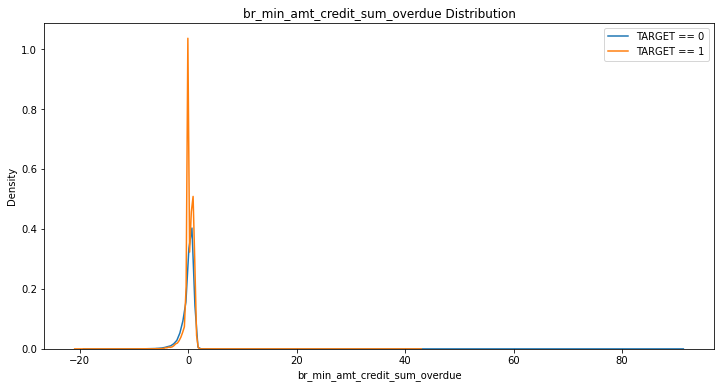

In [949]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_amt_credit_sum_overdue', app_train)

### br_max_amt_credit_sum_overdue

In [950]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_overdue']].corr()

TARGET  br_max_amt_credit_sum_overdue
TARGET                         1.000000                       0.018143
br_max_amt_credit_sum_overdue  0.018143                       1.000000

In [951]:
app_train['br_max_amt_credit_sum_overdue'].isnull().sum()

216533

The correlation between br_max_amt_credit_sum_overdue and the TARGET is 0.0181
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


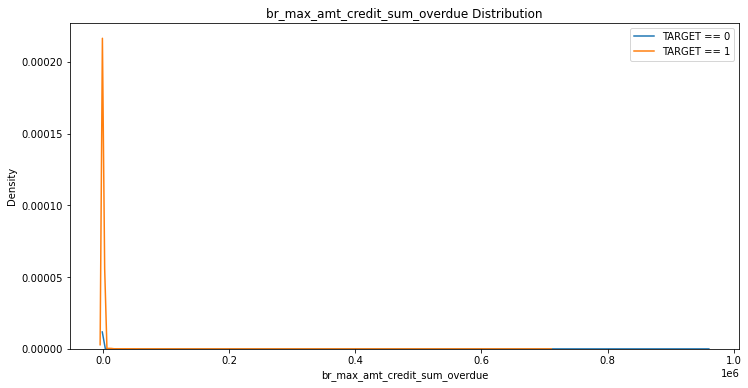

In [952]:
## 特徴量の分布
kde_target('br_max_amt_credit_sum_overdue', app_train)

In [953]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_max_amt_credit_sum_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_max_amt_credit_sum_overdue  
0  52.715068                        0.00000  
1  49.490411                        0.00000  
2  54.898630                        0.00000  
3  38.290411                        0.00000  
4  35.726027                       64.67556  

[5 rows x 92 columns]

In [954]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [955]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [956]:
app_train['br_max_amt_credit_sum_overdue'].isnull().sum()

0

In [957]:
app_train[['TARGET', 'br_max_amt_credit_sum_overdue']].corr()

TARGET  br_max_amt_credit_sum_overdue
TARGET                         1.000000                       0.010624
br_max_amt_credit_sum_overdue  0.010624                       1.000000

In [958]:
## Yao-Johnson変換
num_cols = ['br_max_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_overdue']].corr()

TARGET  br_max_amt_credit_sum_overdue
TARGET                         1.000000                       0.028439
br_max_amt_credit_sum_overdue  0.028439                       1.000000

In [959]:
## 標準化
num_cols = ['br_max_amt_credit_sum_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_max_amt_credit_sum_overdue', 'TARGET']].corr()

br_max_amt_credit_sum_overdue    TARGET
br_max_amt_credit_sum_overdue                       1.000000  0.028439
TARGET                                              0.028439  1.000000

The correlation between br_max_amt_credit_sum_overdue and the TARGET is 0.0284
Median value for loan that was not repaid = 0.1757
Median value for loan that was repaid =     0.1290


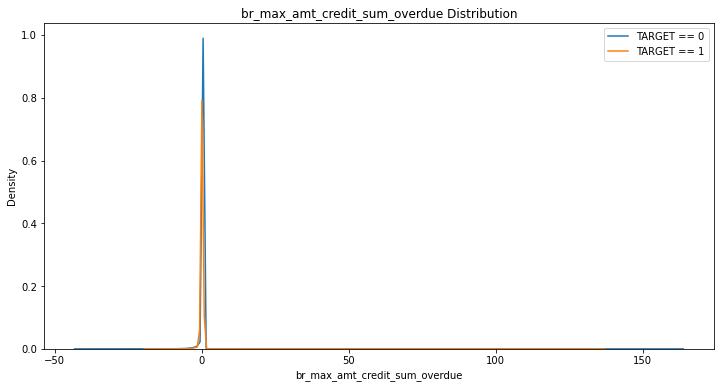

In [960]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_amt_credit_sum_overdue', app_train)

### br_sum_amt_credit_sum_overdue

In [961]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_overdue']].corr()

TARGET  br_sum_amt_credit_sum_overdue
TARGET                         1.000000                       0.006905
br_sum_amt_credit_sum_overdue  0.006905                       1.000000

In [962]:
app_train['br_sum_amt_credit_sum_overdue'].isnull().sum()

216533

The correlation between br_sum_amt_credit_sum_overdue and the TARGET is 0.0069
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


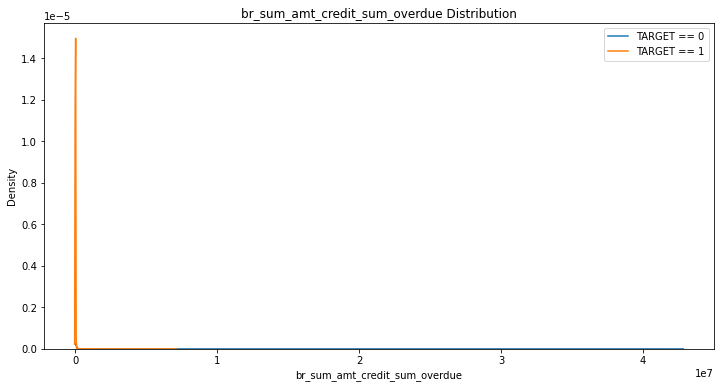

In [963]:
## 特徴量の分布
kde_target('br_sum_amt_credit_sum_overdue', app_train)

In [964]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_sum_amt_credit_sum_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [965]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [966]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [967]:
#app_train['br_sum_amt_credit_sum_overdue'].isnull().sum()

In [968]:
#app_train[['TARGET', 'br_sum_amt_credit_sum_overdue']].corr()

In [969]:
## Yao-Johnson変換
#num_cols = ['br_sum_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_sum_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_sum_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_sum_amt_credit_sum_overdue']].corr()

In [970]:
## 標準化
#num_cols = ['br_sum_amt_credit_sum_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_sum_amt_credit_sum_overdue', 'TARGET']].corr()

In [971]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_sum_amt_credit_sum_overdue', app_train)

In [972]:
columns = ['br_sum_amt_credit_sum_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_avg_amt_credit_sum_overdue

In [973]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_overdue']].corr()

TARGET  br_avg_amt_credit_sum_overdue
TARGET                         1.000000                       0.019531
br_avg_amt_credit_sum_overdue  0.019531                       1.000000

In [974]:
app_train['br_avg_amt_credit_sum_overdue'].isnull().sum()

216533

The correlation between br_avg_amt_credit_sum_overdue and the TARGET is 0.0195
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


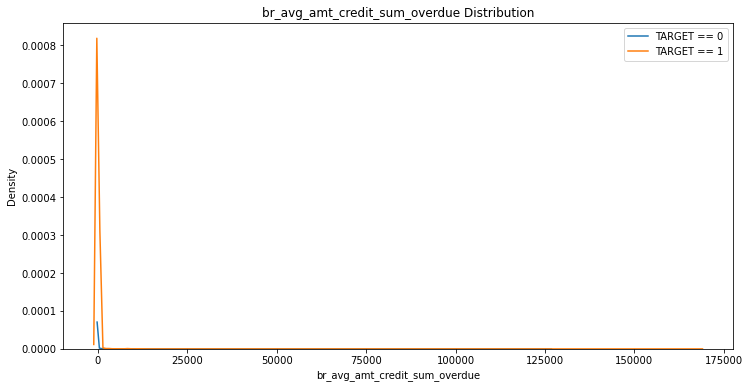

In [975]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum_overdue', app_train)

In [976]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_amt_credit_sum_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_avg_amt_credit_sum_overdue  
0  52.715068                       0.000000  
1  49.490411                       0.000000  
2  54.898630                       0.000000  
3  38.290411                       0.000000  
4  35.726027                      16.791365  

[5 rows x 92 columns]

In [977]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [978]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [979]:
app_train['br_avg_amt_credit_sum_overdue'].isnull().sum()

0

In [980]:
app_train[['TARGET', 'br_avg_amt_credit_sum_overdue']].corr()

TARGET  br_avg_amt_credit_sum_overdue
TARGET                         1.000000                       0.011694
br_avg_amt_credit_sum_overdue  0.011694                       1.000000

In [981]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_overdue']].corr()

TARGET  br_avg_amt_credit_sum_overdue
TARGET                         1.000000                       0.038493
br_avg_amt_credit_sum_overdue  0.038493                       1.000000

In [982]:
## 標準化
num_cols = ['br_avg_amt_credit_sum_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_amt_credit_sum_overdue', 'TARGET']].corr()

br_avg_amt_credit_sum_overdue    TARGET
br_avg_amt_credit_sum_overdue                       1.000000  0.038493
TARGET                                              0.038493  1.000000

The correlation between br_avg_amt_credit_sum_overdue and the TARGET is 0.0385
Median value for loan that was not repaid = 0.2433
Median value for loan that was repaid =     0.1407


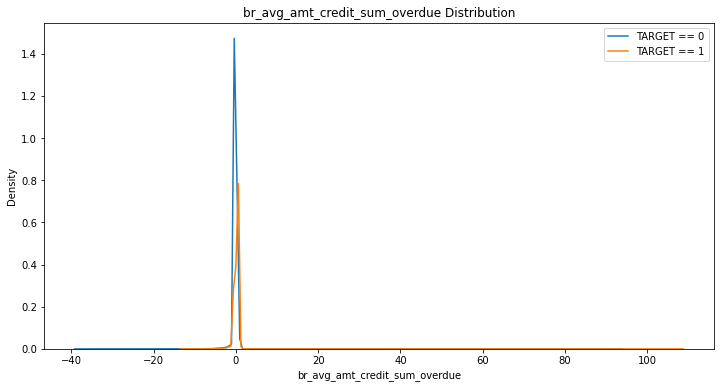

In [983]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_sum_overdue', app_train)

### br_cnt_amt_credit_sum_overdue

In [984]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_overdue']].corr()

TARGET  br_cnt_amt_credit_sum_overdue
TARGET                         1.000000                      -0.024241
br_cnt_amt_credit_sum_overdue -0.024241                       1.000000

In [985]:
app_train['br_cnt_amt_credit_sum_overdue'].isnull().sum()

216533

The correlation between br_cnt_amt_credit_sum_overdue and the TARGET is -0.0242
Median value for loan that was not repaid = 55.0000
Median value for loan that was repaid =     63.0000


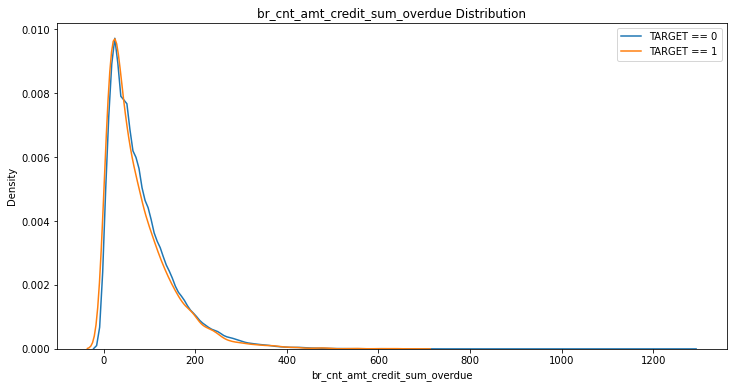

In [986]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum_overdue', app_train)

In [987]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_amt_credit_sum_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_amt_credit_sum_overdue  
0  52.715068                     132.000000  
1  49.490411                      21.000000  
2  54.898630                     100.000000  
3  38.290411                     270.000000  
4  35.726027                     117.972317  

[5 rows x 92 columns]

In [988]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [989]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [990]:
app_train['br_cnt_amt_credit_sum_overdue'].isnull().sum()

0

In [991]:
app_train[['TARGET', 'br_cnt_amt_credit_sum_overdue']].corr()

TARGET  br_cnt_amt_credit_sum_overdue
TARGET                         1.000000                      -0.027994
br_cnt_amt_credit_sum_overdue -0.027994                       1.000000

In [992]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_overdue']].corr()

TARGET  br_cnt_amt_credit_sum_overdue
TARGET                         1.000000                      -0.037745
br_cnt_amt_credit_sum_overdue -0.037745                       1.000000

In [993]:
## 標準化
num_cols = ['br_cnt_amt_credit_sum_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_amt_credit_sum_overdue', 'TARGET']].corr()

br_cnt_amt_credit_sum_overdue    TARGET
br_cnt_amt_credit_sum_overdue                       1.000000 -0.037745
TARGET                                             -0.037745  1.000000

The correlation between br_cnt_amt_credit_sum_overdue and the TARGET is -0.0377
Median value for loan that was not repaid = -0.0742
Median value for loan that was repaid =     0.0408


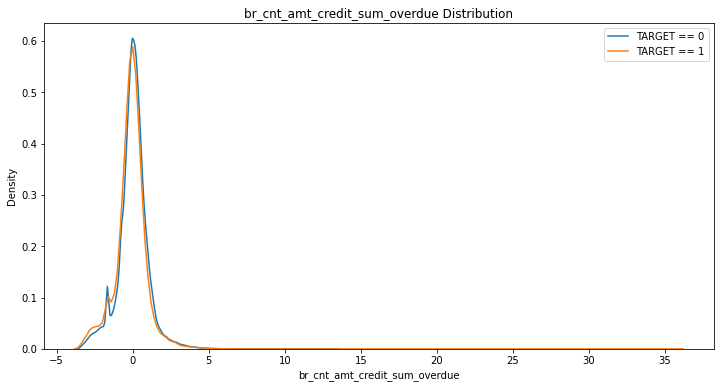

In [994]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum_overdue', app_train)

### br_stddev_amt_credit_sum_overdue

In [995]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_overdue']].corr()

TARGET  br_stddev_amt_credit_sum_overdue
TARGET                            1.000000                          0.019463
br_stddev_amt_credit_sum_overdue  0.019463                          1.000000

In [996]:
app_train['br_stddev_amt_credit_sum_overdue'].isnull().sum()

216533

The correlation between br_stddev_amt_credit_sum_overdue and the TARGET is 0.0195
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


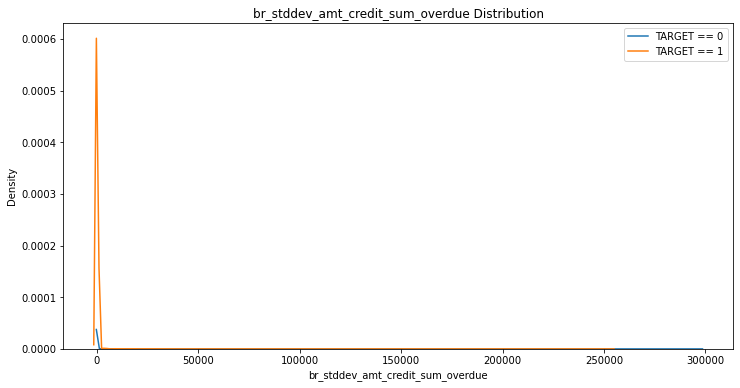

In [997]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum_overdue', app_train)

In [998]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_amt_credit_sum_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_amt_credit_sum_overdue  
0  52.715068                          0.000000  
1  49.490411                          0.000000  
2  54.898630                          0.000000  
3  38.290411                          0.000000  
4  35.726027                         18.255252  

[5 rows x 92 columns]

In [999]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1000]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1001]:
app_train['br_stddev_amt_credit_sum_overdue'].isnull().sum()

0

In [1002]:
app_train[['TARGET', 'br_stddev_amt_credit_sum_overdue']].corr()

TARGET  br_stddev_amt_credit_sum_overdue
TARGET                            1.000000                          0.011372
br_stddev_amt_credit_sum_overdue  0.011372                          1.000000

In [1003]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_overdue']].corr()

TARGET  br_stddev_amt_credit_sum_overdue
TARGET                            1.000000                          0.032462
br_stddev_amt_credit_sum_overdue  0.032462                          1.000000

In [1004]:
## 標準化
num_cols = ['br_stddev_amt_credit_sum_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_amt_credit_sum_overdue', 'TARGET']].corr()

br_stddev_amt_credit_sum_overdue    TARGET
br_stddev_amt_credit_sum_overdue                          1.000000  0.032462
TARGET                                                    0.032462  1.000000

The correlation between br_stddev_amt_credit_sum_overdue and the TARGET is 0.0325
Median value for loan that was not repaid = 0.2167
Median value for loan that was repaid =     0.1493


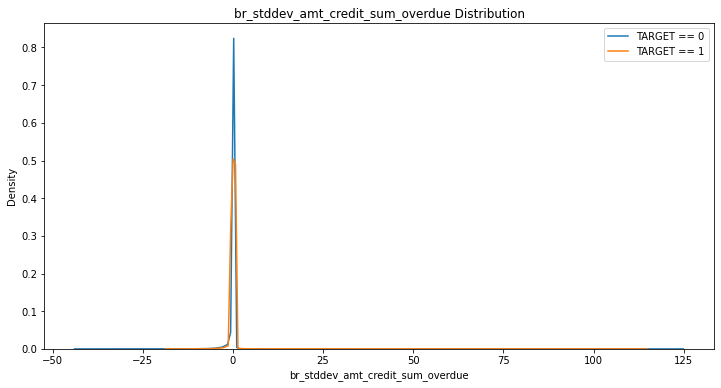

In [1005]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_amt_credit_sum_overdue', app_train)

### br_stddev_pop_amt_credit_sum_overdue

In [1006]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                1.000000   
br_stddev_pop_amt_credit_sum_overdue  0.019463   

                                      br_stddev_pop_amt_credit_sum_overdue  
TARGET                                                            0.019463  
br_stddev_pop_amt_credit_sum_overdue                              1.000000

In [1007]:
app_train['br_stddev_pop_amt_credit_sum_overdue'].isnull().sum()

216533

The correlation between br_stddev_pop_amt_credit_sum_overdue and the TARGET is 0.0195
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


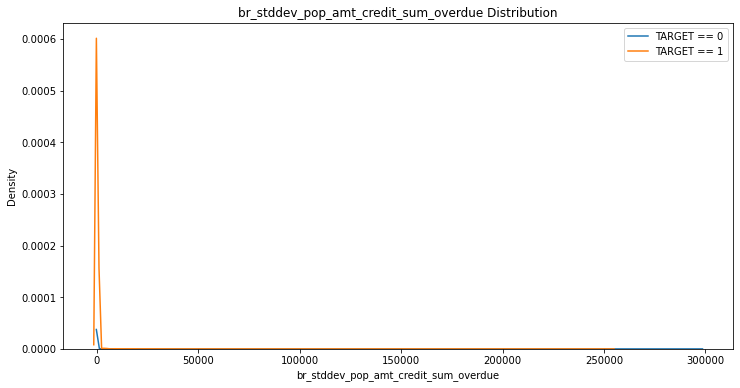

In [1008]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_overdue', app_train)

In [1009]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_amt_credit_sum_overdue')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_pop_amt_credit_sum_overdue  
0  52.715068                              0.000000  
1  49.490411                              0.000000  
2  54.898630                              0.000000  
3  38.290411                              0.000000  
4  35.726027                             18.255252  

[5 rows x 92 columns]

In [1010]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1011]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1012]:
app_train['br_stddev_pop_amt_credit_sum_overdue'].isnull().sum()

0

In [1013]:
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                1.000000   
br_stddev_pop_amt_credit_sum_overdue  0.011372   

                                      br_stddev_pop_amt_credit_sum_overdue  
TARGET                                                            0.011372  
br_stddev_pop_amt_credit_sum_overdue                              1.000000

In [1014]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                1.000000   
br_stddev_pop_amt_credit_sum_overdue  0.032462   

                                      br_stddev_pop_amt_credit_sum_overdue  
TARGET                                                            0.032462  
br_stddev_pop_amt_credit_sum_overdue                              1.000000

In [1015]:
## 標準化
num_cols = ['br_stddev_pop_amt_credit_sum_overdue']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_pop_amt_credit_sum_overdue', 'TARGET']].corr()

br_stddev_pop_amt_credit_sum_overdue  \
br_stddev_pop_amt_credit_sum_overdue                              1.000000   
TARGET                                                            0.032462   

                                        TARGET  
br_stddev_pop_amt_credit_sum_overdue  0.032462  
TARGET                                1.000000

The correlation between br_stddev_pop_amt_credit_sum_overdue and the TARGET is 0.0325
Median value for loan that was not repaid = 0.2167
Median value for loan that was repaid =     0.1493


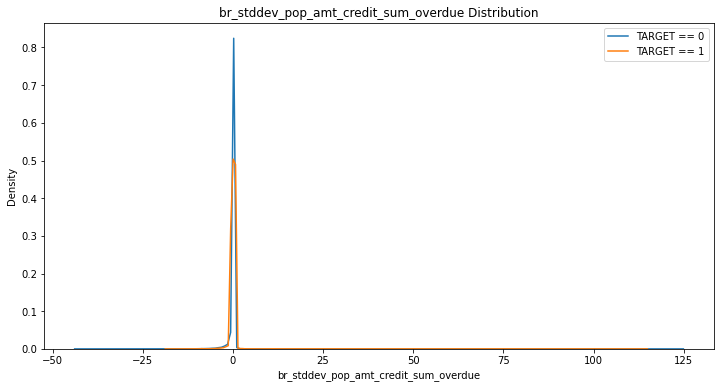

In [1016]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_overdue', app_train)

### br_var_pop_amt_credit_sum_overdue

In [1017]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_overdue']].corr()

TARGET  br_var_pop_amt_credit_sum_overdue
TARGET                             1.000000                           0.006835
br_var_pop_amt_credit_sum_overdue  0.006835                           1.000000

In [1018]:
app_train['br_var_pop_amt_credit_sum_overdue'].isnull().sum()

216533

The correlation between br_var_pop_amt_credit_sum_overdue and the TARGET is 0.0068
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


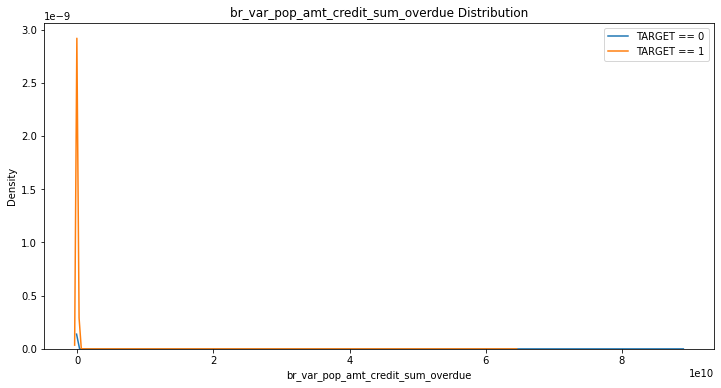

In [1019]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum_overdue', app_train)

In [1020]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_pop_amt_credit_sum_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1021]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1022]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1023]:
#app_train['br_var_pop_amt_credit_sum_overdue'].isnull().sum()

In [1024]:
#app_train[['TARGET', 'br_var_pop_amt_credit_sum_overdue']].corr()

In [1025]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_overdue']].corr()

TARGET  br_var_pop_amt_credit_sum_overdue
TARGET                             1.000000                           0.006835
br_var_pop_amt_credit_sum_overdue  0.006835                           1.000000

In [1026]:
## 標準化
#num_cols = ['br_var_pop_amt_credit_sum_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_pop_amt_credit_sum_overdue', 'TARGET']].corr()

In [1027]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_pop_amt_credit_sum_overdue', app_train)

In [1028]:
columns = ['br_var_pop_amt_credit_sum_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_samp_amt_credit_sum_overdue

In [1029]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_var_samp_amt_credit_sum_overdue  0.006937   

                                    br_var_samp_amt_credit_sum_overdue  
TARGET                                                        0.006937  
br_var_samp_amt_credit_sum_overdue                            1.000000

In [1030]:
app_train['br_var_samp_amt_credit_sum_overdue'].isnull().sum()

216533

The correlation between br_var_samp_amt_credit_sum_overdue and the TARGET is 0.0069
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


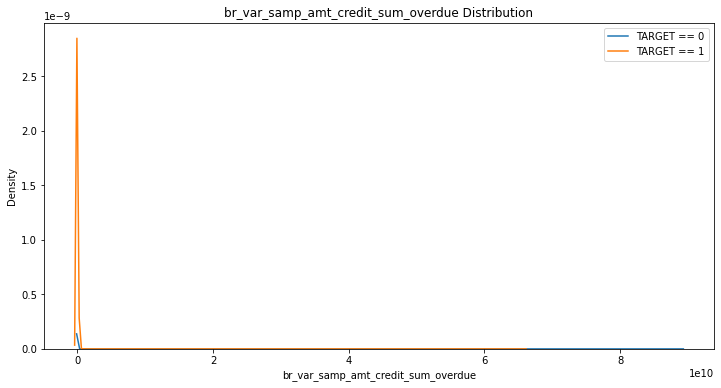

In [1031]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum_overdue', app_train)

In [1032]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_samp_amt_credit_sum_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1033]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1034]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1035]:
#app_train['br_var_samp_amt_credit_sum_overdue'].isnull().sum()

In [1036]:
#app_train[['TARGET', 'br_var_samp_amt_credit_sum_overdue']].corr()

In [1037]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_amt_credit_sum_overdue']].corr()

In [1038]:
## 標準化
#num_cols = ['br_var_samp_amt_credit_sum_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_samp_amt_credit_sum_overdue', 'TARGET']].corr()

In [1039]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_amt_credit_sum_overdue', app_train)

In [1040]:
columns = ['br_var_samp_amt_credit_sum_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_variance_pop_amt_credit_sum_overdue

In [1041]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                  1.000000   
br_variance_pop_amt_credit_sum_overdue  0.006835   

                                        br_variance_pop_amt_credit_sum_overdue  
TARGET                                                                0.006835  
br_variance_pop_amt_credit_sum_overdue                                1.000000

In [1042]:
app_train['br_variance_pop_amt_credit_sum_overdue'].isnull().sum()

216533

The correlation between br_variance_pop_amt_credit_sum_overdue and the TARGET is 0.0068
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


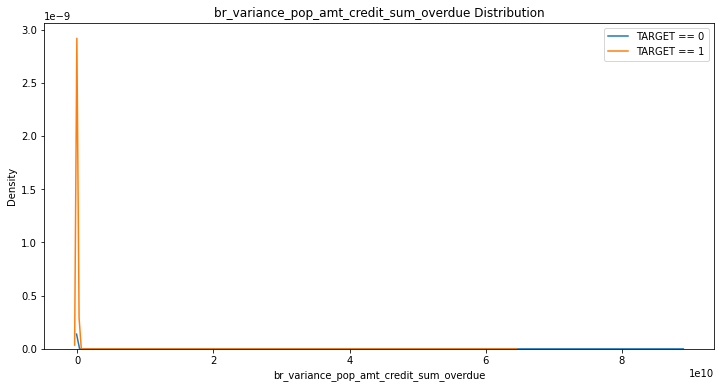

In [1043]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_overdue', app_train)

In [1044]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_variance_pop_amt_credit_sum_overdue')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1045]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1046]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1047]:
#app_train['br_variance_pop_amt_credit_sum_overdue'].isnull().sum()

In [1048]:
#app_train[['TARGET', 'br_variance_pop_amt_credit_sum_overdue']].corr()

In [1049]:
## Yao-Johnson変換
#num_cols = ['br_variance_pop_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_variance_pop_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_variance_pop_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_variance_pop_amt_credit_sum_overdue']].corr()

In [1050]:
## 標準化
#num_cols = ['br_variance_pop_amt_credit_sum_overdue']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_variance_pop_amt_credit_sum_overdue', 'TARGET']].corr()

In [1051]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_variance_pop_amt_credit_sum_overdue', app_train)

In [1052]:
columns = ['br_variance_pop_amt_credit_sum_overdue']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_min_days_credit_update

In [1053]:
## 目的変数との相関
app_train[['TARGET', 'br_min_days_credit_update']].corr()

TARGET  br_min_days_credit_update
TARGET                     1.000000                   0.048775
br_min_days_credit_update  0.048775                   1.000000

In [1054]:
app_train['br_min_days_credit_update'].isnull().sum()

216533

The correlation between br_min_days_credit_update and the TARGET is 0.0488
Median value for loan that was not repaid = -629.0000
Median value for loan that was repaid =     -800.0000


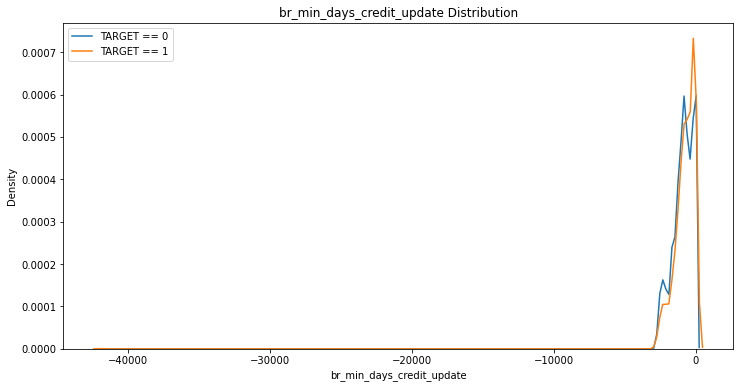

In [1055]:
## 特徴量の分布
kde_target('br_min_days_credit_update', app_train)

In [1056]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_min_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_min_days_credit_update  
0  52.715068                -155.000000  
1  49.490411                -121.000000  
2  54.898630               -1334.000000  
3  38.290411               -1564.000000  
4  35.726027               -1091.548924  

[5 rows x 92 columns]

In [1057]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1058]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1059]:
app_train['br_min_days_credit_update'].isnull().sum()

0

In [1060]:
app_train[['TARGET', 'br_min_days_credit_update']].corr()

TARGET  br_min_days_credit_update
TARGET                     1.000000                   0.072447
br_min_days_credit_update  0.072447                   1.000000

In [1061]:
## Yao-Johnson変換
num_cols = ['br_min_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_min_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_days_credit_update']].corr()

TARGET  br_min_days_credit_update
TARGET                     1.00000                    0.08127
br_min_days_credit_update  0.08127                    1.00000

In [1062]:
## 標準化
num_cols = ['br_min_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_min_days_credit_update', 'TARGET']].corr()

br_min_days_credit_update   TARGET
br_min_days_credit_update                    1.00000  0.08127
TARGET                                       0.08127  1.00000

The correlation between br_min_days_credit_update and the TARGET is 0.0813
Median value for loan that was not repaid = 0.1970
Median value for loan that was repaid =     -0.1017


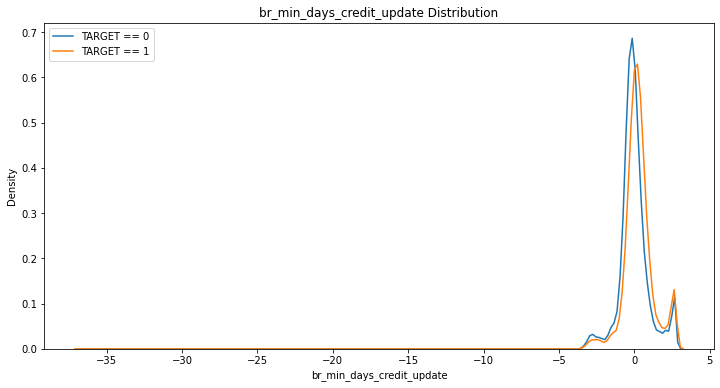

In [1063]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_days_credit_update', app_train)

### br_max_days_credit_update

In [1064]:
## 目的変数との相関
app_train[['TARGET', 'br_max_days_credit_update']].corr()

TARGET  br_max_days_credit_update
TARGET                     1.000000                   0.029381
br_max_days_credit_update  0.029381                   1.000000

In [1065]:
app_train[['TARGET', 'br_max_days_credit_update']].corr()

TARGET  br_max_days_credit_update
TARGET                     1.000000                   0.029381
br_max_days_credit_update  0.029381                   1.000000

The correlation between br_max_days_credit_update and the TARGET is 0.0294
Median value for loan that was not repaid = -13.0000
Median value for loan that was repaid =     -17.0000


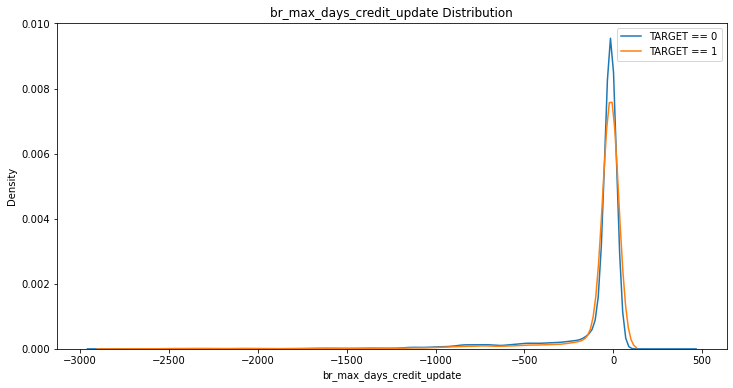

In [1066]:
## 特徴量の分布
kde_target('br_max_days_credit_update', app_train)

In [1067]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_max_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_max_days_credit_update  
0  52.715068                  -6.000000  
1  49.490411                 -11.000000  
2  54.898630                  -4.000000  
3  38.290411                 -20.000000  
4  35.726027                -120.828352  

[5 rows x 92 columns]

In [1068]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1069]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1070]:
app_train['br_max_days_credit_update'].isnull().sum()

0

In [1071]:
app_train[['TARGET', 'br_max_days_credit_update']].corr()

TARGET  br_max_days_credit_update
TARGET                     1.000000                   0.054271
br_max_days_credit_update  0.054271                   1.000000

In [1072]:
## Yao-Johnson変換
num_cols = ['br_max_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_max_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_days_credit_update']].corr()

TARGET  br_max_days_credit_update
TARGET                     1.000000                   0.055531
br_max_days_credit_update  0.055531                   1.000000

In [1073]:
## 標準化
num_cols = ['br_max_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_max_days_credit_update', 'TARGET']].corr()

br_max_days_credit_update    TARGET
br_max_days_credit_update                   1.000000  0.055531
TARGET                                      0.055531  1.000000

The correlation between br_max_days_credit_update and the TARGET is 0.0555
Median value for loan that was not repaid = 0.2906
Median value for loan that was repaid =     0.0604


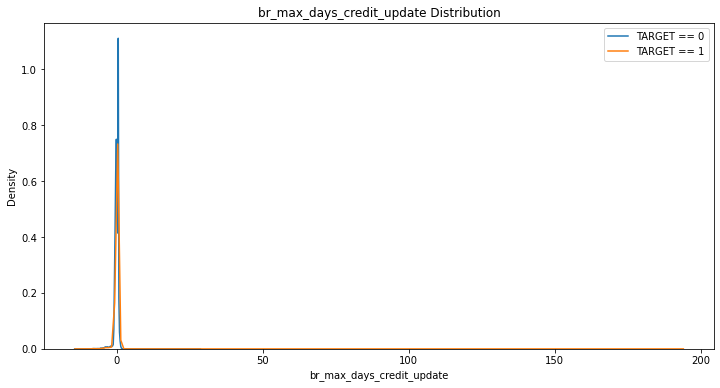

In [1074]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_days_credit_update', app_train)

### br_sum_days_credit_update

In [1075]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_days_credit_update']].corr()

TARGET  br_sum_days_credit_update
TARGET                     1.000000                   0.046297
br_sum_days_credit_update  0.046297                   1.000000

In [1076]:
app_train['br_sum_days_credit_update'].isnull().sum()

216533

The correlation between br_sum_days_credit_update and the TARGET is 0.0463
Median value for loan that was not repaid = -17227.5000
Median value for loan that was repaid =     -26124.0000


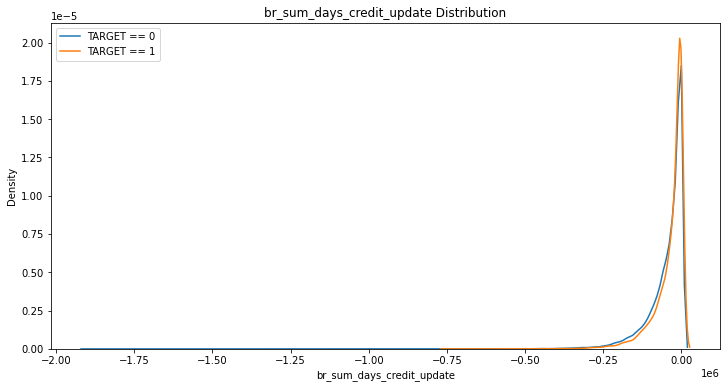

In [1077]:
## 特徴量の分布
kde_target('br_sum_days_credit_update', app_train)

In [1078]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_sum_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_sum_days_credit_update  
0  52.715068              -15756.000000  
1  49.490411               -1721.000000  
2  54.898630              -77550.000000  
3  38.290411             -193156.000000  
4  35.726027              -80176.274315  

[5 rows x 92 columns]

In [1079]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1080]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1081]:
app_train['br_sum_days_credit_update'].isnull().sum()

0

In [1082]:
app_train[['TARGET', 'br_sum_days_credit_update']].corr()

TARGET  br_sum_days_credit_update
TARGET                     1.000000                   0.046914
br_sum_days_credit_update  0.046914                   1.000000

In [1083]:
## Yao-Johnson変換
num_cols = ['br_sum_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_sum_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_days_credit_update']].corr()

TARGET  br_sum_days_credit_update
TARGET                     1.000000                   0.053189
br_sum_days_credit_update  0.053189                   1.000000

In [1084]:
## 標準化
num_cols = ['br_sum_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_sum_days_credit_update', 'TARGET']].corr()

br_sum_days_credit_update    TARGET
br_sum_days_credit_update                   1.000000  0.053189
TARGET                                      0.053189  1.000000

The correlation between br_sum_days_credit_update and the TARGET is 0.0532
Median value for loan that was not repaid = 0.1471
Median value for loan that was repaid =     -0.0242


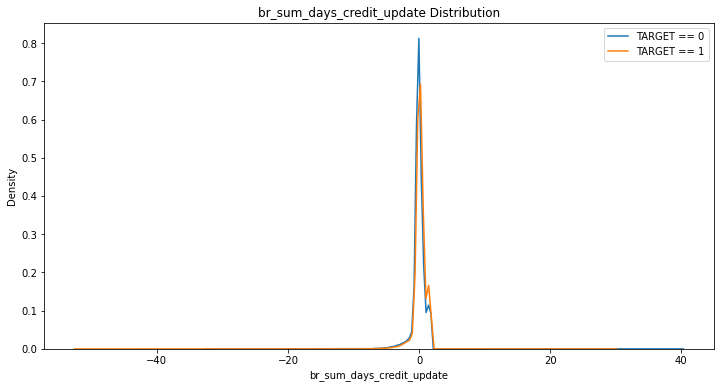

In [1085]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_days_credit_update', app_train)

### br_avg_days_credit_update

In [1086]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_days_credit_update']].corr()

TARGET  br_avg_days_credit_update
TARGET                     1.000000                   0.061194
br_avg_days_credit_update  0.061194                   1.000000

In [1087]:
app_train['br_avg_days_credit_update'].isnull().sum()

216533

The correlation between br_avg_days_credit_update and the TARGET is 0.0612
Median value for loan that was not repaid = -281.9670
Median value for loan that was repaid =     -394.4927


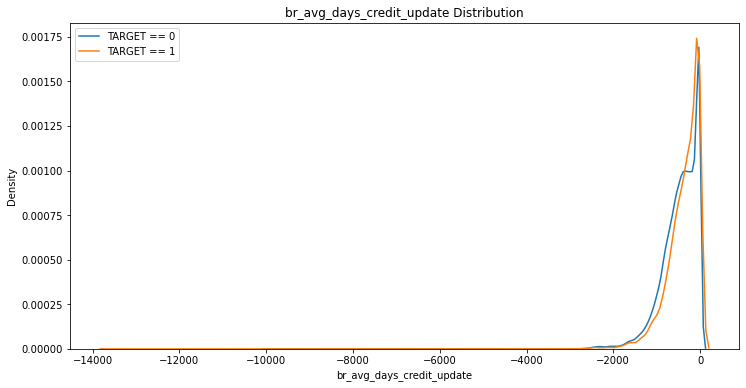

In [1088]:
## 特徴量の分布
kde_target('br_avg_days_credit_update', app_train)

In [1089]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_avg_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_avg_days_credit_update  
0  52.715068                -119.363600  
1  49.490411                 -81.952400  
2  54.898630                -775.500000  
3  38.290411                -715.392600  
4  35.726027                -563.629238  

[5 rows x 92 columns]

In [1090]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1091]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1092]:
app_train['br_avg_days_credit_update'].isnull().sum()

0

In [1093]:
app_train[['TARGET', 'br_avg_days_credit_update']].corr()

TARGET  br_avg_days_credit_update
TARGET                     1.00000                    0.09252
br_avg_days_credit_update  0.09252                    1.00000

In [1094]:
## Yao-Johnson変換
num_cols = ['br_avg_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_avg_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_days_credit_update']].corr()

TARGET  br_avg_days_credit_update
TARGET                     1.0000                     0.0937
br_avg_days_credit_update  0.0937                     1.0000

In [1095]:
## 標準化
num_cols = ['br_avg_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_avg_days_credit_update', 'TARGET']].corr()

br_avg_days_credit_update  TARGET
br_avg_days_credit_update                     1.0000  0.0937
TARGET                                        0.0937  1.0000

The correlation between br_avg_days_credit_update and the TARGET is 0.0937
Median value for loan that was not repaid = 0.3184
Median value for loan that was repaid =     -0.0459


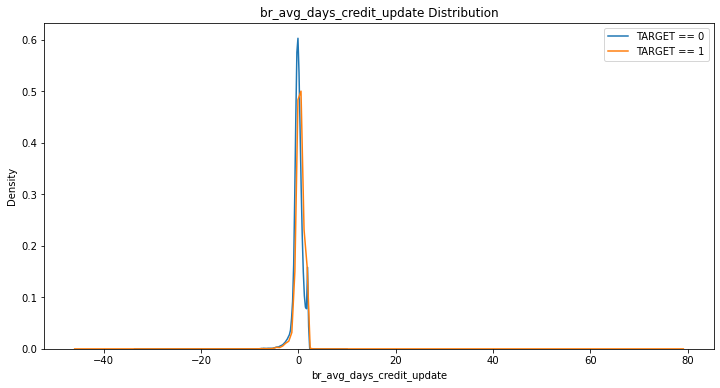

In [1096]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_days_credit_update', app_train)

### br_cnt_days_credit_update

In [1097]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_days_credit_update']].corr()

TARGET  br_cnt_days_credit_update
TARGET                     1.000000                  -0.024241
br_cnt_days_credit_update -0.024241                   1.000000

In [1098]:
app_train['br_cnt_days_credit_update'].isnull().sum()

216533

The correlation between br_cnt_days_credit_update and the TARGET is -0.0242
Median value for loan that was not repaid = 55.0000
Median value for loan that was repaid =     63.0000


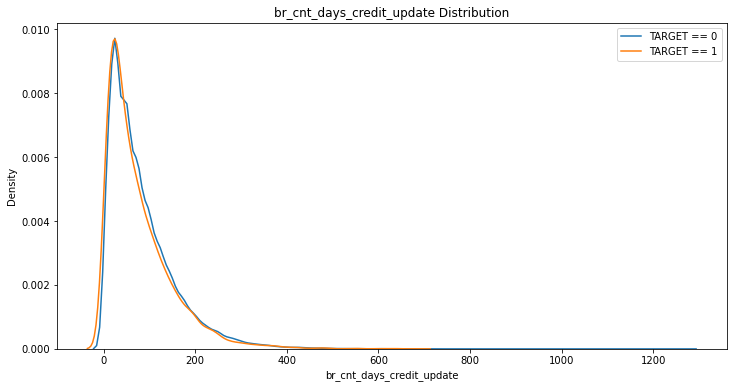

In [1099]:
## 特徴量の分布
kde_target('br_cnt_days_credit_update', app_train)

In [1100]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_days_credit_update  
0  52.715068                 132.000000  
1  49.490411                  21.000000  
2  54.898630                 100.000000  
3  38.290411                 270.000000  
4  35.726027                 117.972317  

[5 rows x 92 columns]

In [1101]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1102]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1103]:
app_train['br_cnt_days_credit_update'].isnull().sum()

0

In [1104]:
app_train[['TARGET', 'br_cnt_days_credit_update']].corr()

TARGET  br_cnt_days_credit_update
TARGET                     1.000000                  -0.027994
br_cnt_days_credit_update -0.027994                   1.000000

In [1105]:
## Yao-Johnson変換
num_cols = ['br_cnt_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_cnt_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_days_credit_update']].corr()

TARGET  br_cnt_days_credit_update
TARGET                     1.000000                  -0.037745
br_cnt_days_credit_update -0.037745                   1.000000

In [1106]:
## 標準化
num_cols = ['br_cnt_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_days_credit_update', 'TARGET']].corr()

br_cnt_days_credit_update    TARGET
br_cnt_days_credit_update                   1.000000 -0.037745
TARGET                                     -0.037745  1.000000

The correlation between br_cnt_days_credit_update and the TARGET is -0.0377
Median value for loan that was not repaid = -0.0742
Median value for loan that was repaid =     0.0408


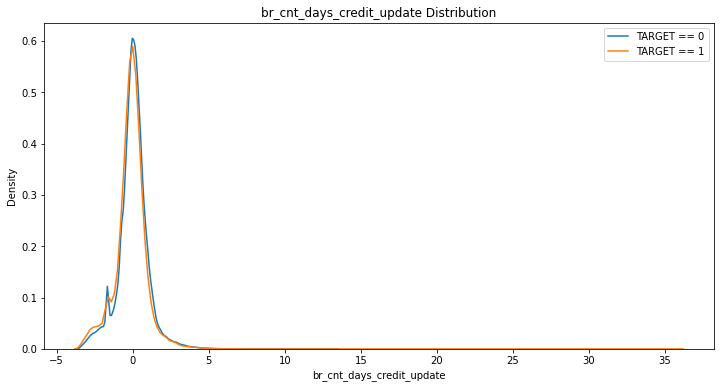

In [1107]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_days_credit_update', app_train)

### br_stddev_days_credit_update

In [1108]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_days_credit_update']].corr()

TARGET  br_stddev_days_credit_update
TARGET                        1.000000                     -0.038239
br_stddev_days_credit_update -0.038239                      1.000000

In [1109]:
app_train['br_stddev_days_credit_update'].isnull().sum()

216533

The correlation between br_stddev_days_credit_update and the TARGET is -0.0382
Median value for loan that was not repaid = 198.8473
Median value for loan that was repaid =     251.0194


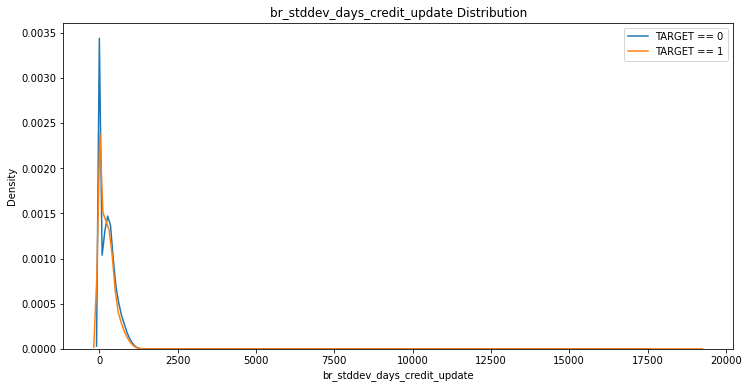

In [1110]:
## 特徴量の分布
kde_target('br_stddev_days_credit_update', app_train)

In [1111]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_days_credit_update  
0  52.715068                     63.011696  
1  49.490411                     50.133608  
2  54.898630                    536.562438  
3  38.290411                    460.573895  
4  35.726027                    358.699967  

[5 rows x 92 columns]

In [1112]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1113]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1114]:
app_train['br_stddev_days_credit_update'].isnull().sum()

0

In [1115]:
app_train[['TARGET', 'br_stddev_days_credit_update']].corr()

TARGET  br_stddev_days_credit_update
TARGET                        1.000000                     -0.052744
br_stddev_days_credit_update -0.052744                      1.000000

In [1116]:
## Yao-Johnson変換
num_cols = ['br_stddev_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_stddev_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_days_credit_update']].corr()

TARGET  br_stddev_days_credit_update
TARGET                        1.000000                     -0.058413
br_stddev_days_credit_update -0.058413                      1.000000

In [1117]:
## 標準化
num_cols = ['br_stddev_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_days_credit_update', 'TARGET']].corr()

br_stddev_days_credit_update    TARGET
br_stddev_days_credit_update                      1.000000 -0.058413
TARGET                                           -0.058413  1.000000

The correlation between br_stddev_days_credit_update and the TARGET is -0.0584
Median value for loan that was not repaid = -0.1038
Median value for loan that was repaid =     0.1099


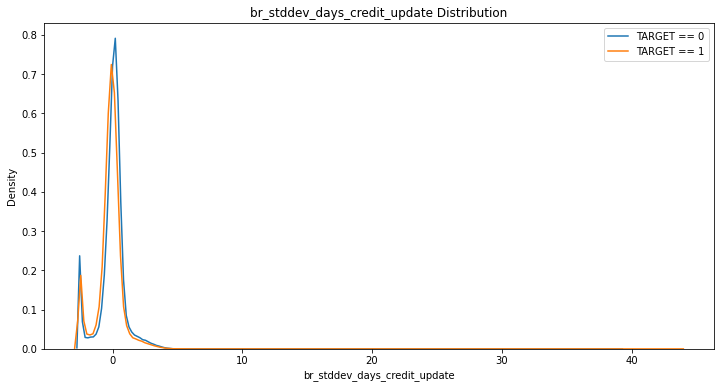

In [1118]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_days_credit_update', app_train)

### br_stddev_pop_days_credit_update

In [1119]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_days_credit_update']].corr()

TARGET  br_stddev_pop_days_credit_update
TARGET                            1.000000                         -0.038239
br_stddev_pop_days_credit_update -0.038239                          1.000000

In [1120]:
app_train['br_stddev_pop_days_credit_update'].isnull().sum()

216533

The correlation between br_stddev_pop_days_credit_update and the TARGET is -0.0382
Median value for loan that was not repaid = 198.8473
Median value for loan that was repaid =     251.0194


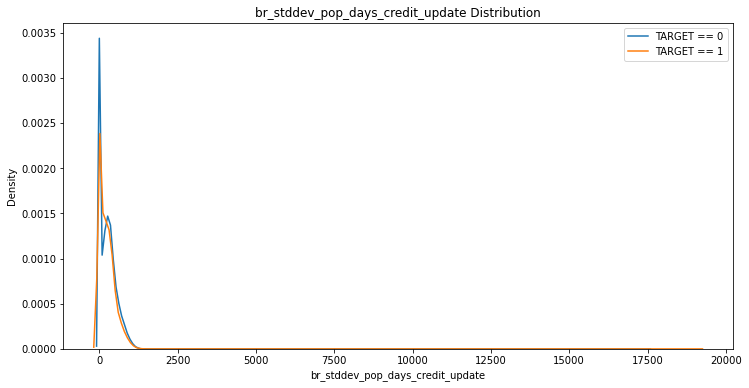

In [1121]:
## 特徴量の分布
kde_target('br_stddev_pop_days_credit_update', app_train)

In [1122]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_stddev_pop_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_stddev_pop_days_credit_update  
0  52.715068                         63.011696  
1  49.490411                         50.133608  
2  54.898630                        536.562438  
3  38.290411                        460.573895  
4  35.726027                        358.699967  

[5 rows x 92 columns]

In [1123]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1124]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1125]:
app_train['br_stddev_pop_days_credit_update'].isnull().sum()

0

In [1126]:
app_train[['TARGET', 'br_stddev_pop_days_credit_update']].corr()

TARGET  br_stddev_pop_days_credit_update
TARGET                            1.000000                         -0.052744
br_stddev_pop_days_credit_update -0.052744                          1.000000

In [1127]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_days_credit_update']].corr()

TARGET  br_stddev_pop_days_credit_update
TARGET                            1.000000                         -0.058413
br_stddev_pop_days_credit_update -0.058413                          1.000000

In [1128]:
## 標準化
num_cols = ['br_stddev_pop_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_stddev_pop_days_credit_update', 'TARGET']].corr()

br_stddev_pop_days_credit_update    TARGET
br_stddev_pop_days_credit_update                          1.000000 -0.058413
TARGET                                                   -0.058413  1.000000

The correlation between br_stddev_pop_days_credit_update and the TARGET is -0.0584
Median value for loan that was not repaid = -0.1038
Median value for loan that was repaid =     0.1099


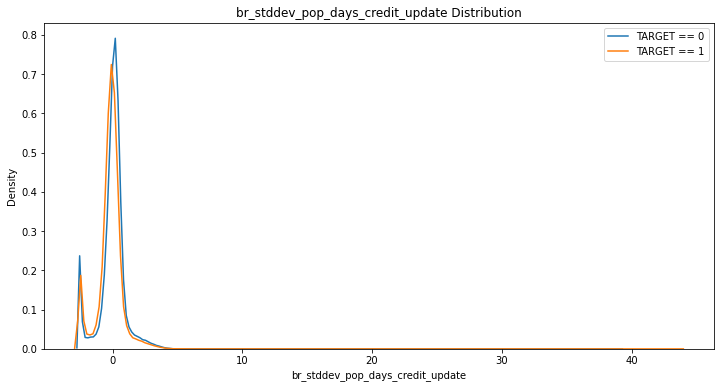

In [1129]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_days_credit_update', app_train)

### br_var_pop_days_credit_update

In [1130]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_days_credit_update']].corr()

TARGET  br_var_pop_days_credit_update
TARGET                         1.000000                       0.003555
br_var_pop_days_credit_update  0.003555                       1.000000

In [1131]:
app_train['br_var_pop_days_credit_update'].isnull().sum()

216533

The correlation between br_var_pop_days_credit_update and the TARGET is 0.0036
Median value for loan that was not repaid = 39540.2523
Median value for loan that was repaid =     63010.7163


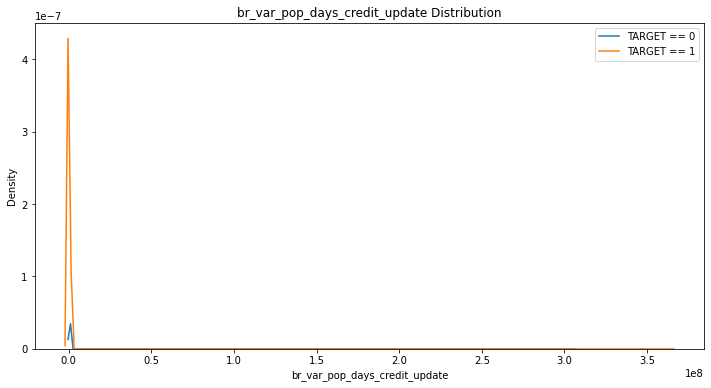

In [1132]:
## 特徴量の分布
kde_target('br_var_pop_days_credit_update', app_train)

In [1133]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_pop_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_pop_days_credit_update  
0  52.715068                    3970.473829  
1  49.490411                    2513.378685  
2  54.898630                  287899.250000  
3  38.290411                  212128.312538  
4  35.726027                  194602.994284  

[5 rows x 92 columns]

In [1134]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1135]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1136]:
app_train['br_var_pop_days_credit_update'].isnull().sum()

0

In [1137]:
app_train[['TARGET', 'br_var_pop_days_credit_update']].corr()

TARGET  br_var_pop_days_credit_update
TARGET                         1.000000                       0.000022
br_var_pop_days_credit_update  0.000022                       1.000000

In [1138]:
## Yao-Johnson変換
num_cols = ['br_var_pop_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_days_credit_update']].corr()

TARGET  br_var_pop_days_credit_update
TARGET                         1.00000                       -0.01792
br_var_pop_days_credit_update -0.01792                        1.00000

In [1139]:
## 標準化
num_cols = ['br_var_pop_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_pop_days_credit_update', 'TARGET']].corr()

br_var_pop_days_credit_update   TARGET
br_var_pop_days_credit_update                        1.00000 -0.01792
TARGET                                              -0.01792  1.00000

The correlation between br_var_pop_days_credit_update and the TARGET is -0.0179
Median value for loan that was not repaid = -0.0104
Median value for loan that was repaid =     0.0503


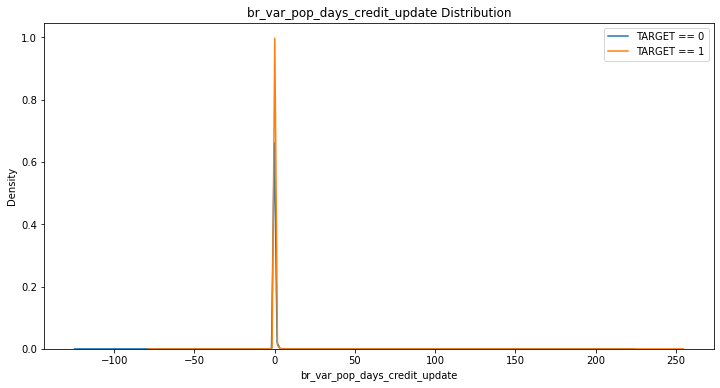

In [1140]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_days_credit_update', app_train)

### br_var_samp_days_credit_update

In [1141]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_days_credit_update']].corr()

TARGET  br_var_samp_days_credit_update
TARGET                          1.000000                        0.003714
br_var_samp_days_credit_update  0.003714                        1.000000

In [1142]:
app_train['br_var_samp_days_credit_update'].isnull().sum()

216533

The correlation between br_var_samp_days_credit_update and the TARGET is 0.0037
Median value for loan that was not repaid = 40247.6835
Median value for loan that was repaid =     64219.9164


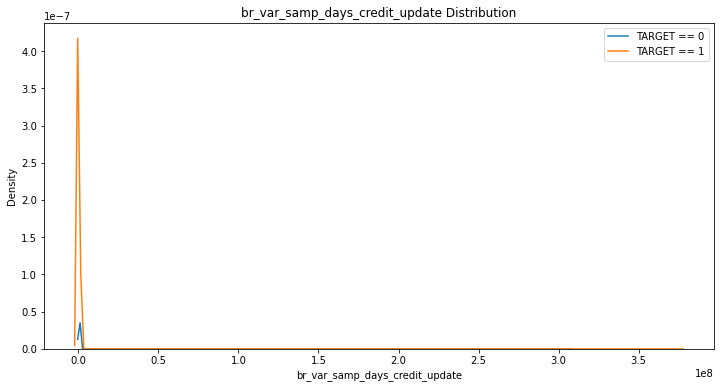

In [1143]:
## 特徴量の分布
kde_target('br_var_samp_days_credit_update', app_train)

In [1144]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_var_samp_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_var_samp_days_credit_update  
0  52.715068                     4000.782790  
1  49.490411                     2639.047619  
2  54.898630                   290807.323232  
3  38.290411                   212916.893625  
4  35.726027                   196324.777391  

[5 rows x 92 columns]

In [1145]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1146]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1147]:
app_train['br_var_samp_days_credit_update'].isnull().sum()

0

In [1148]:
app_train[['TARGET', 'br_var_samp_days_credit_update']].corr()

TARGET  br_var_samp_days_credit_update
TARGET                          1.000000                        0.000155
br_var_samp_days_credit_update  0.000155                        1.000000

In [1149]:
## Yao-Johnson変換
num_cols = ['br_var_samp_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_days_credit_update']].corr()

TARGET  br_var_samp_days_credit_update
TARGET                          1.000000                       -0.017947
br_var_samp_days_credit_update -0.017947                        1.000000

In [1150]:
## 標準化
num_cols = ['br_var_samp_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_var_samp_days_credit_update', 'TARGET']].corr()

br_var_samp_days_credit_update    TARGET
br_var_samp_days_credit_update                        1.000000 -0.017947
TARGET                                               -0.017947  1.000000

The correlation between br_var_samp_days_credit_update and the TARGET is -0.0179
Median value for loan that was not repaid = -0.0090
Median value for loan that was repaid =     0.0514


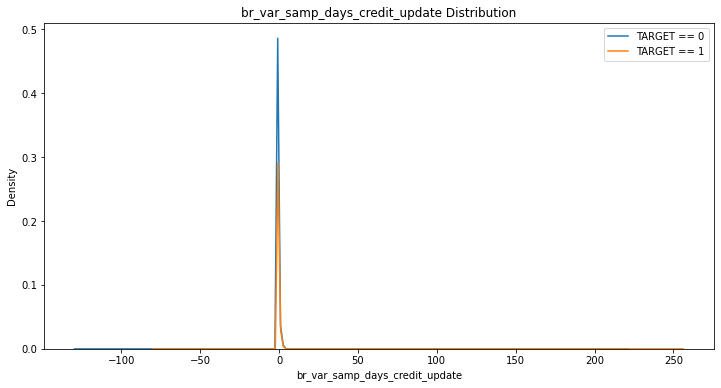

In [1151]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_days_credit_update', app_train)

### br_variance_pop_days_credit_update

In [1152]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_days_credit_update']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_days_credit_update  0.003555   

                                    br_variance_pop_days_credit_update  
TARGET                                                        0.003555  
br_variance_pop_days_credit_update                            1.000000

In [1153]:
app_train['br_variance_pop_days_credit_update'].isnull().sum()

216533

The correlation between br_variance_pop_days_credit_update and the TARGET is 0.0036
Median value for loan that was not repaid = 39540.2523
Median value for loan that was repaid =     63010.7163


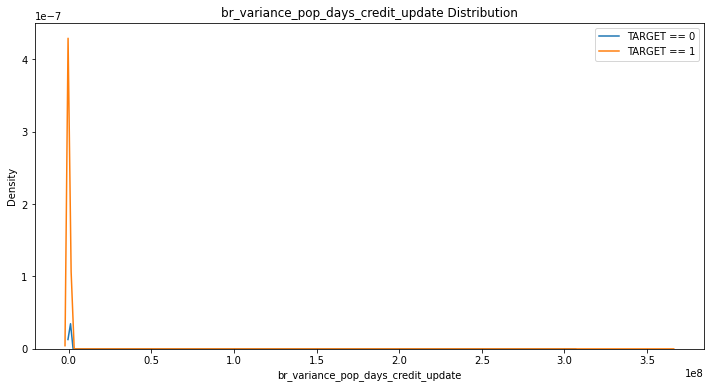

In [1154]:
## 特徴量の分布
kde_target('br_variance_pop_days_credit_update', app_train)

In [1155]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_variance_pop_days_credit_update')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_variance_pop_days_credit_update  
0  52.715068                         3970.473829  
1  49.490411                         2513.378685  
2  54.898630                       287899.250000  
3  38.290411                       212128.312538  
4  35.726027                       194602.994284  

[5 rows x 92 columns]

In [1156]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1157]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1158]:
app_train['br_variance_pop_days_credit_update'].isnull().sum()

0

In [1159]:
app_train[['TARGET', 'br_variance_pop_days_credit_update']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_days_credit_update  0.000022   

                                    br_variance_pop_days_credit_update  
TARGET                                                        0.000022  
br_variance_pop_days_credit_update                            1.000000

In [1160]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_days_credit_update'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_days_credit_update']].corr()

TARGET  \
TARGET                              1.00000   
br_variance_pop_days_credit_update -0.01792   

                                    br_variance_pop_days_credit_update  
TARGET                                                        -0.01792  
br_variance_pop_days_credit_update                             1.00000

In [1161]:
## 標準化
num_cols = ['br_variance_pop_days_credit_update']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_variance_pop_days_credit_update', 'TARGET']].corr()

br_variance_pop_days_credit_update  \
br_variance_pop_days_credit_update                             1.00000   
TARGET                                                        -0.01792   

                                     TARGET  
br_variance_pop_days_credit_update -0.01792  
TARGET                              1.00000

The correlation between br_variance_pop_days_credit_update and the TARGET is -0.0179
Median value for loan that was not repaid = -0.0104
Median value for loan that was repaid =     0.0503


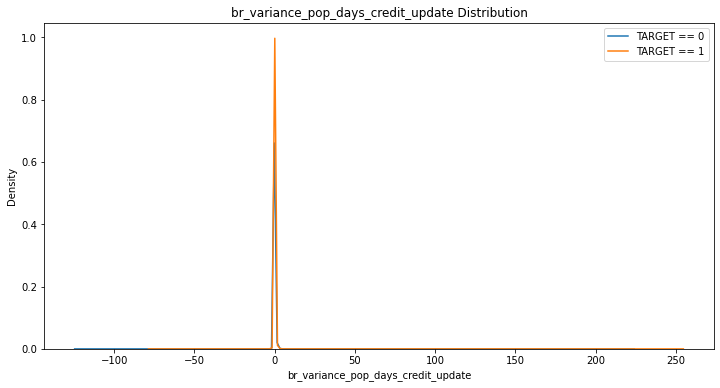

In [1162]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_days_credit_update', app_train)

### br_min_amt_annuity

In [1163]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_annuity']].corr()

TARGET  br_min_amt_annuity
TARGET              1.000000           -0.001539
br_min_amt_annuity -0.001539            1.000000

In [1164]:
app_train['br_min_amt_annuity'].isnull().sum()

275932

The correlation between br_min_amt_annuity and the TARGET is -0.0015
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


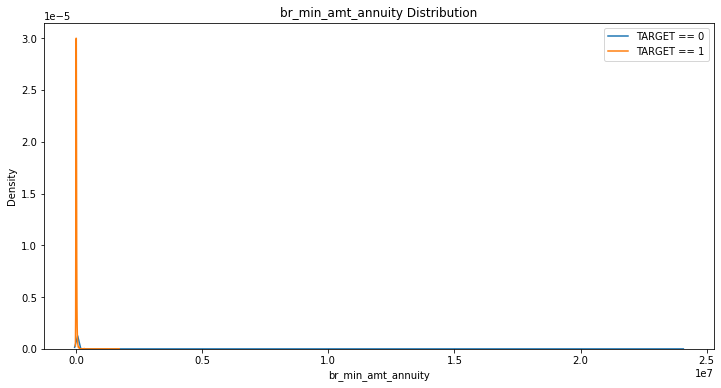

In [1165]:
## 特徴量の分布
kde_target('br_min_amt_annuity', app_train)

In [1166]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_min_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1167]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1168]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1169]:
#app_train['br_min_amt_annuity'].isnull().sum()

In [1170]:
#app_train[['TARGET', 'br_min_amt_annuity']].corr()

In [1171]:
## Yao-Johnson変換
#num_cols = ['br_min_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_min_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_min_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_min_amt_annuity']].corr()

In [1172]:
## 標準化
#num_cols = ['br_min_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_min_amt_annuity', 'TARGET']].corr()

In [1173]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_min_amt_annuity', app_train)

In [1174]:
columns = ['br_min_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_max_amt_annuity

In [1175]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_annuity']].corr()

TARGET  br_max_amt_annuity
TARGET              1.000000            0.003079
br_max_amt_annuity  0.003079            1.000000

In [1176]:
app_train['br_max_amt_annuity'].isnull().sum()

229775

The correlation between br_max_amt_annuity and the TARGET is 0.0031
Median value for loan that was not repaid = 8235.0000
Median value for loan that was repaid =     7933.5000


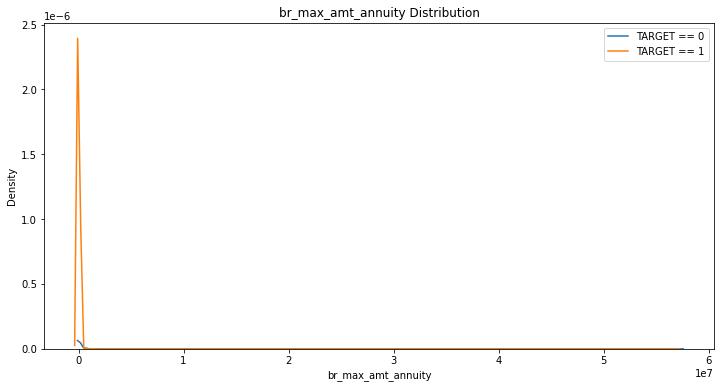

In [1177]:
## 特徴量の分布
kde_target('br_max_amt_annuity', app_train)

In [1178]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_max_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1179]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1180]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1181]:
#app_train['br_max_amt_annuity'].isnull().sum()

In [1182]:
#app_train[['TARGET', 'br_max_amt_annuity']].corr()

In [1183]:
## Yao-Johnson変換
#num_cols = ['br_max_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_max_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_amt_annuity']].corr()

In [1184]:
## 標準化
#num_cols = ['br_max_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_max_amt_annuity', 'TARGET']].corr()

In [1185]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_amt_annuity', app_train)

In [1186]:
columns = ['br_max_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_sum_amt_annuity

In [1187]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_annuity']].corr()

TARGET  br_sum_amt_annuity
TARGET              1.000000           -0.001238
br_sum_amt_annuity -0.001238            1.000000

In [1188]:
app_train['br_sum_amt_annuity'].isnull().sum()

216533

The correlation between br_sum_amt_annuity and the TARGET is -0.0012
Median value for loan that was not repaid = 118626.7500
Median value for loan that was repaid =     95575.0050


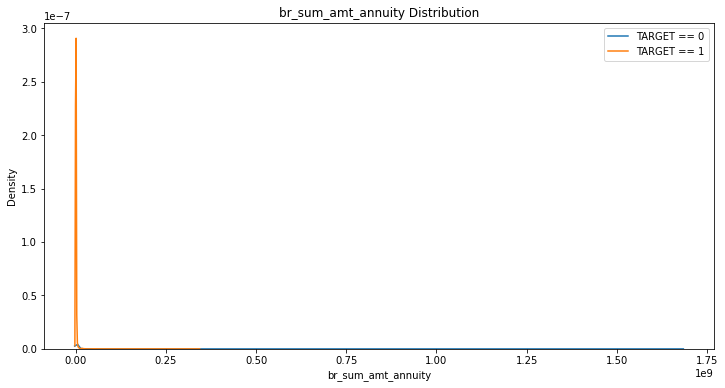

In [1189]:
## 特徴量の分布
kde_target('br_sum_amt_annuity', app_train)

In [1190]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_sum_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1191]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1192]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1193]:
#app_train['br_sum_amt_annuity'].isnull().sum()

In [1194]:
#app_train[['TARGET', 'br_sum_amt_annuity']].corr()

In [1195]:
## Yao-Johnson変換
#num_cols = ['br_sum_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_sum_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_sum_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_sum_amt_annuity']].corr()

In [1196]:
## 標準化
#num_cols = ['br_sum_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_sum_amt_annuity', 'TARGET']].corr()

In [1197]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_sum_amt_annuity', app_train)

In [1198]:
columns = ['br_sum_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_avg_amt_annuity

In [1199]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_annuity']].corr()

TARGET  br_avg_amt_annuity
TARGET              1.000000           -0.000707
br_avg_amt_annuity -0.000707            1.000000

In [1200]:
app_train['br_avg_amt_annuity'].isnull().sum()

216533

The correlation between br_avg_amt_annuity and the TARGET is -0.0007
Median value for loan that was not repaid = 2790.3886
Median value for loan that was repaid =     1759.8182


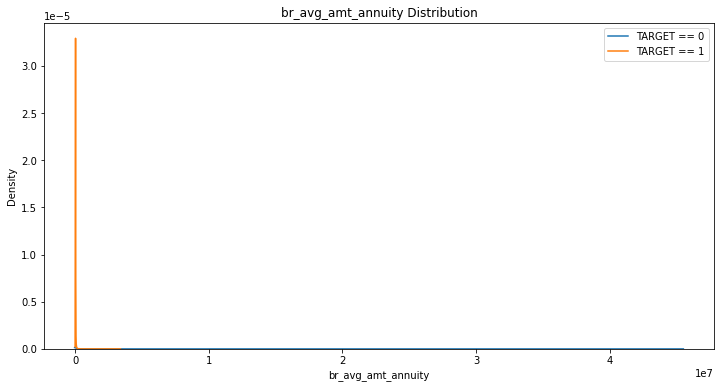

In [1201]:
## 特徴量の分布
kde_target('br_avg_amt_annuity', app_train)

In [1202]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_avg_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1203]:
# 欠損値を補完した列を再結合
#app_rain[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1204]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1205]:
#app_train['br_avg_amt_annuity'].isnull().sum()

In [1206]:
#app_train[['TARGET', 'br_avg_amt_annuity']].corr()

In [1207]:
## Yao-Johnson変換
#num_cols = ['br_avg_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_avg_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_avg_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_avg_amt_annuity']].corr()

In [1209]:
## 標準化
#num_cols = ['br_avg_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_avg_amt_annuity', 'TARGET']].corr()

In [1210]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_avg_amt_annuity', app_train)

In [1211]:
columns = ['br_avg_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_cnt_amt_annuity

In [1212]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_annuity']].corr()

TARGET  br_cnt_amt_annuity
TARGET              1.000000           -0.024241
br_cnt_amt_annuity -0.024241            1.000000

In [1213]:
app_train['br_cnt_amt_annuity'].isnull().sum()

216533

The correlation between br_cnt_amt_annuity and the TARGET is -0.0242
Median value for loan that was not repaid = 55.0000
Median value for loan that was repaid =     63.0000


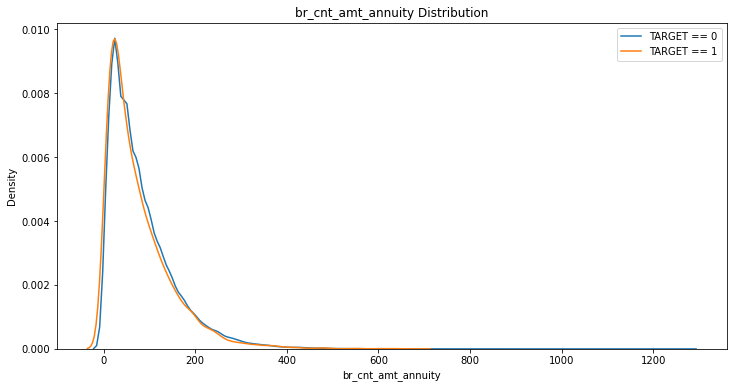

In [1214]:
## 特徴量の分布
kde_target('br_cnt_amt_annuity', app_train)

In [1215]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('br_cnt_amt_annuity')

app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  br_cnt_amt_annuity  
0  52.715068          132.000000  
1  49.490411           21.000000  
2  54.898630          100.000000  
3  38.290411          270.000000  
4  35.726027          117.972317  

[5 rows x 92 columns]

In [1216]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1217]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1218]:
app_train['br_cnt_amt_annuity'].isnull().sum()

0

In [1219]:
app_train[['TARGET', 'br_cnt_amt_annuity']].corr()

TARGET  br_cnt_amt_annuity
TARGET              1.000000           -0.027994
br_cnt_amt_annuity -0.027994            1.000000

In [1220]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_annuity']].corr()

TARGET  br_cnt_amt_annuity
TARGET              1.000000           -0.037745
br_cnt_amt_annuity -0.037745            1.000000

In [1221]:
## 標準化
num_cols = ['br_cnt_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['br_cnt_amt_annuity', 'TARGET']].corr()

br_cnt_amt_annuity    TARGET
br_cnt_amt_annuity            1.000000 -0.037745
TARGET                       -0.037745  1.000000

The correlation between br_cnt_amt_annuity and the TARGET is -0.0377
Median value for loan that was not repaid = -0.0742
Median value for loan that was repaid =     0.0408


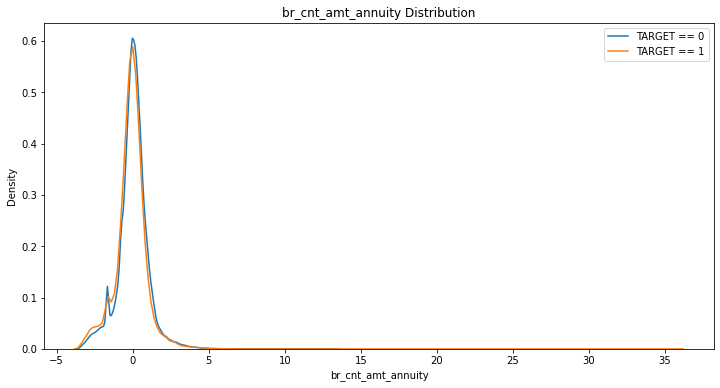

In [1222]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_annuity', app_train)

### br_stddev_amt_annuity

In [1223]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_annuity']].corr()

TARGET  br_stddev_amt_annuity
TARGET                 1.000000               0.001385
br_stddev_amt_annuity  0.001385               1.000000

In [1224]:
app_train['br_stddev_amt_annuity'].isnull().sum()

216533

The correlation between br_stddev_amt_annuity and the TARGET is 0.0014
Median value for loan that was not repaid = 1471.8765
Median value for loan that was repaid =     0.0000


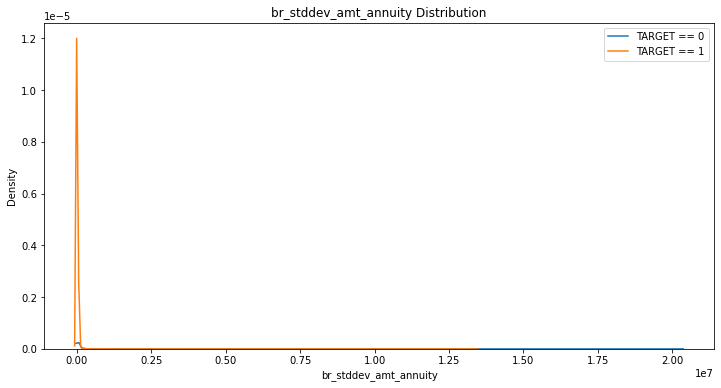

In [1225]:
## 特徴量の分布
kde_target('br_stddev_amt_annuity', app_train)

In [1226]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1227]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1228]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1229]:
#app_train['br_stddev_amt_annuity'].isnull().sum()

In [1230]:
#app_train[['TARGET', 'br_stddev_amt_annuity']].corr()

In [1231]:
## Yao-Johnson変換
#num_cols = ['br_stddev_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_amt_annuity']].corr()

In [1232]:
## 標準化
#num_cols = ['br_stddev_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_amt_annuity', 'TARGET']].corr()

In [1233]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_amt_annuity', app_train)

In [1234]:
columns = ['br_stddev_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_stddev_pop_amt_annuity

In [1235]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_annuity']].corr()

TARGET  br_stddev_pop_amt_annuity
TARGET                     1.000000                   0.001385
br_stddev_pop_amt_annuity  0.001385                   1.000000

In [1236]:
app_train['br_stddev_pop_amt_annuity'].isnull().sum()

216533

The correlation between br_stddev_pop_amt_annuity and the TARGET is 0.0014
Median value for loan that was not repaid = 1471.8765
Median value for loan that was repaid =     0.0000


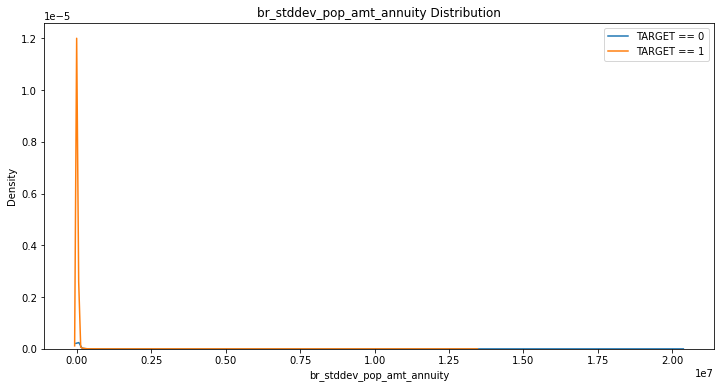

In [1237]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_annuity', app_train)

In [1238]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_stddev_pop_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1239]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1240]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1241]:
#app_train['br_stddev_pop_amt_annuity'].isnull().sum()

In [1242]:
#app_train[['TARGET', 'br_stddev_pop_amt_annuity']].corr()

In [1243]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_amt_annuity']].corr()

In [1244]:
## 標準化
#num_cols = ['br_stddev_pop_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_stddev_pop_amt_annuity', 'TARGET']].corr()

In [1245]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_pop_amt_annuity', app_train)

In [1246]:
columns = ['br_stddev_pop_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_pop_amt_annuity

In [1247]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_annuity']].corr()

TARGET  br_var_pop_amt_annuity
TARGET                  1.000000                0.001251
br_var_pop_amt_annuity  0.001251                1.000000

In [1248]:
app_train['br_var_pop_amt_annuity'].isnull().sum()

216533

The correlation between br_var_pop_amt_annuity and the TARGET is 0.0013
Median value for loan that was not repaid = 2166436.2657
Median value for loan that was repaid =     0.0000


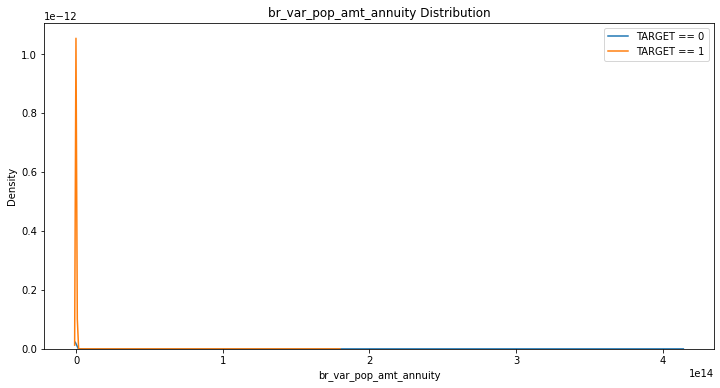

In [1249]:
## 特徴量の分布
kde_target('br_var_pop_amt_annuity', app_train)

In [1250]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_pop_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1251]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1252]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1253]:
#app_train['br_var_pop_amt_annuity'].isnull().sum()

In [1254]:
#app_train[['TARGET', 'br_var_pop_amt_annuity']].corr()

In [1255]:
## Yao-Johnson変換
#num_cols = ['br_var_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_pop_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_var_pop_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_pop_amt_annuity']].corr()

In [1258]:
## 標準化
#num_cols = ['br_var_pop_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_pop_amt_annuity', 'TARGET']].corr()

In [1259]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_pop_amt_annuity', app_train)

In [1260]:
columns = ['br_var_pop_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_var_samp_amt_annuity

In [1261]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_annuity']].corr()

TARGET  br_var_samp_amt_annuity
TARGET                   1.000000                 0.001219
br_var_samp_amt_annuity  0.001219                 1.000000

In [1262]:
app_train['br_var_samp_amt_annuity'].isnull().sum()

216533

The correlation between br_var_samp_amt_annuity and the TARGET is 0.0012
Median value for loan that was not repaid = 2210109.2466
Median value for loan that was repaid =     0.0000


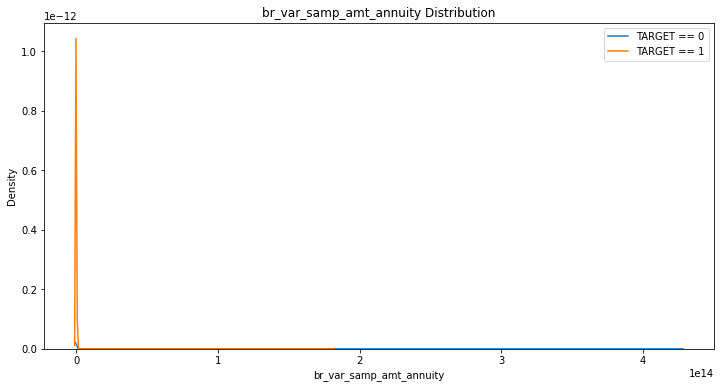

In [1263]:
## 特徴量の分布
kde_target('br_var_samp_amt_annuity', app_train)

In [1264]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_var_samp_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1265]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1266]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1267]:
#app_train['br_var_samp_amt_annuity'].isnull().sum()

In [1268]:
#app_train[['TARGET', 'br_var_samp_amt_annuity']].corr()

In [1269]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_amt_annuity']].corr()

In [1270]:
## 標準化
#num_cols = ['br_var_samp_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_var_samp_amt_annuity', 'TARGET']].corr()

In [1271]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_amt_annuity', app_train)

In [1272]:
columns = ['br_var_samp_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### br_variance_pop_amt_annuity

In [1273]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_annuity']].corr()

TARGET  br_variance_pop_amt_annuity
TARGET                       1.000000                     0.001251
br_variance_pop_amt_annuity  0.001251                     1.000000

In [1274]:
app_train['br_variance_pop_amt_annuity'].isnull().sum()

216533

The correlation between br_variance_pop_amt_annuity and the TARGET is 0.0013
Median value for loan that was not repaid = 2166436.2657
Median value for loan that was repaid =     0.0000


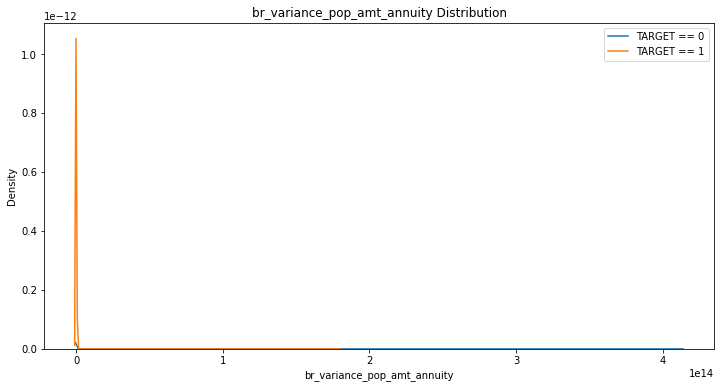

In [1275]:
## 特徴量の分布
kde_target('br_variance_pop_amt_annuity', app_train)

In [1276]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('br_variance_pop_amt_annuity')

#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1277]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1278]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1279]:
#app_train['br_variance_pop_amt_annuity'].isnull().sum()

In [1280]:
#app_train[['TARGET', 'br_variance_pop_amt_annuity']].corr()

In [1281]:
## Yao-Johnson変換
#num_cols = ['br_variance_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_variance_pop_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['br_variance_pop_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_variance_pop_amt_annuity']].corr()

In [1282]:
## 標準化
#num_cols = ['br_variance_pop_amt_annuity']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['br_variance_pop_amt_annuity', 'TARGET']].corr()

In [ ]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_variance_pop_amt_annuity', app_train)

In [1283]:
columns = ['br_variance_pop_amt_annuity']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

## CSVをEXPORT

In [1284]:
app_train['SK_ID_CURR'] = app_train[["SK_ID_CURR"]].astype(int) 
app_test['SK_ID_CURR'] = app_test[["SK_ID_CURR"]].astype(int)
app_test.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  br_max_days_credit_update  \
0               0.0  ...                   0.652220   
1               0.0  ...                   0.622462   
2               0.0  ...                   0.664288   
3               0.0  ...                   0.569785   
4               0.0  ...                   0.003725   

   br_sum_days_credit_update  br_avg_days_credit_update  \
0                   0.949388                   1.482363   
1                   1.593460                   1.650287   
2                  -1.011757                  -1.212193   
3                  -3.899918                  -0.975160   
4                  -1.084701                  -0.370635   

   br_cnt_days_credit_update  br_stddev_days_credit_update  \
0                   1.118111                     -1.582800   
1                  -1.848955                     -1.719390   
2                   0.493894                      1.498769   
3                   3.144895                      1.105585   
4                   0.855900                      0.542619   

   br_stddev_pop_days_credit_update  br_var_pop_days_credit_update  \
0                         -1.582800                      -0.787008   
1                         -1.719390                      -0.804497   
2                          1.498769                       0.551118   
3                          1.105585                       0.271810   
4                          0.542619                       0.203569   

   br_var_samp_days_credit_update  br_variance_pop_days_credit_update  \
0                       -0.801333                           -0.787008   
1                       -0.817865                           -0.804497   
2                        0.556139                            0.551118   
3                        0.268598                            0.271810   
4                        0.203834                            0.203569   

   br_cnt_amt_annuity  
0            1.118111  
1           -1.848955  
2            0.493894  
3            3.144895  
4            0.855900  

[5 rows x 153 columns]

In [1285]:
app_train.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                 0.0          1.0           0.0   
1      100003       0                 0.0          0.0           0.0   
2      100004       0                 1.0          1.0           1.0   
3      100006       0                 0.0          0.0           0.0   
4      100007       0                 0.0          1.0           0.0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0           0.0          202500.0    406597.5      24700.5         351000.0   
1           0.0          270000.0   1293502.5      35698.5        1129500.0   
2           0.0           67500.0    135000.0       6750.0         135000.0   
3           0.0          135000.0    312682.5      29686.5         297000.0   
4           0.0          121500.0    513000.0      21865.5         513000.0   

   ...  br_max_days_credit_update  br_sum_days_credit_update  \
0  ...                   0.646228                   0.803653   
1  ...                   0.375166                   0.030714   
2  ...                  -0.656678                  -0.146139   
3  ...                  -0.328809                  -0.123420   
4  ...                  -0.345206                  -0.442987   

   br_avg_days_credit_update  br_cnt_days_credit_update  \
0                   0.327981                  -0.757193   
1                   0.412264                   0.232413   
2                  -1.234744                   0.753689   
3                  -0.310885                   0.046024   
4                  -0.293618                  -0.124653   

   br_stddev_days_credit_update  br_stddev_pop_days_credit_update  \
0                      1.020071                          1.020071   
1                      0.058677                          0.058677   
2                      0.569932                          0.569932   
3                      0.165406                          0.165406   
4                      0.164202                          0.164202   

   br_var_pop_days_credit_update  br_var_samp_days_credit_update  \
0                       0.215492                        0.224852   
1                       0.073018                        0.074503   
2                       0.144558                        0.145545   
3                       0.101341                        0.102554   
4                       0.187250                        0.187336   

   br_variance_pop_days_credit_update  br_cnt_amt_annuity  
0                            0.215492           -0.757193  
1                            0.073018            0.232413  
2                            0.144558            0.753689  
3                            0.101341            0.046024  
4                            0.187250           -0.124653  

[5 rows x 154 columns]

In [1286]:
remove_columns = list(app_test_origin.columns)
remove_columns.remove('SK_ID_CURR')
remove_columns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'OCCUPATION_TYPE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_M

In [1287]:
app_train.drop(remove_columns, axis=1, inplace=True)
app_test.drop(remove_columns, axis=1, inplace=True)
app_br_train = app_train.copy()
app_br_test = app_test.copy()
app_br_test.head()

SK_ID_CURR  br_cnt_credit_day_overdue  br_stddev_credit_day_overdue  \
0      100001                   1.118111                     -0.250486   
1      100005                  -1.848955                     -0.250486   
2      100013                   0.493894                     -0.250486   
3      100028                   3.144895                     -0.250486   
4      100038                   0.855900                      0.014643   

   br_stddev_pop_credit_day_overdue  br_min_days_credit_enddate  \
0                         -0.250486                   -0.969660   
1                         -0.250486                    0.869297   
2                         -0.250486                   -1.613250   
3                         -0.250486                   -1.882548   
4                          0.014643                   -0.465686   

   br_max_days_credit_enddate  br_sum_days_credit_enddate  \
0                   -0.466681                   -0.789923   
1                   -0.566317                   -0.228487   
2                   -1.502604                   -1.786589   
3                    4.440772                    3.939951   
4                    0.255606                    0.149101   

   br_avg_days_credit_enddate  br_cnt_days_credit_enddate  \
0                   -0.687354                    1.265074   
1                   -0.188841                   -1.730519   
2                   -1.800991                    0.624312   
3                    0.857916                    2.919324   
4                    0.016150                    0.858335   

   br_stddev_days_credit_enddate  ...  br_max_days_credit_update  \
0                      -0.550665  ...                   0.652220   
1                      -0.615035  ...                   0.622462   
2                      -0.712106  ...                   0.664288   
3                       4.075118  ...                   0.569785   
4                       0.180503  ...                   0.003725   

   br_sum_days_credit_update  br_avg_days_credit_update  \
0                   0.949388                   1.482363   
1                   1.593460                   1.650287   
2                  -1.011757                  -1.212193   
3                  -3.899918                  -0.975160   
4                  -1.084701                  -0.370635   

   br_cnt_days_credit_update  br_stddev_days_credit_update  \
0                   1.118111                     -1.582800   
1                  -1.848955                     -1.719390   
2                   0.493894                      1.498769   
3                   3.144895                      1.105585   
4                   0.855900                      0.542619   

   br_stddev_pop_days_credit_update  br_var_pop_days_credit_update  \
0                         -1.582800                      -0.787008   
1                         -1.719390                      -0.804497   
2                          1.498769                       0.551118   
3                          1.105585                       0.271810   
4                          0.542619                       0.203569   

   br_var_samp_days_credit_update  br_variance_pop_days_credit_update  \
0                       -0.801333                           -0.787008   
1                       -0.817865                           -0.804497   
2                        0.556139                            0.551118   
3                        0.268598                            0.271810   
4                        0.203834                            0.203569   

   br_cnt_amt_annuity  
0            1.118111  
1           -1.848955  
2            0.493894  
3            3.144895  
4            0.855900  

[5 rows x 62 columns]

In [1288]:
### train
app_train.to_csv(
    path_or_buf="./home-credit-default-risk/exports/hc_br_train_axis-12.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1289]:
### test
app_test.to_csv(
    path_or_buf="./home-credit-default-risk/exports/hc_br_test_axis-12.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1290]:
columns = list(app_train.columns)
columns.remove('SK_ID_CURR')
columns.remove('TARGET')

In [1291]:
data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]


y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

In [1292]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = columns

params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    
    #oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    #y_pred = model.predict(X_test, num_iteration=model.best_iteration)##

    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

[09:12:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_state", "silent", "subsumple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.66695	eval-auc:0.65095
[1]	train-auc:0.67998	eval-auc:0.65994
[2]	train-auc:0.68621	eval-auc:0.66339
[3]	train-auc:0.69066	eval-auc:0.66558
[4]	train-auc:0.69436	eval-auc:0.66737
[5]	train-auc:0.69775	eval-auc:0.66801
[6]	train-auc:0.69953	eval-auc:0.66890
[7]	train-auc:0.70202	eval-auc:0.66946
[8]	train-auc:0.70476	eval-auc:0.66994
[9]	train-auc:0.70744	eval-auc:0.67062
[10]	train-auc:0.70999	eval-auc:0.67070
[11]	train-auc:0.71253	eval-auc:0.67109
[12]	train-auc:0.71473	eval-auc:0.67140
[13]	train-auc:0.71660	eval-auc:0.67183
[14

[12]	train-auc:0.71115	eval-auc:0.67400
[13]	train-auc:0.71286	eval-auc:0.67426
[14]	train-auc:0.71538	eval-auc:0.67465
[15]	train-auc:0.71687	eval-auc:0.67506
[16]	train-auc:0.71861	eval-auc:0.67529
[17]	train-auc:0.72043	eval-auc:0.67536
[18]	train-auc:0.72240	eval-auc:0.67607
[19]	train-auc:0.72390	eval-auc:0.67631
[20]	train-auc:0.72563	eval-auc:0.67650
[21]	train-auc:0.72658	eval-auc:0.67649
[22]	train-auc:0.72809	eval-auc:0.67642
[23]	train-auc:0.72927	eval-auc:0.67633
[24]	train-auc:0.73096	eval-auc:0.67658
[25]	train-auc:0.73234	eval-auc:0.67681
[26]	train-auc:0.73360	eval-auc:0.67689
[27]	train-auc:0.73522	eval-auc:0.67742
[28]	train-auc:0.73646	eval-auc:0.67748
[29]	train-auc:0.73813	eval-auc:0.67726
[30]	train-auc:0.74001	eval-auc:0.67770
[31]	train-auc:0.74103	eval-auc:0.67811
[32]	train-auc:0.74225	eval-auc:0.67851
[33]	train-auc:0.74374	eval-auc:0.67865
[34]	train-auc:0.74499	eval-auc:0.67839
[35]	train-auc:0.74656	eval-auc:0.67853
[36]	train-auc:0.74844	eval-auc:0.67828


In [1293]:
remove_columns = ['TARGET']
app_br_train.drop(remove_columns, axis=1, inplace=True)
app_br_train.head()

SK_ID_CURR  br_cnt_credit_day_overdue  br_stddev_credit_day_overdue  \
0      100002                  -0.757193                     -0.250486   
1      100003                   0.232413                     -0.119925   
2      100004                   0.753689                      0.251581   
3      100006                   0.046024                      0.187642   
4      100007                  -0.124653                      0.234648   

   br_stddev_pop_credit_day_overdue  br_min_days_credit_enddate  \
0                         -0.250486                   -0.489194   
1                         -0.119925                    0.422557   
2                          0.251581                   -0.001492   
3                          0.187642                    0.038149   
4                          0.234648                   -0.410744   

   br_max_days_credit_enddate  br_sum_days_credit_enddate  \
0                   -0.691686                   -0.386206   
1                    0.228648                    0.271119   
2                   -0.051924                   -0.079740   
3                   -0.030603                   -0.044365   
4                   -0.028329                   -0.063128   

   br_avg_days_credit_enddate  br_cnt_days_credit_enddate  \
0                   -0.690845                   -1.339629   
1                    0.295330                    0.215540   
2                   -0.010831                    0.762996   
3                    0.016954                    0.060456   
4                   -0.103982                   -0.107049   

   br_stddev_days_credit_enddate  ...  br_max_days_credit_update  \
0                      -0.559061  ...                   0.646228   
1                       0.127275  ...                   0.375166   
2                      -0.107014  ...                  -0.656678   
3                      -0.067154  ...                  -0.328809   
4                      -0.064766  ...                  -0.345206   

   br_sum_days_credit_update  br_avg_days_credit_update  \
0                   0.803653                   0.327981   
1                   0.030714                   0.412264   
2                  -0.146139                  -1.234744   
3                  -0.123420                  -0.310885   
4                  -0.442987                  -0.293618   

   br_cnt_days_credit_update  br_stddev_days_credit_update  \
0                  -0.757193                      1.020071   
1                   0.232413                      0.058677   
2                   0.753689                      0.569932   
3                   0.046024                      0.165406   
4                  -0.124653                      0.164202   

   br_stddev_pop_days_credit_update  br_var_pop_days_credit_update  \
0                          1.020071                       0.215492   
1                          0.058677                       0.073018   
2                          0.569932                       0.144558   
3                          0.165406                       0.101341   
4                          0.164202                       0.187250   

   br_var_samp_days_credit_update  br_variance_pop_days_credit_update  \
0                        0.224852                            0.215492   
1                        0.074503                            0.073018   
2                        0.145545                            0.144558   
3                        0.102554                            0.101341   
4                        0.187336                            0.187250   

   br_cnt_amt_annuity  
0           -0.757193  
1            0.232413  
2            0.753689  
3            0.046024  
4           -0.124653  

[5 rows x 62 columns]

In [1294]:
# trainへマージ
app_train = pd.merge(app_train_origin.copy(), app_br_train, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test_origin.copy(), app_br_test, on='SK_ID_CURR', how='left')
app_train.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                 0.0          1.0           0.0   
1      100003       0                 0.0          0.0           0.0   
2      100004       0                 1.0          1.0           1.0   
3      100006       0                 0.0          0.0           0.0   
4      100007       0                 0.0          1.0           0.0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0           0.0          202500.0    406597.5      24700.5         351000.0   
1           0.0          270000.0   1293502.5      35698.5        1129500.0   
2           0.0           67500.0    135000.0       6750.0         135000.0   
3           0.0          135000.0    312682.5      29686.5         297000.0   
4           0.0          121500.0    513000.0      21865.5         513000.0   

   ...  br_max_days_credit_update  br_sum_days_credit_update  \
0  ...                   0.646228                   0.803653   
1  ...                   0.375166                   0.030714   
2  ...                  -0.656678                  -0.146139   
3  ...                  -0.328809                  -0.123420   
4  ...                  -0.345206                  -0.442987   

   br_avg_days_credit_update  br_cnt_days_credit_update  \
0                   0.327981                  -0.757193   
1                   0.412264                   0.232413   
2                  -1.234744                   0.753689   
3                  -0.310885                   0.046024   
4                  -0.293618                  -0.124653   

   br_stddev_days_credit_update  br_stddev_pop_days_credit_update  \
0                      1.020071                          1.020071   
1                      0.058677                          0.058677   
2                      0.569932                          0.569932   
3                      0.165406                          0.165406   
4                      0.164202                          0.164202   

   br_var_pop_days_credit_update  br_var_samp_days_credit_update  \
0                       0.215492                        0.224852   
1                       0.073018                        0.074503   
2                       0.144558                        0.145545   
3                       0.101341                        0.102554   
4                       0.187250                        0.187336   

   br_variance_pop_days_credit_update  br_cnt_amt_annuity  
0                            0.215492           -0.757193  
1                            0.073018            0.232413  
2                            0.144558            0.753689  
3                            0.101341            0.046024  
4                            0.187250           -0.124653  

[5 rows x 154 columns]

In [1295]:
columns = list(app_train.columns)
columns

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'OCCUPATION_TYPE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVIN

In [1297]:
columns = list(app_train.columns)
columns.remove('SK_ID_CURR')
columns.remove('TARGET')

In [1298]:
data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]

y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

In [1299]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = columns

params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

[09:13:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_state", "silent", "subsumple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.73617	eval-auc:0.72090
[1]	train-auc:0.74849	eval-auc:0.72610
[2]	train-auc:0.75583	eval-auc:0.73029
[3]	train-auc:0.76005	eval-auc:0.73268
[4]	train-auc:0.76343	eval-auc:0.73367
[5]	train-auc:0.76662	eval-auc:0.73483
[6]	train-auc:0.76901	eval-auc:0.73606
[7]	train-auc:0.77139	eval-auc:0.73668
[8]	train-auc:0.77316	eval-auc:0.73722
[9]	train-auc:0.77441	eval-auc:0.73769
[10]	train-auc:0.77656	eval-auc:0.73855
[11]	train-auc:0.77861	eval-auc:0.73925
[12]	train-auc:0.78041	eval-auc:0.73938
[13]	train-auc:0.78238	eval-auc:0.73977
[14

In [1300]:
# CSV-00
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[0]
submit_all.isnull().sum()

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_00.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1301]:
# CSV-01
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[1]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_01.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1302]:
# CSV-02
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[2]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_02.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1303]:
# CSV-03
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[3]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_03.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1304]:
# CSV-04
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[4]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_04.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1305]:
submit_all_00 = pd.read_csv('./home-credit-default-risk/submit/submit_all_00.csv')
submit_all_01 = pd.read_csv('./home-credit-default-risk/submit/submit_all_01.csv')
submit_all_02 = pd.read_csv('./home-credit-default-risk/submit/submit_all_02.csv')
submit_all_03 = pd.read_csv('./home-credit-default-risk/submit/submit_all_03.csv')
submit_all_04 = pd.read_csv('./home-credit-default-risk/submit/submit_all_04.csv')

In [1306]:
submit_all = pd.DataFrame({
    'submit_all_00': submit_all_00['TARGET'].values
    ,'submit_all_01': submit_all_01['TARGET'].values
    ,'submit_all_02': submit_all_02['TARGET'].values
    ,'submit_all_03': submit_all_03['TARGET'].values
    ,'submit_all_04': submit_all_04['TARGET'].values
    })
submit_all.head()

submit_all_00  submit_all_01  submit_all_02  submit_all_03  submit_all_04
0       0.067310       0.068506       0.053305       0.054890       0.076942
1       0.134116       0.102972       0.115630       0.088456       0.115379
2       0.020923       0.029706       0.026401       0.028086       0.030884
3       0.046933       0.043575       0.035064       0.036828       0.034107
4       0.132247       0.091218       0.129281       0.120157       0.129981

In [1307]:
submit_all = app_test[["SK_ID_CURR"]].astype(int).copy()
submit_all['TARGET'] = (submit_all_00['TARGET'] + submit_all_01['TARGET'] + submit_all_02['TARGET'] + submit_all_03['TARGET'] + submit_all_04['TARGET'])/5
submit_all.head()

SK_ID_CURR    TARGET
0      100001  0.064191
1      100005  0.111311
2      100013  0.027200
3      100028  0.039301
4      100038  0.120577

In [1308]:
submit_all['TARGET'] = (submit_all['TARGET'] / 5)
submit_all.to_csv('./home-credit-default-risk/submit/submit_br_main_axis-12.csv', index=False)
submit_all.head()

SK_ID_CURR    TARGET
0      100001  0.012838
1      100005  0.022262
2      100013  0.005440
3      100028  0.007860
4      100038  0.024115

In [1309]:
submit_all.count()

SK_ID_CURR    48744
TARGET        48744
dtype: int64